# Imports:

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from mne.decoding import CSP
from sklearn.metrics import classification_report, confusion_matrix
import copy
import sys, os
import pandas as pd
import time
from scipy import signal
import scipy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#import torch
#from torch import nn
from sklearn.metrics import classification_report
from contextlib import redirect_stdout, redirect_stderr
import io
import pickle
import time
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import random
#from torchsummary import summary
#import torchinfo
#import moabb

# EEGNet-specific imports
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
# Parameter tunning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from scikeras.wrappers import KerasClassifier



import json

# ATCNet Model imports
import models

In [4]:
# projects/def-b09sdp/bijan/Phase2/P16.fdt
path = !pwd
path

['/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI']

# Functions:

In [5]:
def data_wrapper(data_epochs, data_labels, mode='binary'):
    
    if mode == 'binary':
        epochs = []
        labels = []

        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            binary_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2)]
            #class2_epochs = participant_epochs[participant_labels==2]
            #bi_epochs = np.concatenate((class1_epochs, class2_epochs), axis=0)
            epochs.append(binary_epochs)
    
            binary_labels = participant_labels[(participant_labels==1) | (participant_labels==2)]
            #bi_labels = np.concatenate((class1_labels, class2_labels), axis=0)
            labels.append(binary_labels)
            
    elif mode == '3_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==1) | (participant_labels==2) | (participant_labels==3)]
            labels.append(multiclass_labels)
            
            
    elif mode == '4_class_RS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==2) | (participant_labels==6) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
        
    elif mode == '4_class_LS':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==1)]
            labels.append(multiclass_labels)
    elif mode == '6_class':
        
        epochs = []
        labels = []
        
        for i in range(len(data_epochs)):
            participant_epochs = data_epochs[i]
            participant_labels = data_labels[i]
    
            multiclass_epochs = participant_epochs[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            epochs.append(multiclass_epochs)
    
            multiclass_labels = participant_labels[(participant_labels==3) | (participant_labels==7) | (participant_labels==5) | (participant_labels==6) | (participant_labels==2) | (participant_labels==1)]
            labels.append(multiclass_labels)
    
    return epochs, labels

In [6]:
def epoch_label_extractor(data, events, epoch_length, num_channels, sampling_freq):
    
    data = data.to_data_frame()
    events = events[0]
    third_column = events[:, 2]
    mask = np.isin(third_column, [7, 8, 9, 10])
    MI_events = events[mask]
    
    number_of_epochs = MI_events.shape[0]
    labels = np.zeros((number_of_epochs,1)).astype(int)
    epochs = np.zeros((number_of_epochs, num_channels, epoch_length * sampling_freq))
    index = 0
    for index in range(number_of_epochs):
        start = int(MI_events[index, 0])
        end = int(MI_events[index, 0]) + epoch_length * sampling_freq
        all_channels = data.iloc[start:end]
        epochs[index,:,:] = all_channels[all_channels.columns[1: num_channels+1]].T
        
        # Because it is numbered form 7 to 10 !!!
        labels[index] = MI_events[index, 2] - 7

            
    return epochs, labels

In [7]:
def epoch_label_extractor(Data, epoch_length=1123, num_channels=64):
    df = Data.to_data_frame()
    X = df[df.columns[3:]].to_numpy()
    X = np.transpose(X)

    number_of_epochs = int(len(df)/epoch_length)
    
    randomlist = random.sample(range(number_of_epochs), number_of_epochs)

    data = np.zeros((number_of_epochs,num_channels, epoch_length))
    labels = np.zeros((number_of_epochs,1)).astype(int)

    for i in range(number_of_epochs):
        data[i,:,:] = X[:, randomlist[i]*epoch_length:(randomlist[i] + 1)*epoch_length]
        if (df['condition'][randomlist[i]*epoch_length] == 'Left'):
            labels[i,0] = 0
        elif(df['condition'][randomlist[i]*epoch_length] == 'Right'):
            labels[i,0] = 1
        elif(df['condition'][randomlist[i]*epoch_length] == 'Feet'):
            labels[i,0] = 2
        elif(df['condition'][randomlist[i]*epoch_length] == 'Tongue'):
            labels[i,0] = 3
        elif(df['condition'][randomlist[i]*epoch_length] == 'Mis'):
            labels[i,0] = 4
        elif(df['condition'][randomlist[i]*epoch_length] == 'Si'):
            labels[i,0] = 5
        elif(df['condition'][randomlist[i]*epoch_length] == 'Rest'):
            labels[i,0] = 6
        elif(df['condition'][randomlist[i]*epoch_length] == 'Ls'):
            labels[i,0] = 7
        elif(df['condition'][randomlist[i]*epoch_length] == 'Rs'):
            labels[i,0] = 8
        elif(df['condition'][randomlist[i]*epoch_length] == 'Fs'):
            labels[i,0] = 9
        else:
            labels[i,0] = 10
        
    return data, labels

In [8]:
def encoder(y_data, method=OneHotEncoder):
    
    encoder = OneHotEncoder()
    encoder.fit(y_data[0].reshape(-1, 1))
    
    for i in range(len(y_data)):
        
        a = encoder.transform(y_data[i].reshape(-1, 1))
        y_data[i] = a.toarray()

    return y_data

In [9]:
def class_extraction(classes, data, labels):
    mask = np.isin(labels[:, 0], classes)
    dataset = data[mask, :, :]
    Final_labels = labels[mask, :]
    return dataset, Final_labels

In [10]:
def calc_csp(x_train, y_train, x_test, n_components=16):
    
        csp = CSP(n_components)
        csp_fit = csp.fit(x_train, y_train)
        train_feat = csp_fit.transform(x_train)
        test_feat = csp_fit.transform(x_test)
        return train_feat, test_feat

In [11]:
def feature_extraction_4(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        filtered_data = mne.filter.filter_data(data, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False, filter_length=50)
        filtered_data_test = mne.filter.filter_data(data_test, sampling_freq, low_cutoff, low_cutoff + 4, verbose = False)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [12]:
def feature_extraction_cheby2(train_data, train_labels, test_data, sampling_freq, n_components):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(15, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features

In [13]:
def Preprocess_validator(train_data, train_labels, test_data, sampling_freq, n_components=2):

    # Why number of bands were set to 24??
    [n_epochs_train, n_split, n_channels, n_samples] = train_data.shape
    [n_epochs_test, _, _, _] = test_data.shape
    
    
    
    low_cutoff = 4
    number_of_bands = 16
    for b in range(number_of_bands):
        data = train_data.copy()
        new_train_labels = np.repeat(train_labels, n_split)
        data = data.reshape((n_epochs_train * n_split, n_channels, n_samples))
        data_test = test_data.copy()
        data_test = data_test.reshape((n_epochs_test * n_split, n_channels, n_samples))
        
        sos1 = signal.cheby2(40, 20, [low_cutoff, low_cutoff + 4], 'bp', fs=250, output='sos')
        
        filtered_data = signal.sosfilt(sos1, data)
        print("The filtered data shape:", filtered_data.shape)
        filtered_data_test = signal.sosfilt(sos1, data_test)
        tic = time.time()
        train_feats, test_feats = calc_csp(filtered_data, new_train_labels, filtered_data_test, n_components)
        toc = time.time()
        print("Time taken for csp calculations: ", toc-tic)
        
        train_feats, test_feats = np.expand_dims(train_feats, axis=1), np.expand_dims(test_feats, axis=1)
        
        if b == 0:
            train_features = train_feats
            test_features = test_feats
        else:
            train_features = np.concatenate((train_features, train_feats), axis = 1)
            test_features = np.concatenate((test_features, test_feats), axis = 1)
        
        low_cutoff += 2
    
    train_features = train_features.reshape(n_epochs_train, n_split, number_of_bands, n_components)
    test_features  = test_features.reshape(n_epochs_test, n_split, number_of_bands, n_components) 
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return train_features, test_features, filtered_data.reshape((n_epochs_train, n_split, n_channels, n_samples))

# Device (GPU\CPU\MPS)

In [14]:

if tf.config.list_physical_devices('GPU'):
    device = "cuda"
else:
    # Check if TensorFlow Multi-Process Service (MPS) is available
    if tf.config.experimental.list_physical_devices('MPS'):
        device = "mps"
    else:
        device = "cpu"

print(f"Using {device} device")


Using cuda device


# ATCNet Model:

In [15]:
def getModel(model_name, dataset_conf):
    
    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://doi.org/10.1109/TII.2022.3197419
        model = models.ATCNet_( 
            # Dataset parameters
            n_classes = n_classes, 
            in_chans = n_channels, 
            in_samples = in_samples, 
            # Sliding window (SW) parameter
            n_windows = 5, 
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2, 
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2, 
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3, 
            tcn_activation='elu'
            )     
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)      
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)          
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples) 
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

In [16]:
dataset = 'BCI2a'
in_samples = 1000                   # Changed!!!
n_channels = 22
n_sub = 9
n_classes = 4
classes_labels = ['Left hand', 'Right hand','Foot','Tongue']



# Set dataset paramters as dataset configuration
dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                'isStandard': True, 'LOSO': True}


# Set training hyperparamters as train configuration
train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
              'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

model = getModel(train_conf.get('model'), dataset_conf)
    

2024-05-12 09:20:56.967141: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 09:21:00.067034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13625 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5
2024-05-12 09:21:00.081694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13625 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:5f:00.0, compute capability: 7.5
2024-05-12 09:21:00.084025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 1362

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 22, 1000  0           []                               
                                )]                                                                
                                                                                                  
 permute (Permute)              (None, 1000, 22, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 1000, 22, 16  1024        ['permute[0][0]']                
                                )                                                                 
                                                                                              

In [18]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
           dropoutRate = 0.5, kernLength = 64, F1 = 8, 
           D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout',
           learning_rate=0.0009):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.

    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 8))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 40),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 16))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    model = Model(inputs=input1, outputs=softmax)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Data reading:

In [19]:
path[0]

'/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI'

In [ ]:
try: 
    if path[0] == '/home/bijan/py3x/Code_Zhang/Transfer_Learning_On_EEG_BCI':
        print("Running on cloud ...")
        print("Please make sure to modify how you read the data according to your need!\n\n")
        raw_data_path = "/home/bijan/projects/def-b09sdp/bijan/Phase2"
        
    elif path[0] == "'pwd' is not recognized as an internal or external command,":
        print("Running local ...")
        print("Please make sure to change the data path!\n\n")
        raw_data_path = "D:\Hadi_BCI\Recordings\Phase 2\PreProcessedData\P16toP30"
        
except NameError:
    print("Running local ...")
    print("Please make sure to change the data path!\n\n")
    raw_data_path = "D:\Hadi_BCI\Recordings\Phase 2\PreProcessedData\P16toP30"
    
    

data_epochs = []
data_labels = []
all_data_epochs = []
all_data_labels = []

for participant_id in range(16, 31):
    
    participant_T = f"P{participant_id}"
    file_path_T = f"{raw_data_path}/{participant_T}.set"

    raw_data = mne.read_epochs_eeglab(file_path_T)


    epochs, labels = epoch_label_extractor(raw_data, epoch_length=1123, num_channels=64)
    
    class_1=1 # Right
    class_2=5 # SI
    class_3=7 # RS
    # class_4=5
    # class_5=6
    # class_6=7
    # class_7=8
    # class_8=9
    
    classes = [class_1, class_2, class_3]
    num_channels = 64
    epoch_length = 1123
    
    data_epochs, data_labels = class_extraction(classes, epochs, labels)
    
    all_data_epochs.append(data_epochs)
    all_data_labels.append(data_labels)


In [21]:
print(np.unique(labels))

[0 1 2 5 6 7 8 9]


In [22]:
for i in range(15):
    print("Subject {} train epochs:    ".format(i+1), all_data_epochs[i].shape, "    Subject {} train labels:    ".format(i+1), all_data_labels[i].shape)


Subject 1 train epochs:     (180, 64, 1123)     Subject 1 train labels:     (180, 1)
Subject 2 train epochs:     (60, 64, 1123)     Subject 2 train labels:     (60, 1)
Subject 3 train epochs:     (180, 64, 1123)     Subject 3 train labels:     (180, 1)
Subject 4 train epochs:     (180, 64, 1123)     Subject 4 train labels:     (180, 1)
Subject 5 train epochs:     (180, 64, 1123)     Subject 5 train labels:     (180, 1)
Subject 6 train epochs:     (180, 64, 1123)     Subject 6 train labels:     (180, 1)
Subject 7 train epochs:     (180, 64, 1123)     Subject 7 train labels:     (180, 1)
Subject 8 train epochs:     (180, 64, 1123)     Subject 8 train labels:     (180, 1)
Subject 9 train epochs:     (60, 64, 1123)     Subject 9 train labels:     (60, 1)
Subject 10 train epochs:     (180, 64, 1123)     Subject 10 train labels:     (180, 1)
Subject 11 train epochs:     (180, 64, 1123)     Subject 11 train labels:     (180, 1)
Subject 12 train epochs:     (180, 64, 1123)     Subject 12 train

In [23]:
all_data_labels[1][:, 0]

array([7, 7, 1, 1, 5, 5, 5, 1, 7, 1, 7, 7, 1, 7, 7, 7, 5, 7, 7, 5, 7, 1,
       5, 7, 7, 1, 5, 1, 1, 7, 5, 1, 7, 1, 5, 5, 1, 1, 5, 7, 1, 5, 5, 5,
       1, 7, 5, 1, 1, 1, 7, 7, 5, 1, 5, 7, 5, 5, 1, 5])

In [24]:
raw_data

<EpochsEEGLAB |  480 events (all good), -0.496 – 3.992 s, baseline off, ~263.3 MB, data loaded,
 'Rest': 60
 'Right': 60
 'Left': 60
 'Feet': 60
 'Si': 60
 'Rs': 60
 'Ls': 60
 'Fs': 60>

In [25]:
for i in range(len(all_data_epochs)):
    all_data_epochs[i] = np.expand_dims(all_data_epochs[i], 1)
    print("All data epoch shape (sub {}):    ".format(i), all_data_epochs[i].shape, "    All label shape (sub {}):     ".format(i), all_data_labels[i].shape)

All data epoch shape (sub 0):     (180, 1, 64, 1123)     All label shape (sub 0):      (180, 1)
All data epoch shape (sub 1):     (60, 1, 64, 1123)     All label shape (sub 1):      (60, 1)
All data epoch shape (sub 2):     (180, 1, 64, 1123)     All label shape (sub 2):      (180, 1)
All data epoch shape (sub 3):     (180, 1, 64, 1123)     All label shape (sub 3):      (180, 1)
All data epoch shape (sub 4):     (180, 1, 64, 1123)     All label shape (sub 4):      (180, 1)
All data epoch shape (sub 5):     (180, 1, 64, 1123)     All label shape (sub 5):      (180, 1)
All data epoch shape (sub 6):     (180, 1, 64, 1123)     All label shape (sub 6):      (180, 1)
All data epoch shape (sub 7):     (180, 1, 64, 1123)     All label shape (sub 7):      (180, 1)
All data epoch shape (sub 8):     (60, 1, 64, 1123)     All label shape (sub 8):      (60, 1)
All data epoch shape (sub 9):     (180, 1, 64, 1123)     All label shape (sub 9):      (180, 1)
All data epoch shape (sub 10):     (180, 1, 

In [26]:
all_data_labels[1][:10]

array([[7],
       [7],
       [1],
       [1],
       [5],
       [5],
       [5],
       [1],
       [7],
       [1]])

# Encoding

In [27]:
no_encode = copy.deepcopy(all_data_labels)
encoded = encoder(all_data_labels)


In [28]:
print("Epochs Length:", len(all_data_labels))
print("labels Length:", len(encoded))
print('\n\n')
print("Participant 16 - Epochs[0] shape:", no_encode[3].shape)
print("Participant 16 - labels[0] shape:", encoded[3].shape)
print('\n\n')
print("Participant 16 - labels[0]:")
print(all_data_labels[3][:5])

Epochs Length: 15
labels Length: 15



Participant 16 - Epochs[0] shape: (180, 1)
Participant 16 - labels[0] shape: (180, 3)



Participant 16 - labels[0]:
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


# Within Subject:

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 458ms/step - loss: 18.9694 - accuracy: 0.3681 - val_loss: 16.3303 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 16.2405 - accuracy: 0.4236 - val_loss: 15.8455 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 15.6182 - accuracy: 0.4931 - val_loss: 15.3790 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 85ms/step - loss: 15.1099 - accuracy: 0.

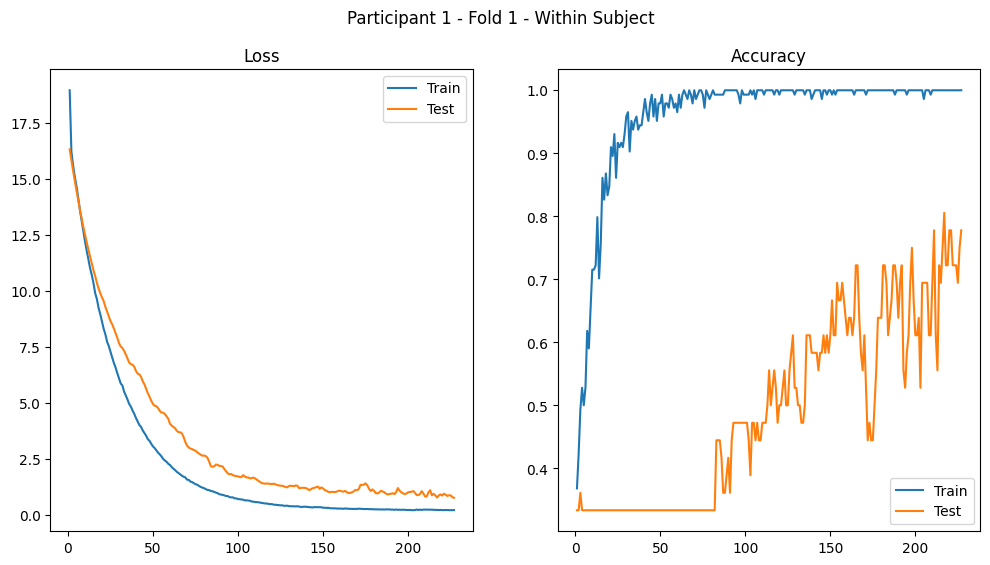

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 364ms/step - loss: 18.8567 - accuracy: 0.3194 - val_loss: 16.1166 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 16.1911 - accuracy: 0.3264 - val_loss: 15.6460 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 96ms/step - loss: 15.5184 - accuracy: 0.4375 - val_loss: 15.1872 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 100ms/step - loss: 15.0454 - accuracy: 0.3819 - v

<Figure size 640x480 with 0 Axes>

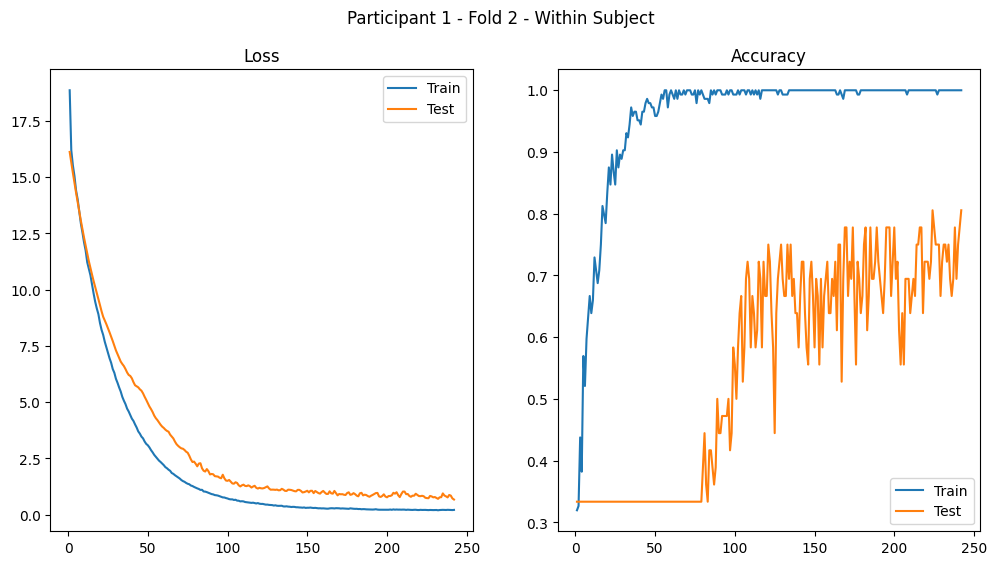

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 368ms/step - loss: 19.8659 - accuracy: 0.3958 - val_loss: 16.9898 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 95ms/step - loss: 17.0297 - accuracy: 0.4444 - val_loss: 16.4891 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 16.4361 - accuracy: 0.4097 - val_loss: 16.0040 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 85ms/step - loss: 15.7916 - accuracy: 0.4236 - va

<Figure size 640x480 with 0 Axes>

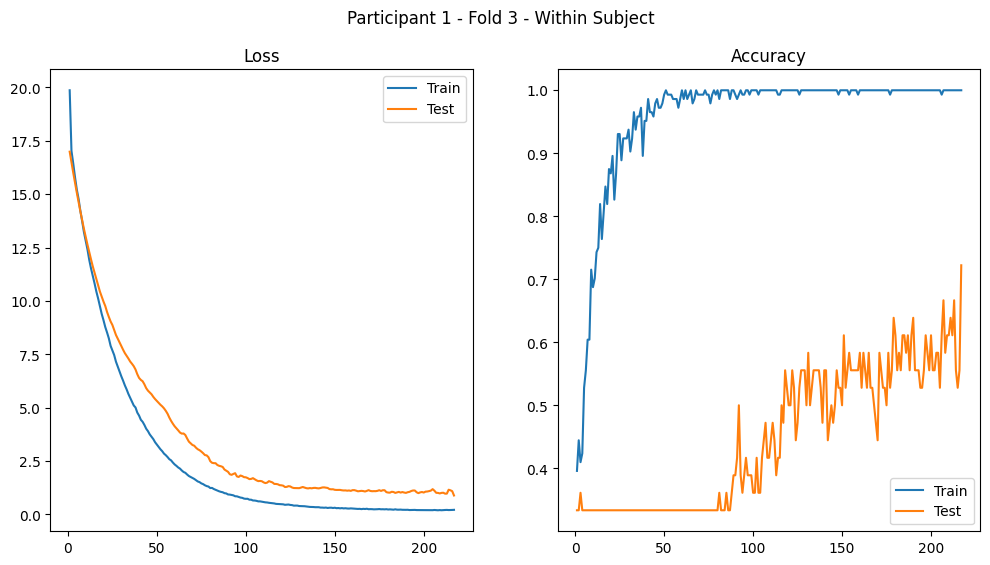

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 365ms/step - loss: 18.4892 - accuracy: 0.3125 - val_loss: 15.7818 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 87ms/step - loss: 15.6582 - accuracy: 0.4236 - val_loss: 15.3231 - val_accuracy: 0.4167
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 15.1039 - accuracy: 0.4653 - val_loss: 14.8705 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 93ms/step - loss: 14.6016 - accuracy: 0.5000 - va

<Figure size 640x480 with 0 Axes>

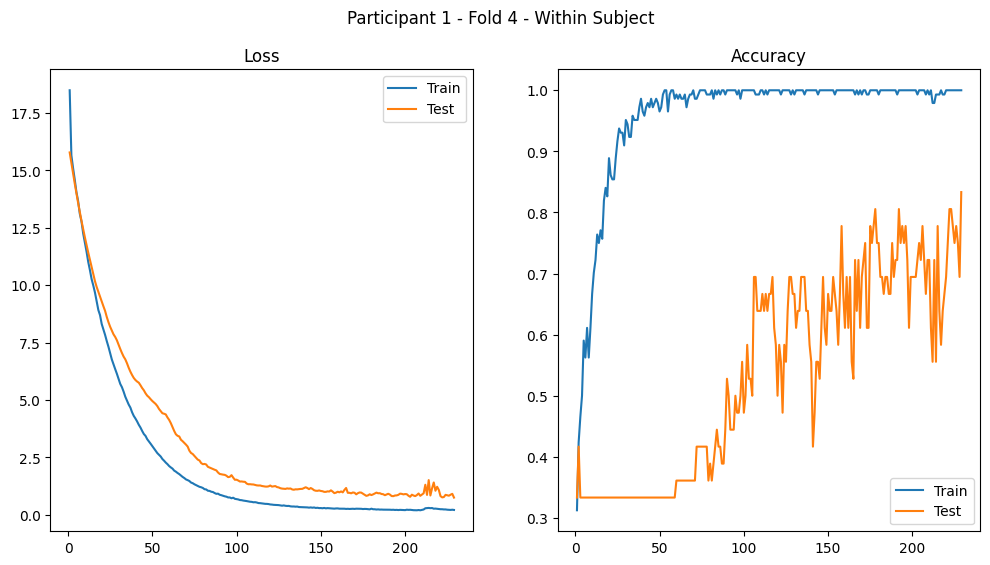

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 366ms/step - loss: 18.6519 - accuracy: 0.3333 - val_loss: 15.9703 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 15.8097 - accuracy: 0.4722 - val_loss: 15.5122 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 87ms/step - loss: 15.3242 - accuracy: 0.4722 - val_loss: 15.0760 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 84ms/step - loss: 14.8370 - accuracy: 0.4514 - va

<Figure size 640x480 with 0 Axes>

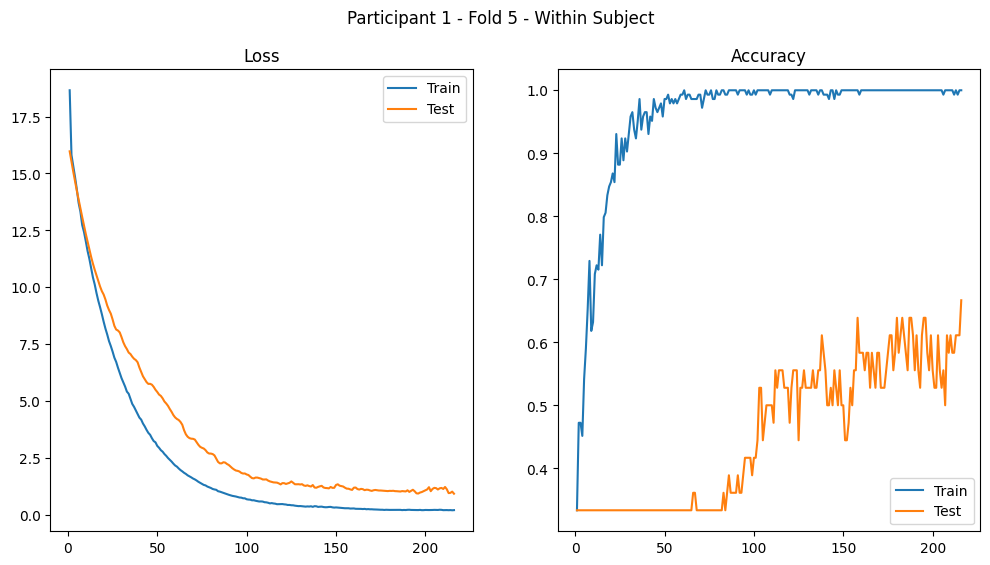

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 383ms/step - loss: 20.0987 - accuracy: 0.3681 - val_loss: 17.2859 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 79ms/step - loss: 17.0862 - accuracy: 0.4444 - val_loss: 16.7884 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 85ms/step - loss: 16.4296 - accuracy: 0.5694 - val_loss: 16.3100 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 75ms/step - loss: 15.8790 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

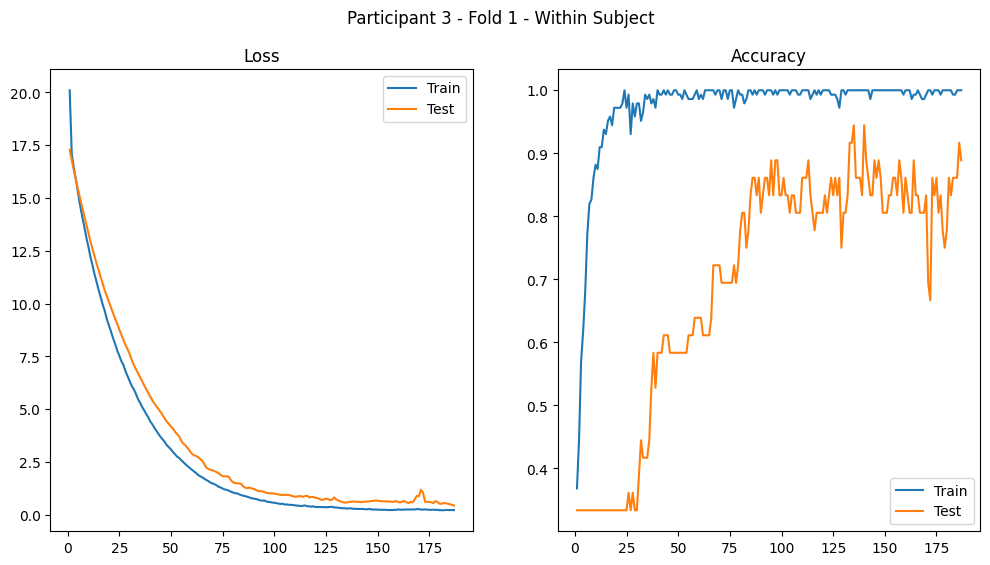

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 382ms/step - loss: 19.2354 - accuracy: 0.3403 - val_loss: 16.3802 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 103ms/step - loss: 16.1508 - accuracy: 0.4792 - val_loss: 15.8938 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 15.5813 - accuracy: 0.5139 - val_loss: 15.4358 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 96ms/step - loss: 14.8456 - accuracy: 0.7014 - v

<Figure size 640x480 with 0 Axes>

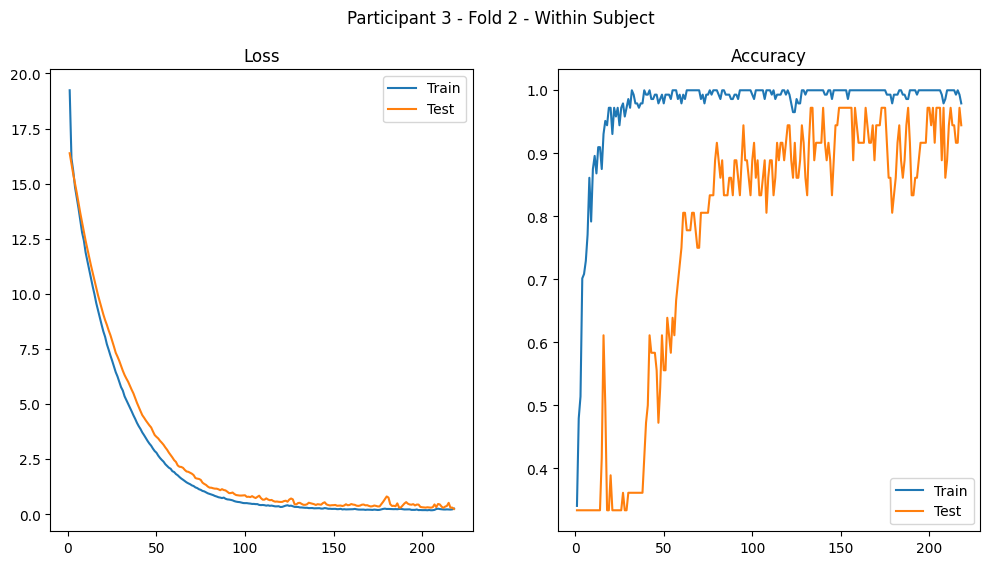

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 389ms/step - loss: 20.2734 - accuracy: 0.2986 - val_loss: 17.3690 - val_accuracy: 0.2500
Epoch 2/500
5/5 [==============================] - 0s 88ms/step - loss: 17.2418 - accuracy: 0.3958 - val_loss: 16.8752 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 78ms/step - loss: 16.7167 - accuracy: 0.4236 - val_loss: 16.3926 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 87ms/step - loss: 16.0920 - accuracy: 0.5278 - va

<Figure size 640x480 with 0 Axes>

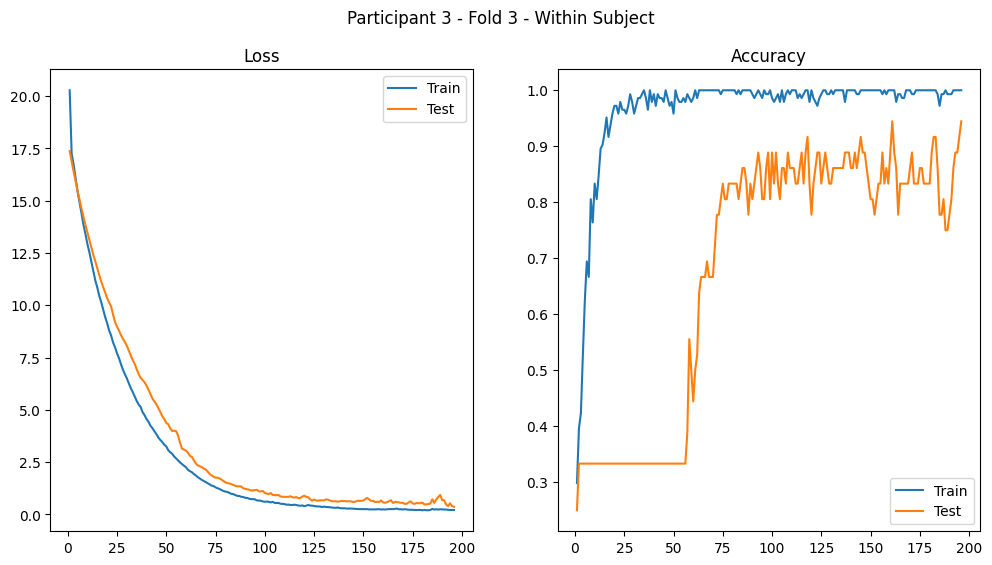

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 373ms/step - loss: 18.3673 - accuracy: 0.3264 - val_loss: 15.6795 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 15.5066 - accuracy: 0.4722 - val_loss: 15.2121 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 14.9329 - accuracy: 0.4514 - val_loss: 14.7671 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 14.2922 - accuracy: 0.5972 - va

<Figure size 640x480 with 0 Axes>

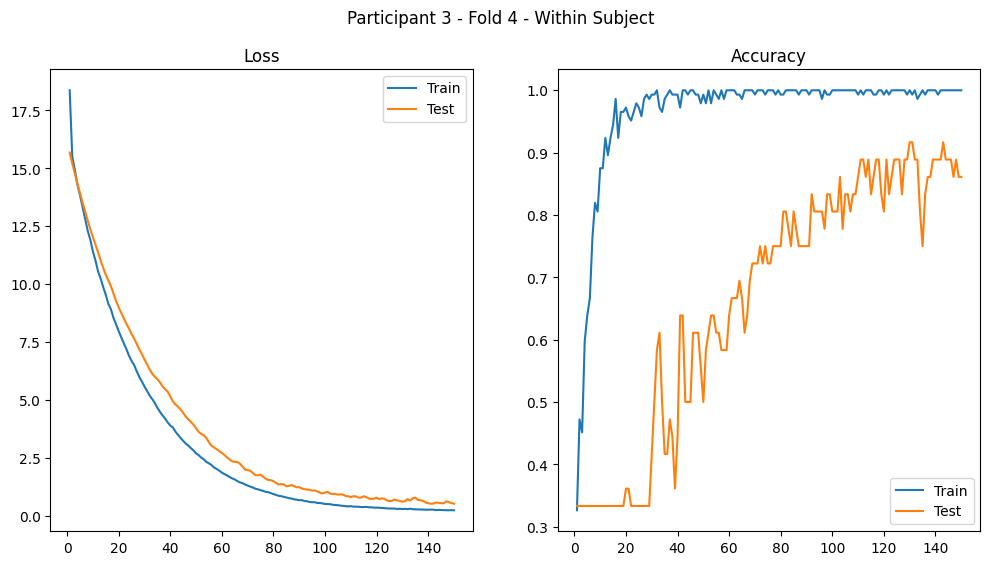

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 373ms/step - loss: 19.3981 - accuracy: 0.3056 - val_loss: 16.6755 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 16.5068 - accuracy: 0.4722 - val_loss: 16.1944 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 15.9353 - accuracy: 0.4792 - val_loss: 15.7253 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 90ms/step - loss: 15.3262 - accuracy: 0.5556 - va

<Figure size 640x480 with 0 Axes>

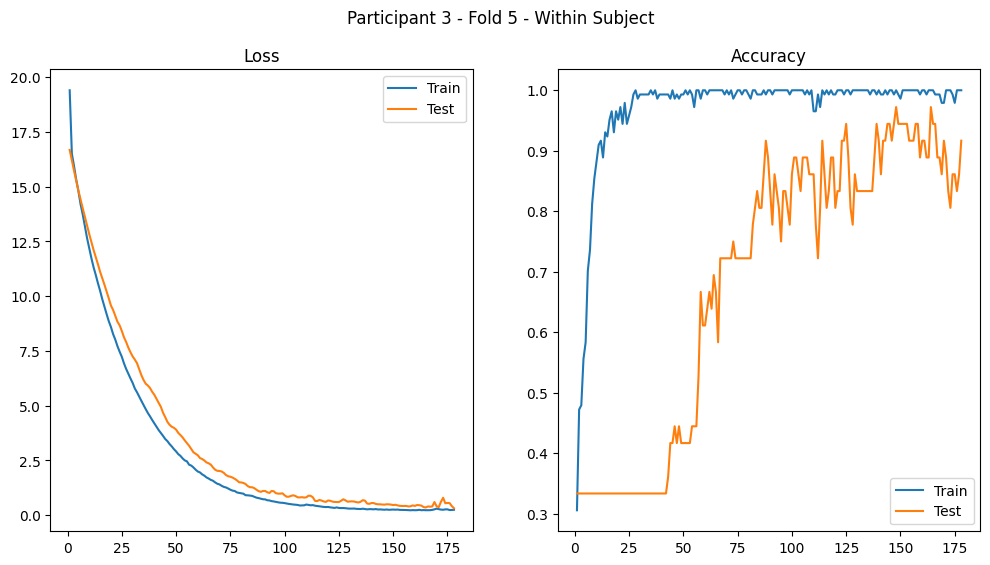

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 383ms/step - loss: 19.5151 - accuracy: 0.3403 - val_loss: 16.7009 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 16.7085 - accuracy: 0.3333 - val_loss: 16.2130 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 96ms/step - loss: 16.0923 - accuracy: 0.4236 - val_loss: 15.7368 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 15.5563 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

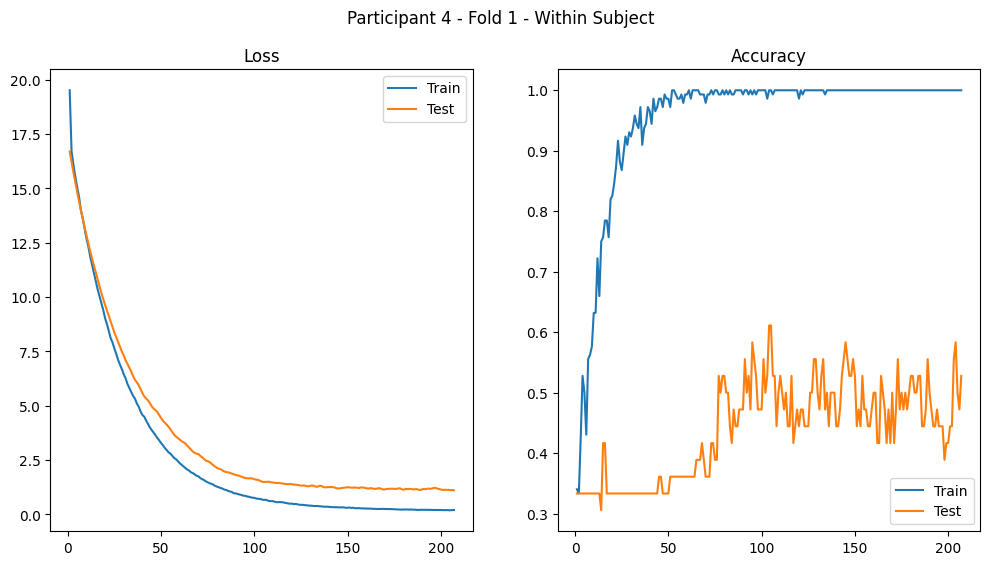

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 381ms/step - loss: 20.4573 - accuracy: 0.2778 - val_loss: 17.6872 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 89ms/step - loss: 17.6842 - accuracy: 0.3819 - val_loss: 17.1767 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 17.1139 - accuracy: 0.3542 - val_loss: 16.6809 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 16.4827 - accuracy: 0.4722 - va

<Figure size 640x480 with 0 Axes>

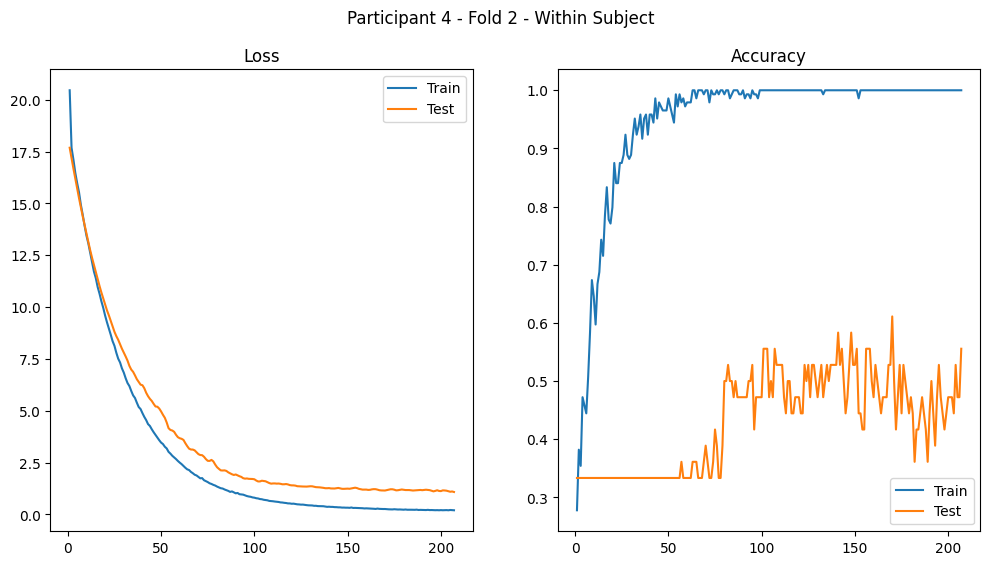

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 381ms/step - loss: 18.5435 - accuracy: 0.3056 - val_loss: 15.7901 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 15.7239 - accuracy: 0.3889 - val_loss: 15.3214 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 100ms/step - loss: 15.1771 - accuracy: 0.4306 - val_loss: 14.8718 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 14.7725 - accuracy: 0.4514 - v

<Figure size 640x480 with 0 Axes>

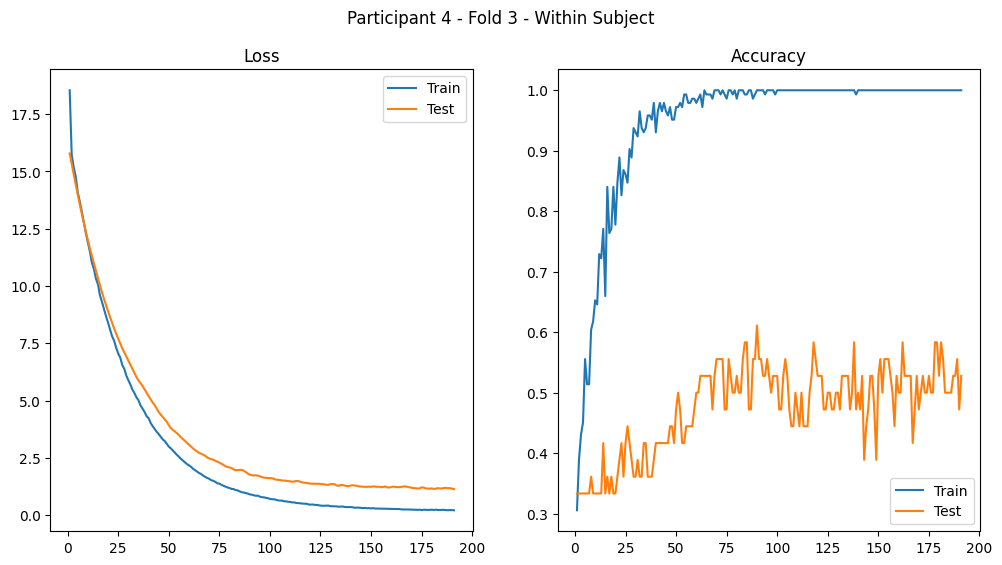

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 381ms/step - loss: 19.5221 - accuracy: 0.3403 - val_loss: 16.8464 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 100ms/step - loss: 16.7178 - accuracy: 0.4167 - val_loss: 16.3544 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 93ms/step - loss: 16.2859 - accuracy: 0.3889 - val_loss: 15.8698 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 95ms/step - loss: 15.7276 - accuracy: 0.4306 - v

<Figure size 640x480 with 0 Axes>

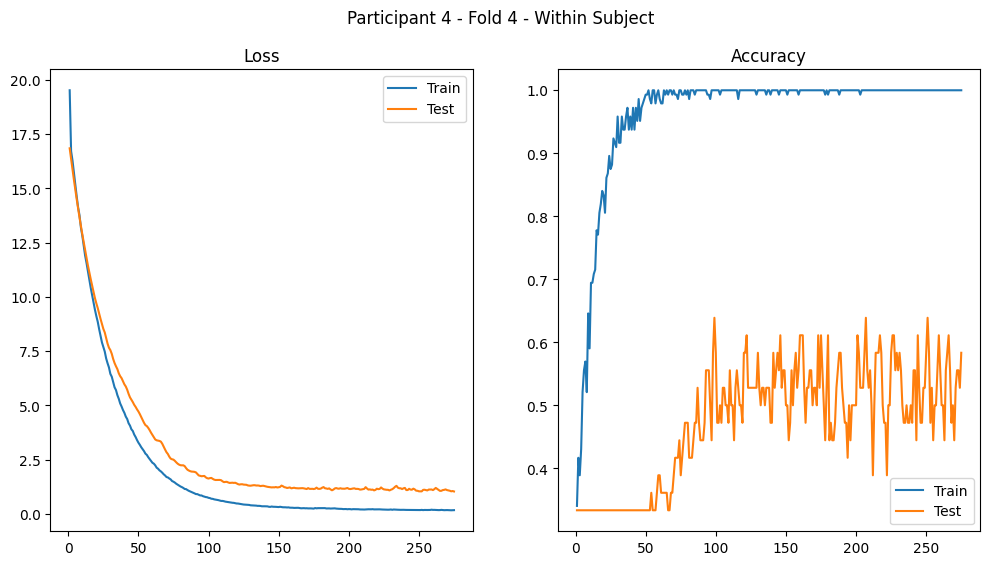

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 378ms/step - loss: 18.9285 - accuracy: 0.3264 - val_loss: 16.1113 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 98ms/step - loss: 16.0663 - accuracy: 0.4097 - val_loss: 15.6313 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 97ms/step - loss: 15.4889 - accuracy: 0.4722 - val_loss: 15.1715 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 82ms/step - loss: 14.9179 - accuracy: 0.5069 - va

<Figure size 640x480 with 0 Axes>

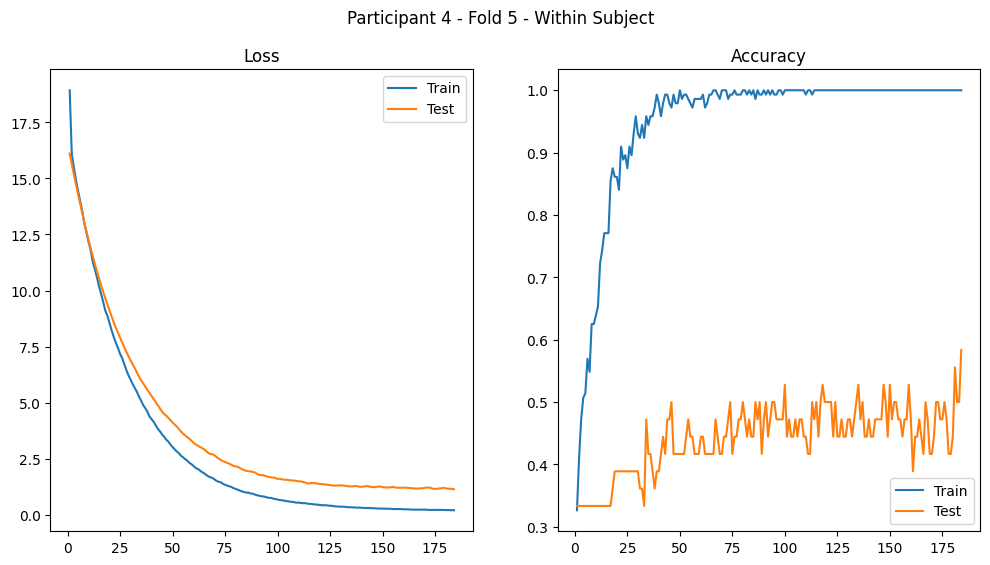

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 389ms/step - loss: 19.1961 - accuracy: 0.3681 - val_loss: 16.5444 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 97ms/step - loss: 16.3483 - accuracy: 0.3958 - val_loss: 16.0692 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 87ms/step - loss: 15.7492 - accuracy: 0.5208 - val_loss: 15.5908 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 89ms/step - loss: 15.1639 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

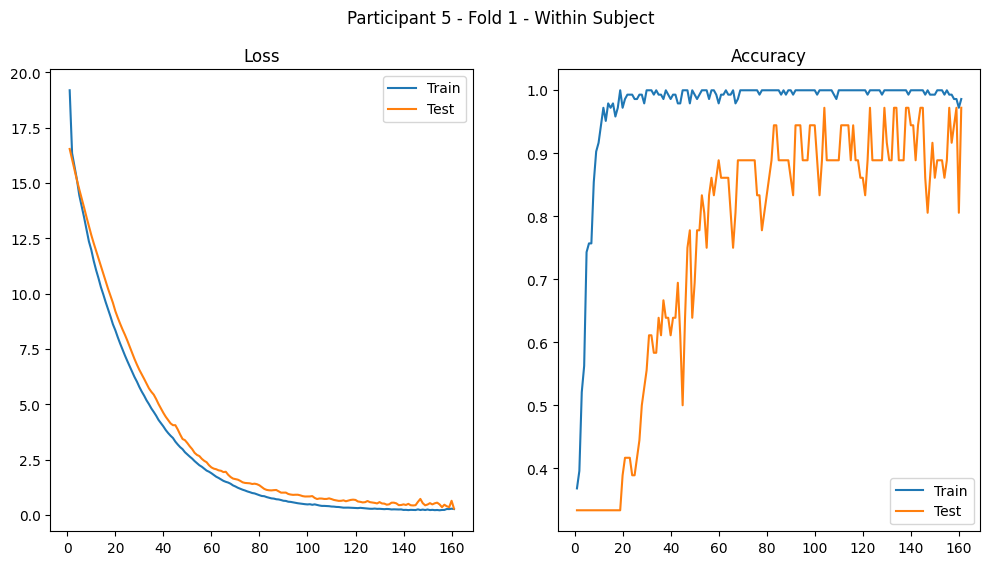

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 380ms/step - loss: 19.4352 - accuracy: 0.3125 - val_loss: 16.7376 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 100ms/step - loss: 16.4260 - accuracy: 0.5278 - val_loss: 16.2934 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 99ms/step - loss: 15.6747 - accuracy: 0.6667 - val_loss: 15.9031 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 15.1380 - accuracy: 0.6458 - v

<Figure size 640x480 with 0 Axes>

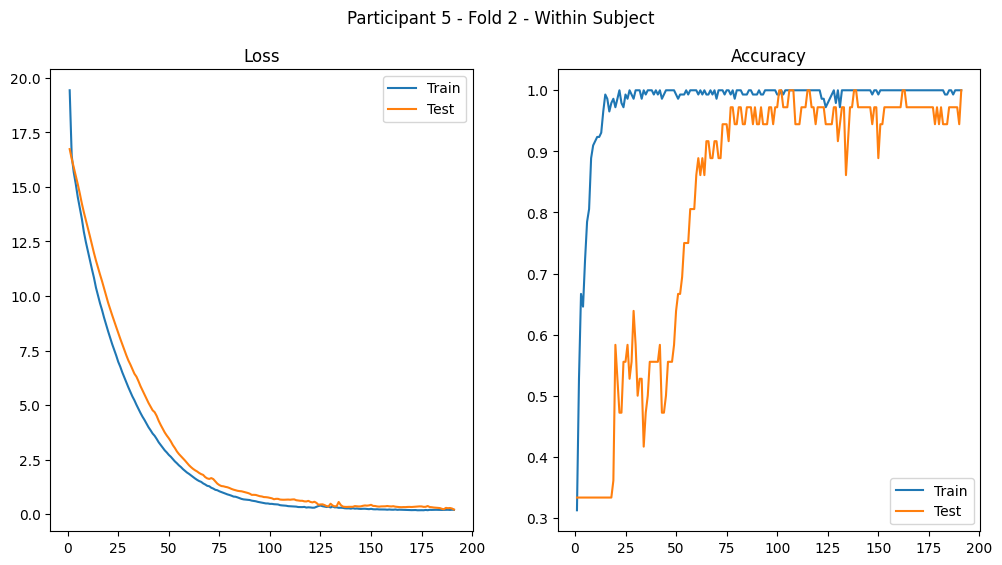

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 370ms/step - loss: 18.6613 - accuracy: 0.3681 - val_loss: 15.9193 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 70ms/step - loss: 15.6578 - accuracy: 0.5278 - val_loss: 15.4446 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 93ms/step - loss: 15.0709 - accuracy: 0.5764 - val_loss: 14.9858 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 97ms/step - loss: 14.4188 - accuracy: 0.6597 - va

<Figure size 640x480 with 0 Axes>

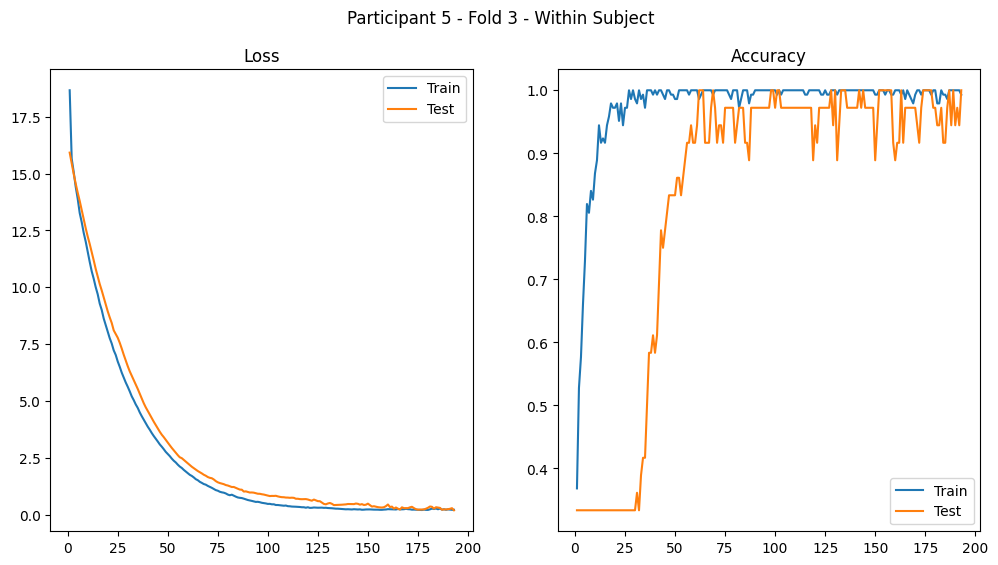

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 393ms/step - loss: 19.8890 - accuracy: 0.3681 - val_loss: 16.8234 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 95ms/step - loss: 16.8011 - accuracy: 0.3958 - val_loss: 16.3356 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 16.0507 - accuracy: 0.4653 - val_loss: 15.8678 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 85ms/step - loss: 15.3109 - accuracy: 0.6667 - va

<Figure size 640x480 with 0 Axes>

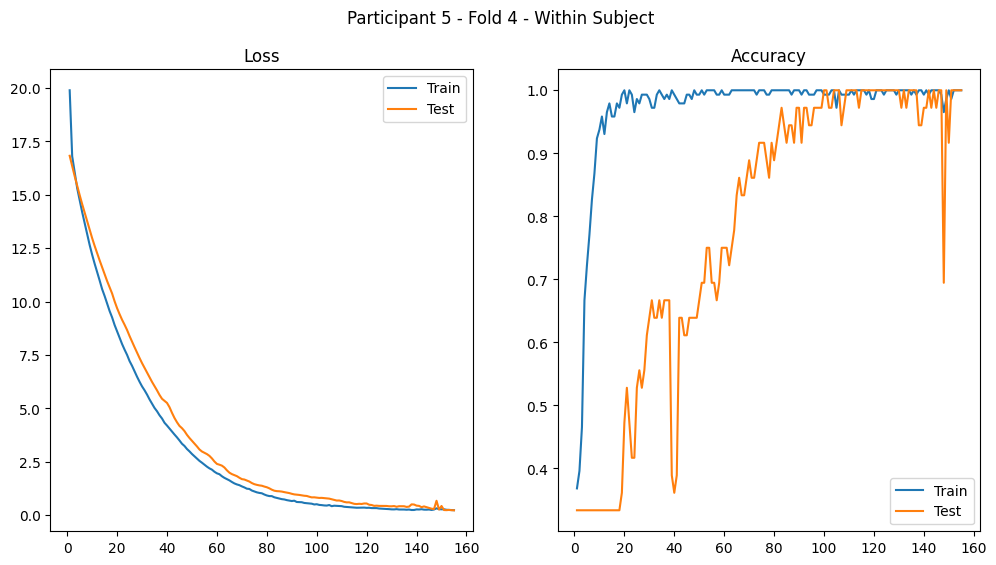

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 383ms/step - loss: 18.6179 - accuracy: 0.3681 - val_loss: 15.9545 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 81ms/step - loss: 15.7456 - accuracy: 0.5208 - val_loss: 15.4721 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 14.9325 - accuracy: 0.6667 - val_loss: 15.0091 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 98ms/step - loss: 14.3414 - accuracy: 0.7153 - va

<Figure size 640x480 with 0 Axes>

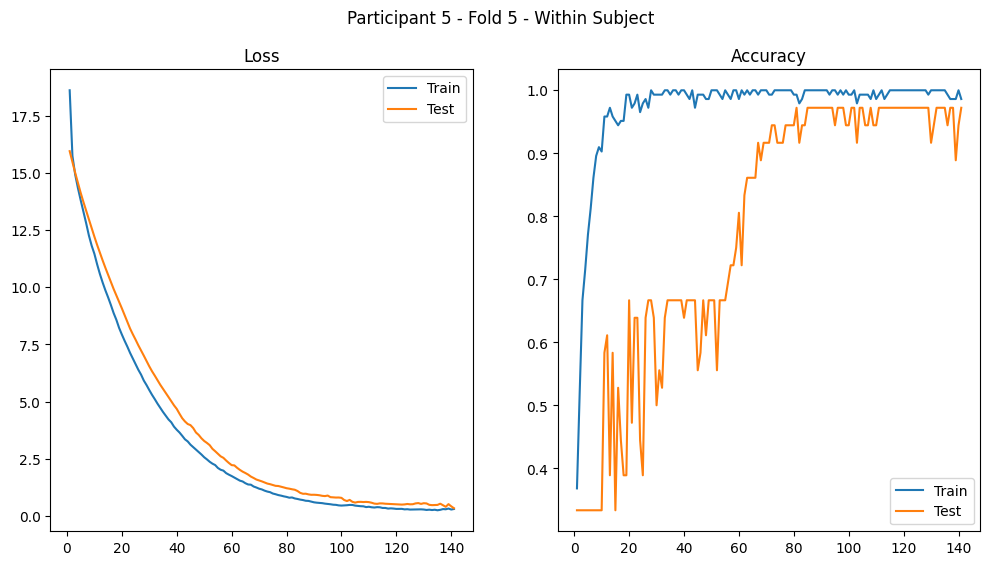

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 368ms/step - loss: 18.5601 - accuracy: 0.3403 - val_loss: 15.9442 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 15.7521 - accuracy: 0.4514 - val_loss: 15.4959 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 102ms/step - loss: 15.0273 - accuracy: 0.5764 - val_loss: 15.0901 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 89ms/step - loss: 14.3319 - accuracy: 0

<Figure size 640x480 with 0 Axes>

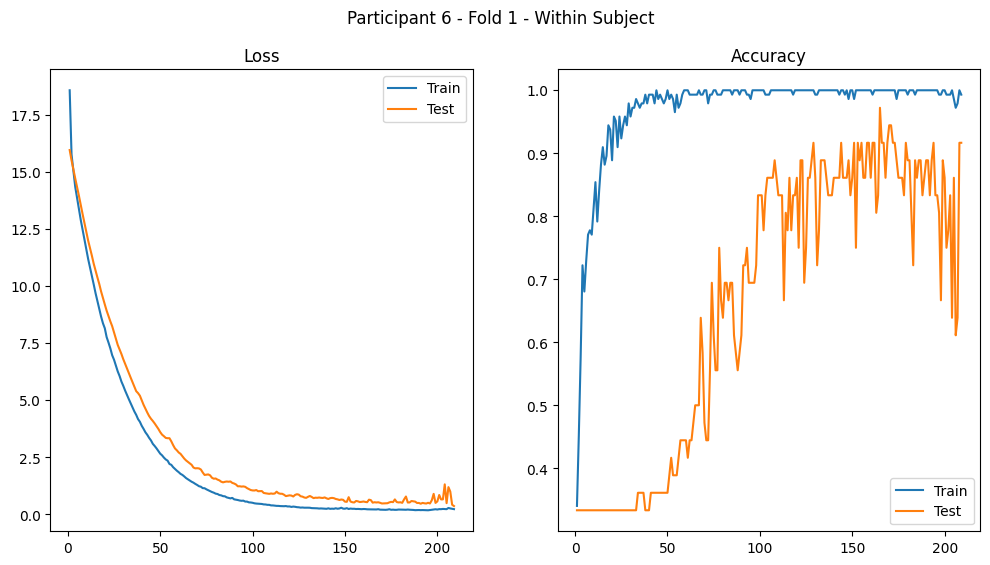

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 377ms/step - loss: 18.5023 - accuracy: 0.3542 - val_loss: 15.7385 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 83ms/step - loss: 15.5445 - accuracy: 0.4653 - val_loss: 15.2652 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 14.8293 - accuracy: 0.5972 - val_loss: 14.8092 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 96ms/step - loss: 14.2687 - accuracy: 0.6944 - va

<Figure size 640x480 with 0 Axes>

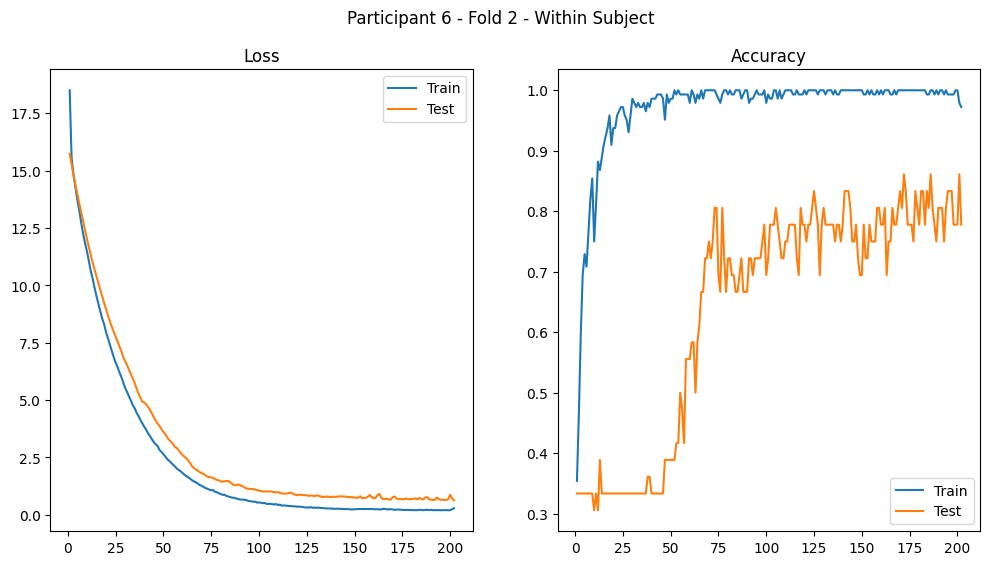

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 385ms/step - loss: 19.8819 - accuracy: 0.3611 - val_loss: 17.1585 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 98ms/step - loss: 16.8105 - accuracy: 0.5208 - val_loss: 16.7183 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 96ms/step - loss: 16.1400 - accuracy: 0.5833 - val_loss: 16.3118 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 15.4887 - accuracy: 0.7222 - va

<Figure size 640x480 with 0 Axes>

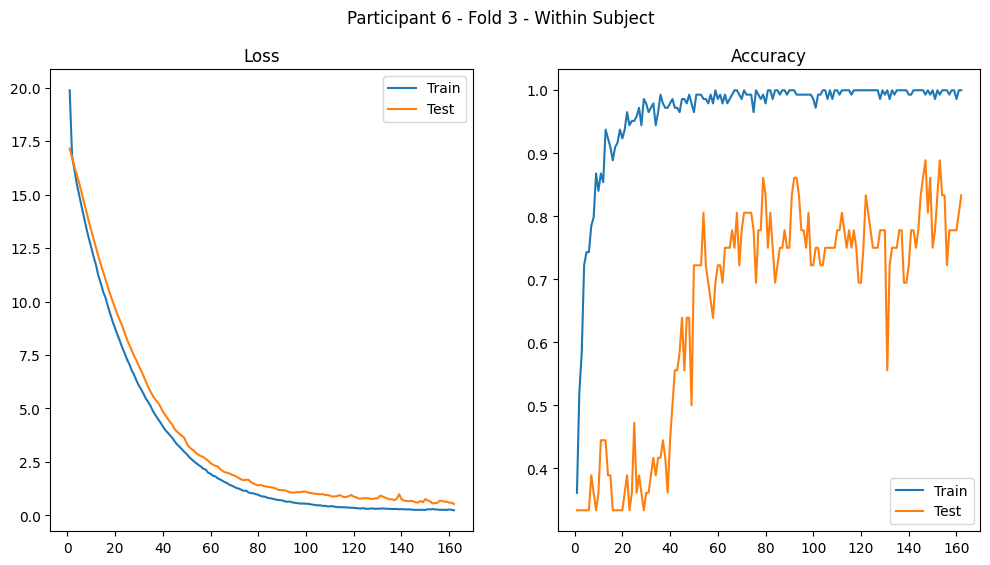

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 371ms/step - loss: 19.3792 - accuracy: 0.3264 - val_loss: 16.7205 - val_accuracy: 0.3611
Epoch 2/500
5/5 [==============================] - 0s 90ms/step - loss: 16.4748 - accuracy: 0.4861 - val_loss: 16.2141 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 15.7103 - accuracy: 0.6319 - val_loss: 15.7325 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 15.1473 - accuracy: 0.6458 - va

<Figure size 640x480 with 0 Axes>

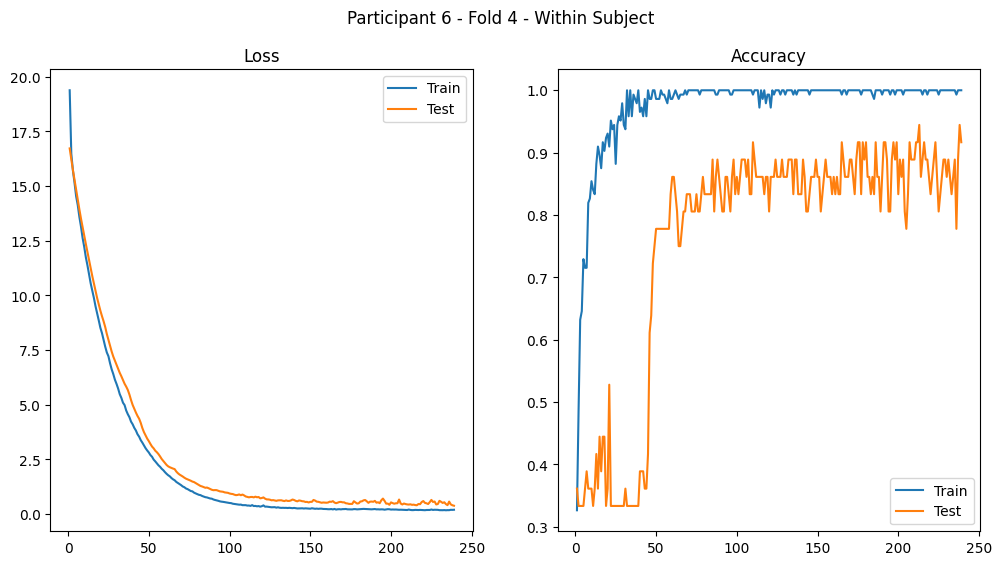

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 375ms/step - loss: 18.8488 - accuracy: 0.3264 - val_loss: 15.9965 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 98ms/step - loss: 15.8649 - accuracy: 0.4306 - val_loss: 15.5309 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 93ms/step - loss: 15.0559 - accuracy: 0.6111 - val_loss: 15.0806 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 14.5320 - accuracy: 0.6875 - va

<Figure size 640x480 with 0 Axes>

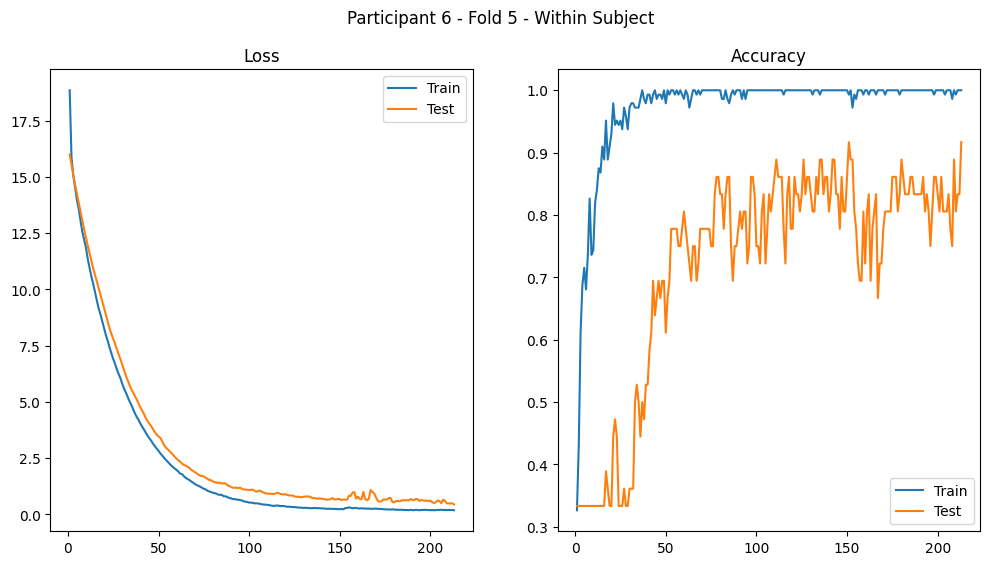

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 380ms/step - loss: 19.2163 - accuracy: 0.2847 - val_loss: 16.4066 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 87ms/step - loss: 16.3469 - accuracy: 0.3750 - val_loss: 15.9175 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 96ms/step - loss: 15.8222 - accuracy: 0.3542 - val_loss: 15.4464 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 15.2352 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

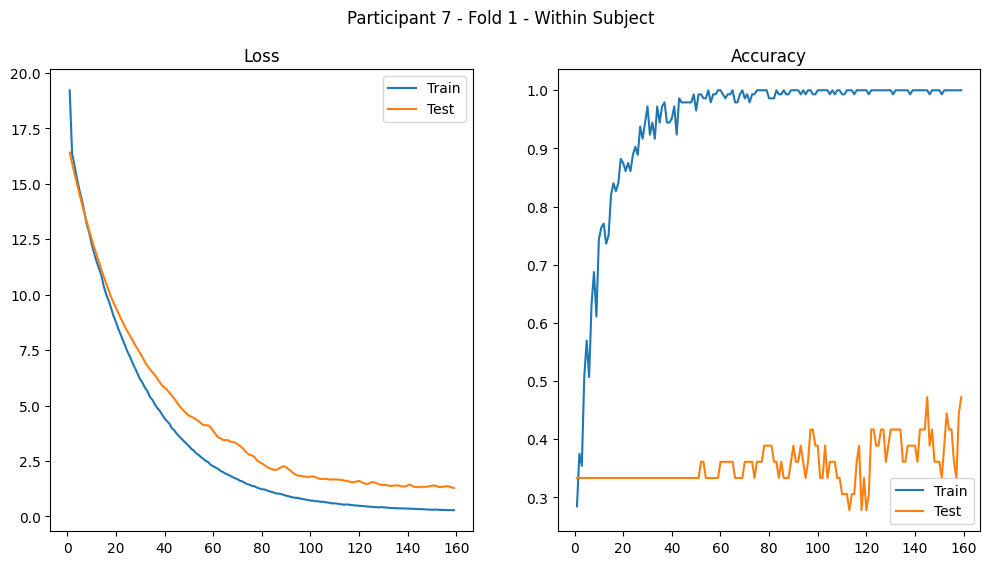

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 383ms/step - loss: 19.8830 - accuracy: 0.4028 - val_loss: 17.2554 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 17.1079 - accuracy: 0.4792 - val_loss: 16.7408 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 16.5799 - accuracy: 0.4097 - val_loss: 16.2509 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 90ms/step - loss: 16.0386 - accuracy: 0.5069 - va

<Figure size 640x480 with 0 Axes>

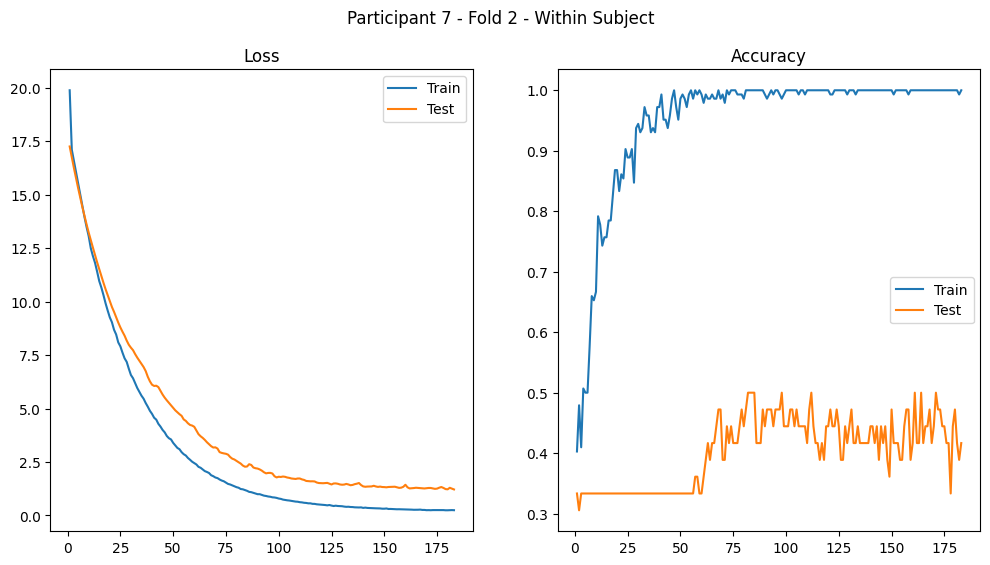

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 382ms/step - loss: 19.5997 - accuracy: 0.3194 - val_loss: 16.9163 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 87ms/step - loss: 16.7767 - accuracy: 0.3681 - val_loss: 16.4143 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 85ms/step - loss: 16.2262 - accuracy: 0.4583 - val_loss: 15.9297 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 15.6932 - accuracy: 0.5000 - va

<Figure size 640x480 with 0 Axes>

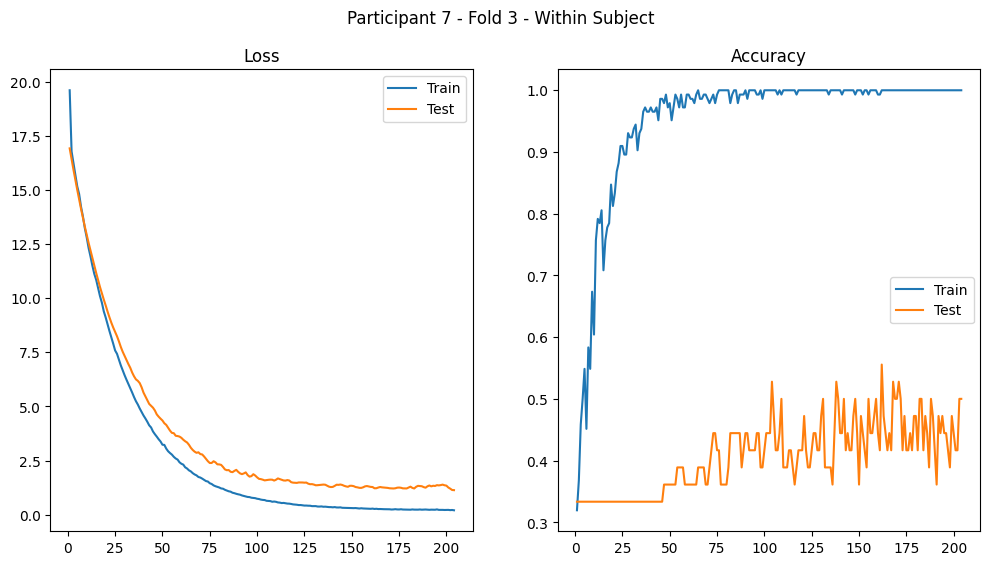

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 378ms/step - loss: 19.0326 - accuracy: 0.3819 - val_loss: 16.4084 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 88ms/step - loss: 16.2621 - accuracy: 0.4306 - val_loss: 15.9170 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 15.6786 - accuracy: 0.4861 - val_loss: 15.4409 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 15.3189 - accuracy: 0.4097 - va

<Figure size 640x480 with 0 Axes>

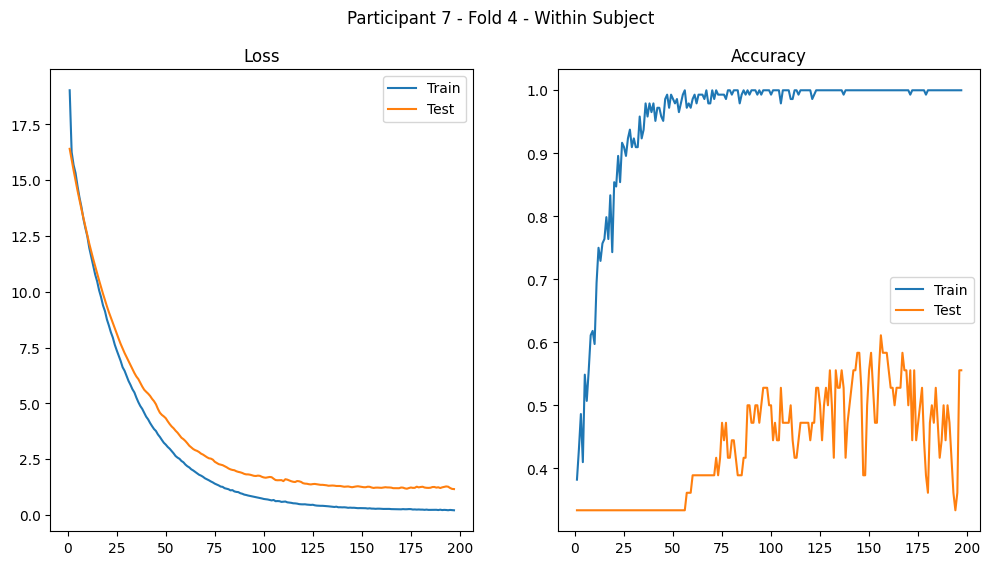

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 382ms/step - loss: 19.2403 - accuracy: 0.3125 - val_loss: 16.5060 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 97ms/step - loss: 16.3800 - accuracy: 0.4167 - val_loss: 16.0073 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 15.9180 - accuracy: 0.3681 - val_loss: 15.5262 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 98ms/step - loss: 15.3439 - accuracy: 0.4722 - va

<Figure size 640x480 with 0 Axes>

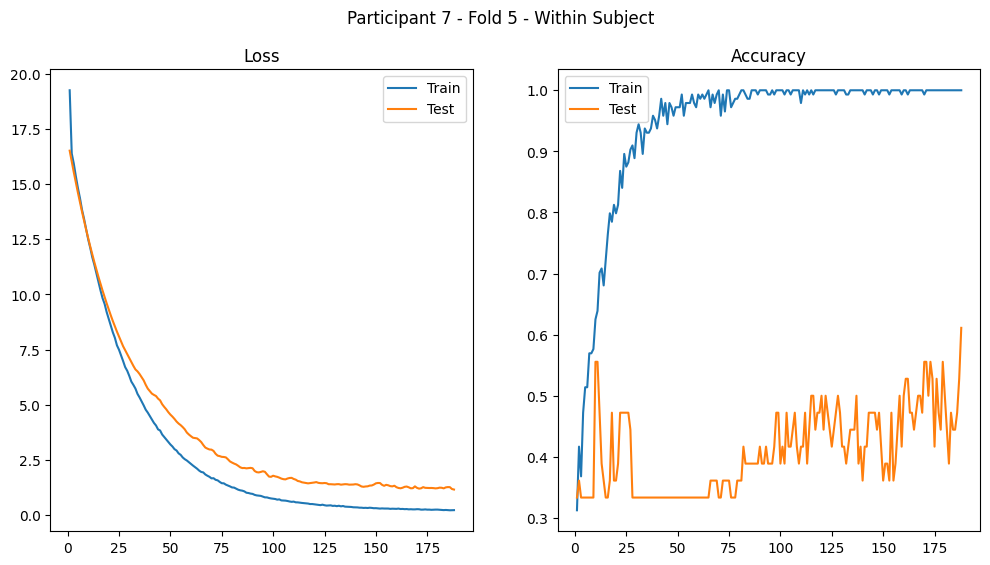

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 386ms/step - loss: 19.9708 - accuracy: 0.3403 - val_loss: 17.2410 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 17.0471 - accuracy: 0.4514 - val_loss: 16.7382 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 16.4306 - accuracy: 0.5278 - val_loss: 16.2463 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 89ms/step - loss: 15.7682 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

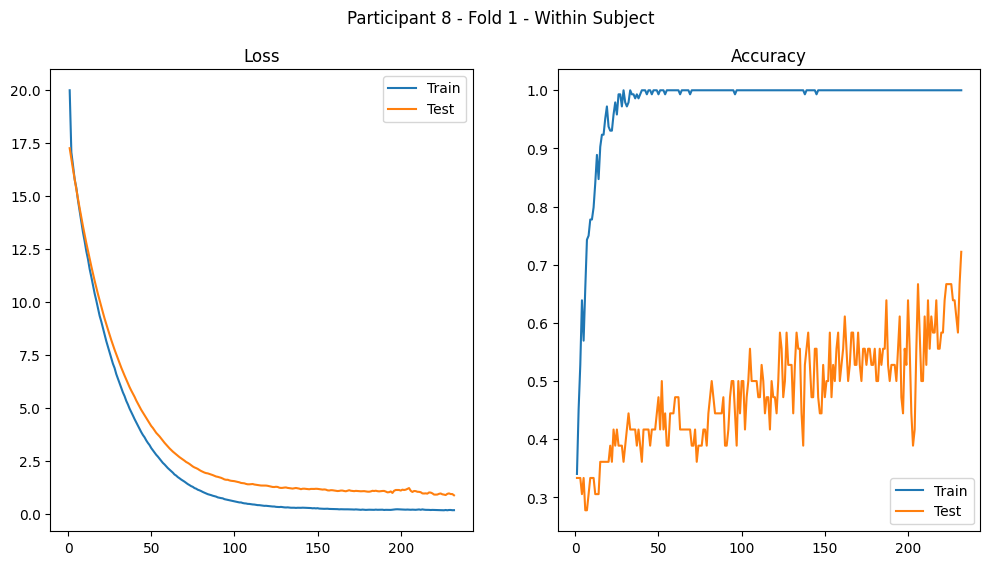

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 377ms/step - loss: 19.2392 - accuracy: 0.4097 - val_loss: 16.4575 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 95ms/step - loss: 16.3673 - accuracy: 0.3889 - val_loss: 15.9679 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 87ms/step - loss: 15.6885 - accuracy: 0.4514 - val_loss: 15.4947 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 86ms/step - loss: 15.1908 - accuracy: 0.5556 - va

<Figure size 640x480 with 0 Axes>

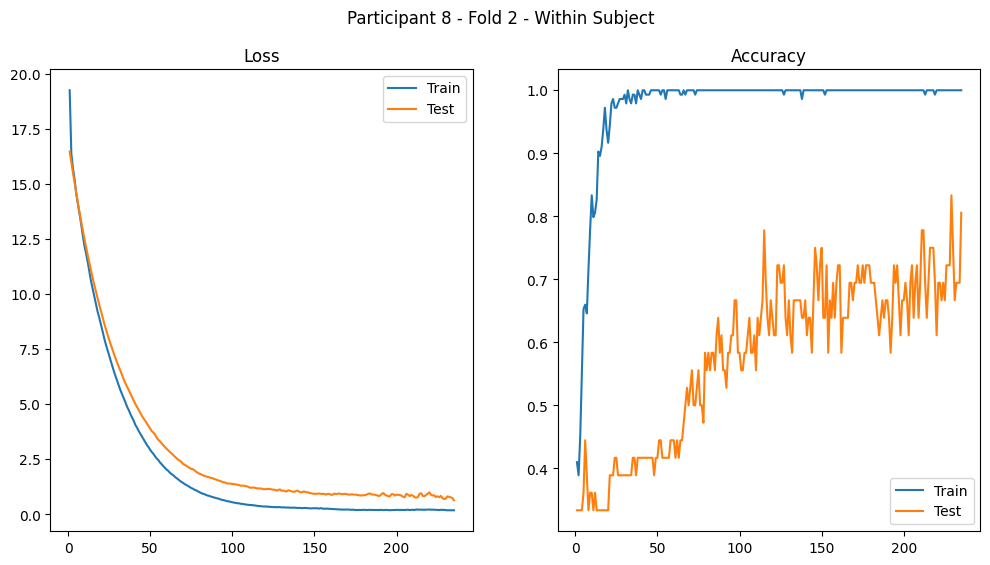

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 395ms/step - loss: 19.0362 - accuracy: 0.3264 - val_loss: 16.2926 - val_accuracy: 0.3056
Epoch 2/500
5/5 [==============================] - 0s 97ms/step - loss: 16.0785 - accuracy: 0.4306 - val_loss: 15.7928 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 15.4732 - accuracy: 0.5486 - val_loss: 15.3105 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 92ms/step - loss: 14.9653 - accuracy: 0.5417 - va

<Figure size 640x480 with 0 Axes>

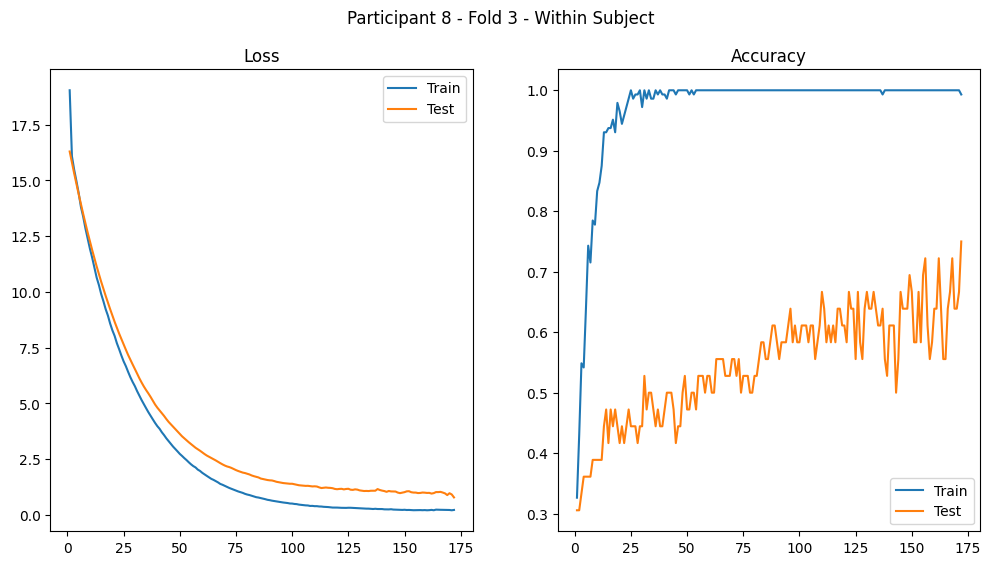

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 395ms/step - loss: 18.6458 - accuracy: 0.3889 - val_loss: 16.0518 - val_accuracy: 0.1111
Epoch 2/500
5/5 [==============================] - 0s 88ms/step - loss: 15.8270 - accuracy: 0.4722 - val_loss: 15.5715 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 80ms/step - loss: 15.2301 - accuracy: 0.5347 - val_loss: 15.1023 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 78ms/step - loss: 14.6621 - accuracy: 0.6597 - va

<Figure size 640x480 with 0 Axes>

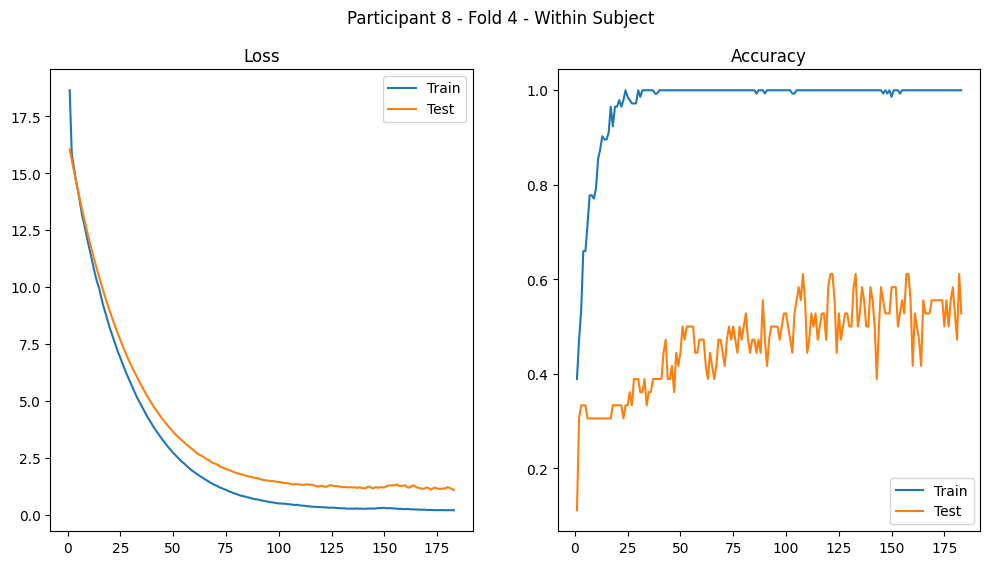

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 396ms/step - loss: 19.4139 - accuracy: 0.3333 - val_loss: 16.5870 - val_accuracy: 0.3889
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 16.4240 - accuracy: 0.4792 - val_loss: 16.0912 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 85ms/step - loss: 15.8207 - accuracy: 0.4861 - val_loss: 15.6067 - val_accuracy: 0.3889
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 15.1782 - accuracy: 0.6111 - va

<Figure size 640x480 with 0 Axes>

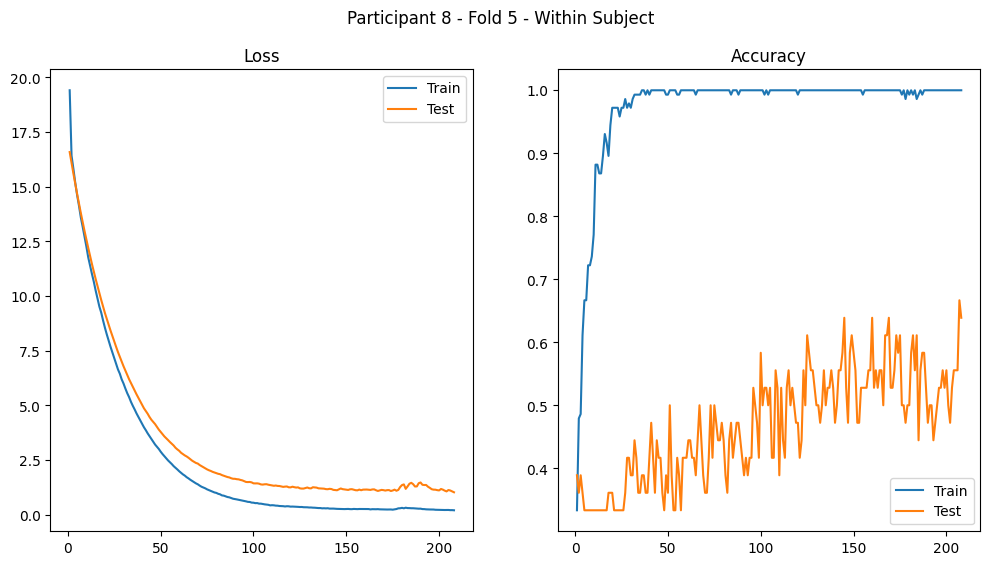

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 374ms/step - loss: 18.6660 - accuracy: 0.4306 - val_loss: 16.0926 - val_accuracy: 0.3056
Epoch 2/500
5/5 [==============================] - 0s 83ms/step - loss: 15.8467 - accuracy: 0.5000 - val_loss: 15.6125 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 15.3099 - accuracy: 0.5556 - val_loss: 15.1441 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 93ms/step - loss: 14.6533 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

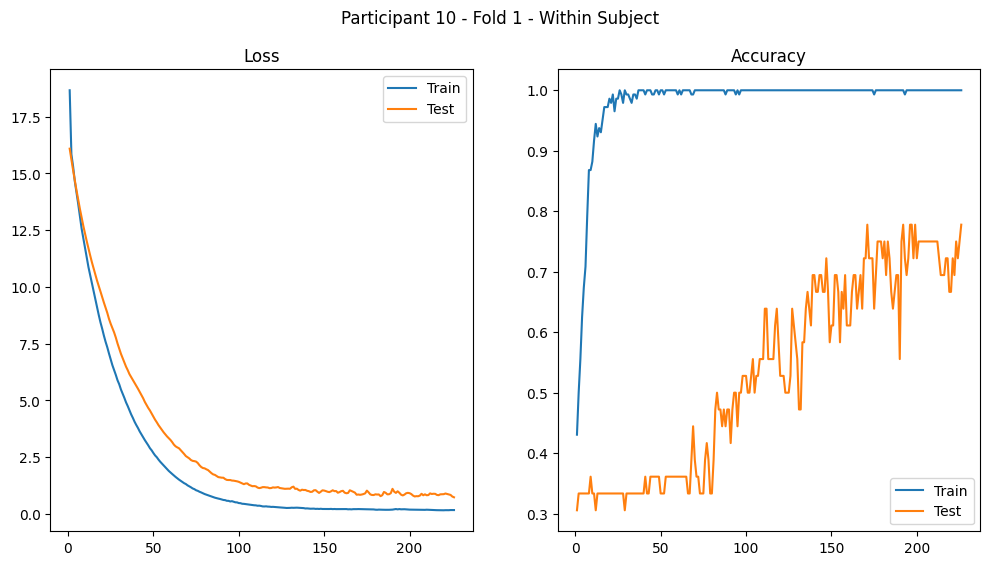

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 393ms/step - loss: 18.6048 - accuracy: 0.3403 - val_loss: 15.8448 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 15.6042 - accuracy: 0.5417 - val_loss: 15.3794 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 15.1209 - accuracy: 0.5278 - val_loss: 14.9260 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 90ms/step - loss: 14.4716 - accuracy: 0.6250 - va

<Figure size 640x480 with 0 Axes>

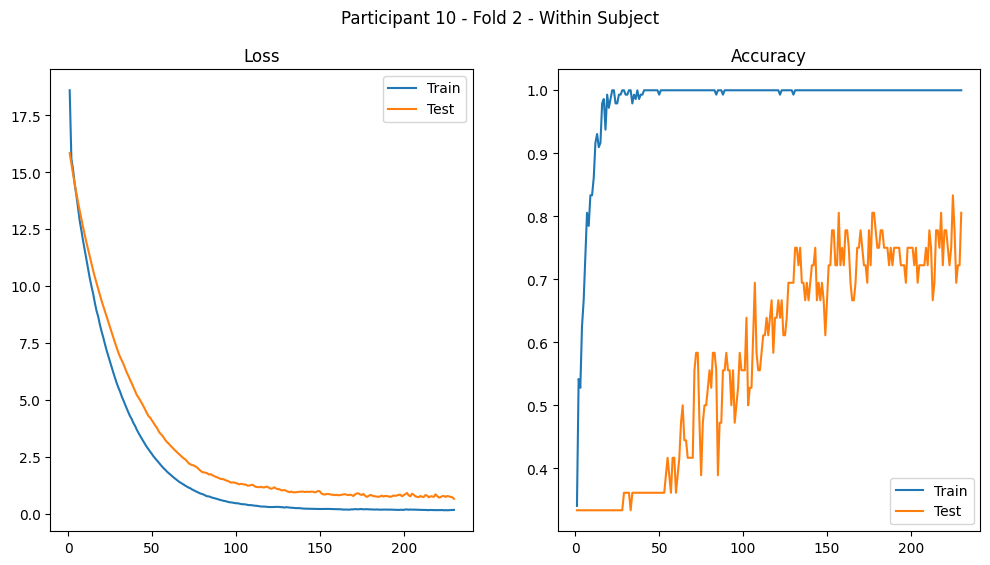

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 386ms/step - loss: 18.2042 - accuracy: 0.3125 - val_loss: 15.4587 - val_accuracy: 0.4167
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 15.3025 - accuracy: 0.4028 - val_loss: 14.9859 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 14.6809 - accuracy: 0.5208 - val_loss: 14.5313 - val_accuracy: 0.3056
Epoch 4/500
5/5 [==============================] - 0s 99ms/step - loss: 14.1258 - accuracy: 0.5833 - va

<Figure size 640x480 with 0 Axes>

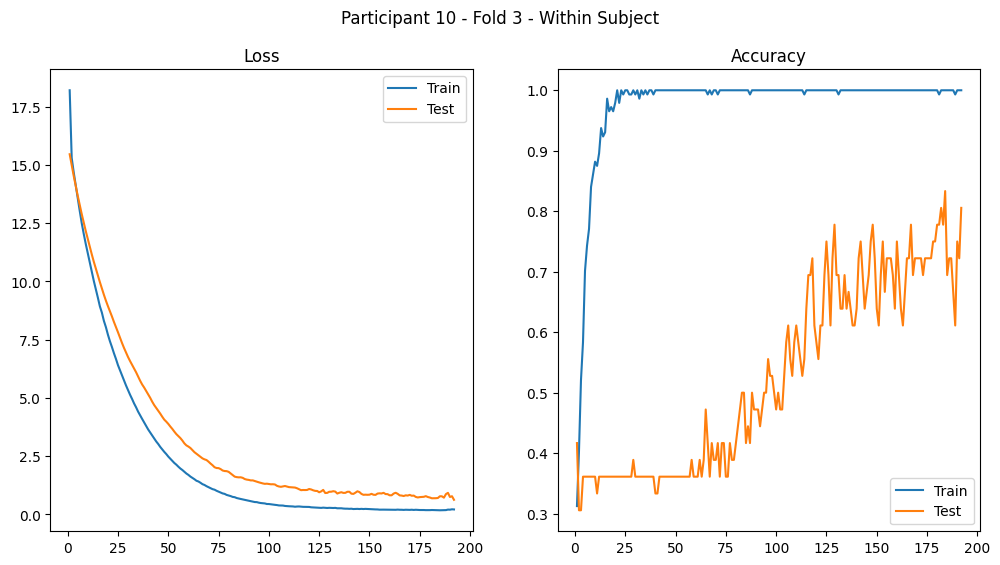

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 392ms/step - loss: 18.8227 - accuracy: 0.2986 - val_loss: 16.1634 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 15.8197 - accuracy: 0.5417 - val_loss: 15.6803 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 97ms/step - loss: 15.2739 - accuracy: 0.5903 - val_loss: 15.2170 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 95ms/step - loss: 14.7048 - accuracy: 0.6736 - va

<Figure size 640x480 with 0 Axes>

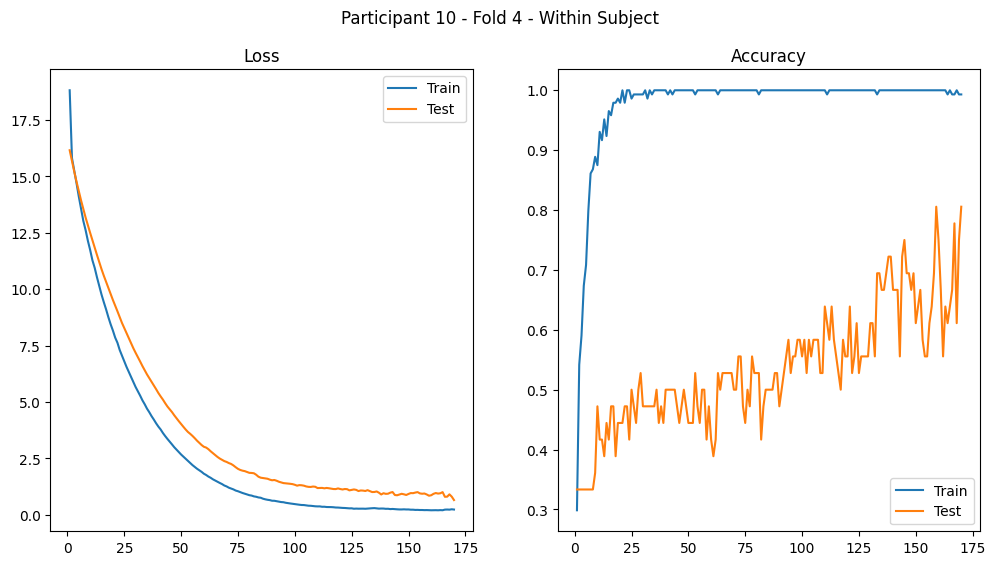

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 384ms/step - loss: 19.8819 - accuracy: 0.3194 - val_loss: 17.1296 - val_accuracy: 0.3611
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 17.0532 - accuracy: 0.4583 - val_loss: 16.6233 - val_accuracy: 0.4167
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 16.2901 - accuracy: 0.5417 - val_loss: 16.1331 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 98ms/step - loss: 15.7547 - accuracy: 0.5833 - va

<Figure size 640x480 with 0 Axes>

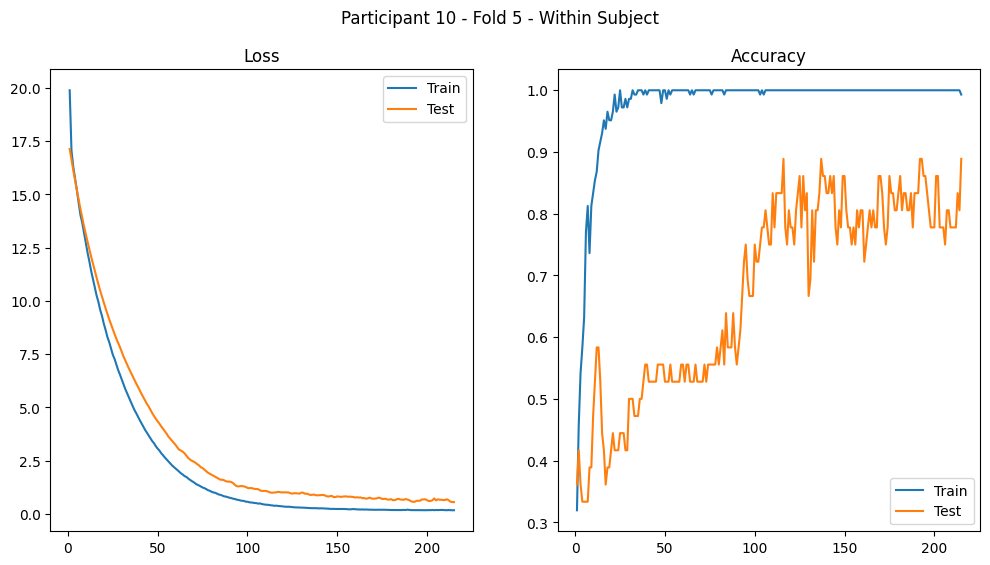

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 392ms/step - loss: 19.6508 - accuracy: 0.3819 - val_loss: 16.9473 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 16.8556 - accuracy: 0.4514 - val_loss: 16.4485 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 16.2952 - accuracy: 0.4514 - val_loss: 15.9641 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 87ms/step - loss: 15.7221 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

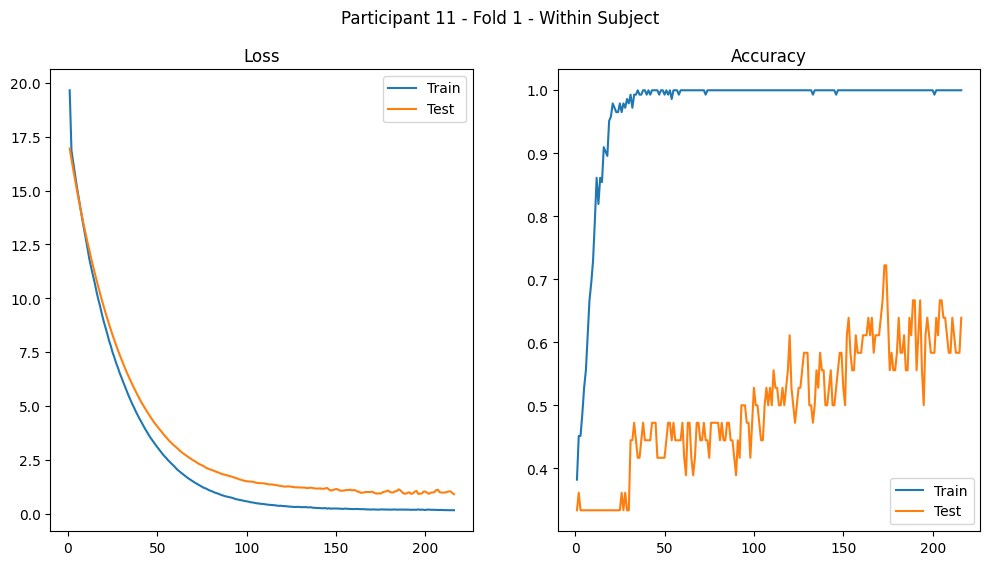

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 582ms/step - loss: 18.9270 - accuracy: 0.3542 - val_loss: 16.1264 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 1s 105ms/step - loss: 16.0716 - accuracy: 0.3542 - val_loss: 15.6488 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: 15.4677 - accuracy: 0.4028 - val_loss: 15.1786 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 14.9187 - accuracy: 0.5347 - v

<Figure size 640x480 with 0 Axes>

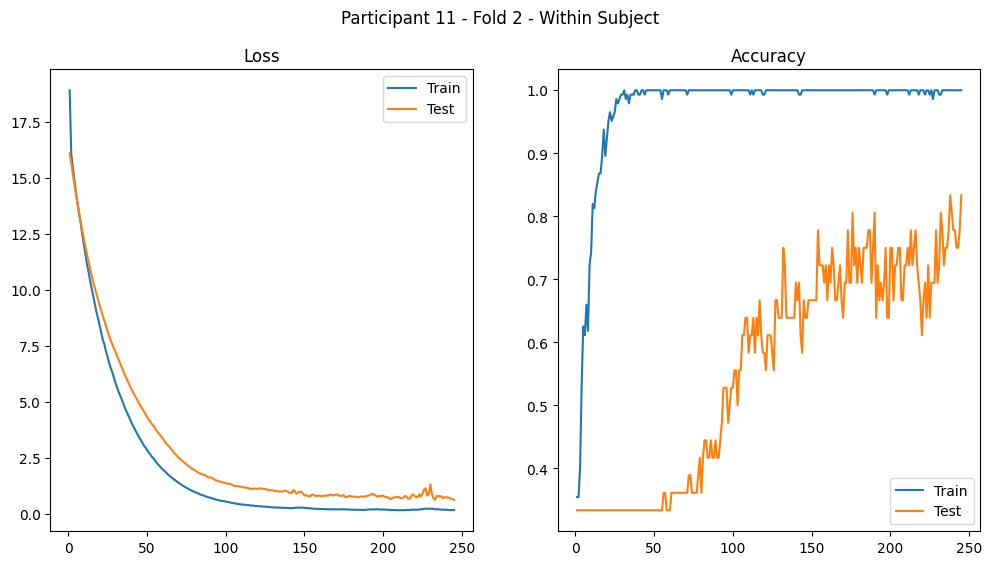

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 582ms/step - loss: 18.3442 - accuracy: 0.3194 - val_loss: 15.6668 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 1s 106ms/step - loss: 15.5638 - accuracy: 0.4028 - val_loss: 15.1913 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 15.0275 - accuracy: 0.4514 - val_loss: 14.7262 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 14.4790 - accuracy: 0.4861 - v

<Figure size 640x480 with 0 Axes>

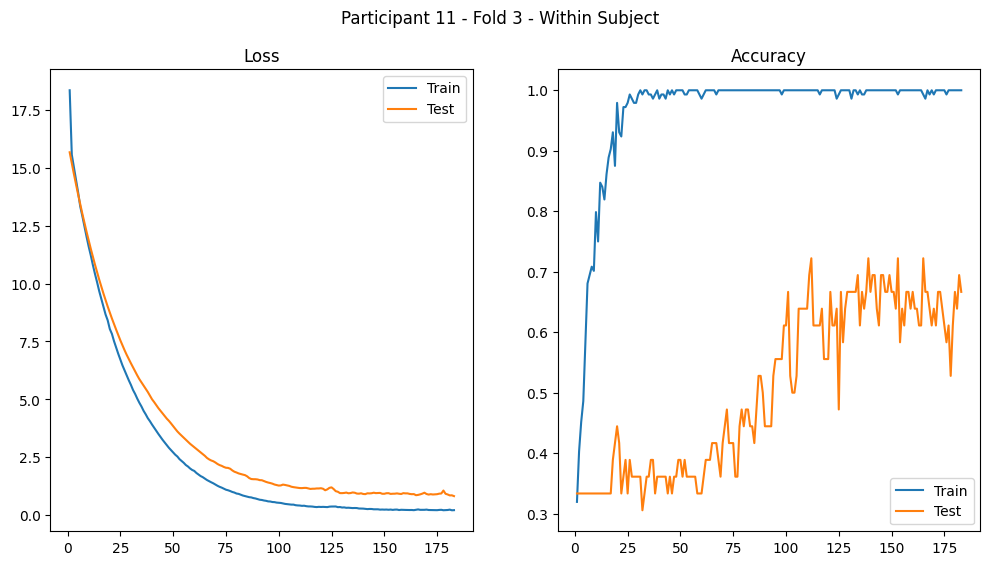

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 372ms/step - loss: 18.9008 - accuracy: 0.3819 - val_loss: 16.1802 - val_accuracy: 0.3056
Epoch 2/500
5/5 [==============================] - 0s 95ms/step - loss: 16.0417 - accuracy: 0.4444 - val_loss: 15.7024 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 90ms/step - loss: 15.4270 - accuracy: 0.5139 - val_loss: 15.2319 - val_accuracy: 0.3056
Epoch 4/500
5/5 [==============================] - 0s 85ms/step - loss: 14.9151 - accuracy: 0.4653 - va

<Figure size 640x480 with 0 Axes>

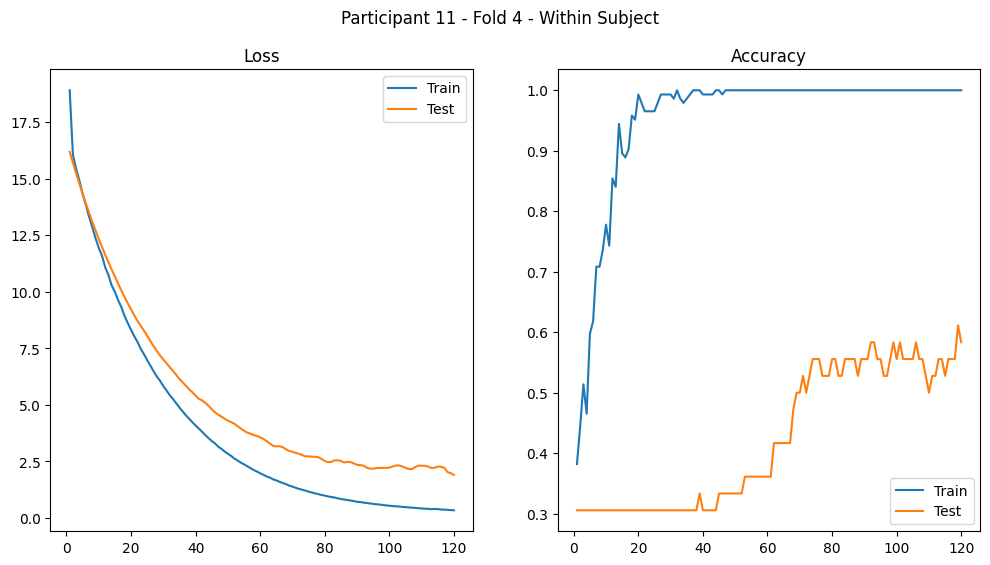

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 380ms/step - loss: 18.8007 - accuracy: 0.3333 - val_loss: 16.1654 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 16.0990 - accuracy: 0.3750 - val_loss: 15.6721 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 86ms/step - loss: 15.4101 - accuracy: 0.4792 - val_loss: 15.1901 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 96ms/step - loss: 14.8431 - accuracy: 0.5486 - va

<Figure size 640x480 with 0 Axes>

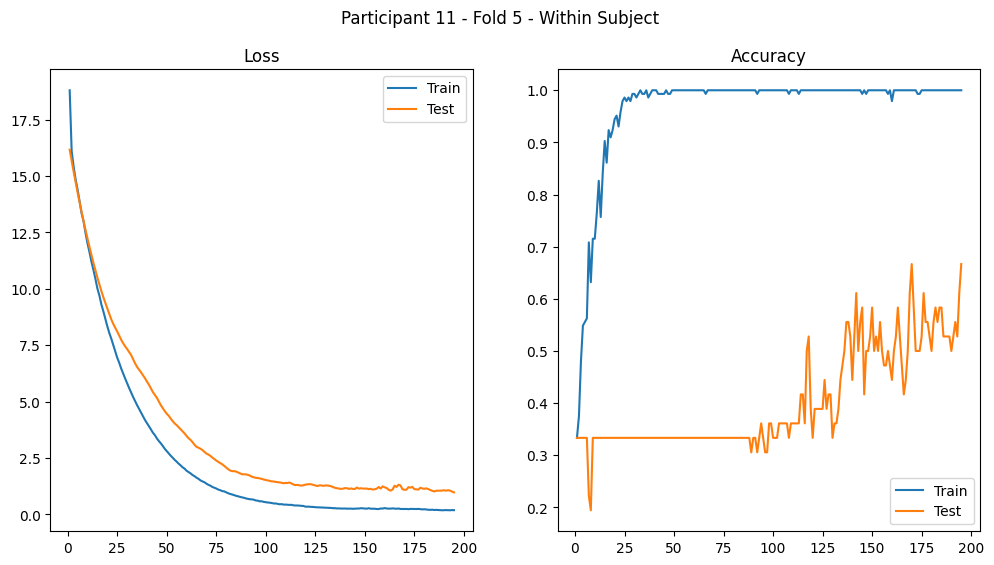

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 382ms/step - loss: 19.0313 - accuracy: 0.3194 - val_loss: 16.2282 - val_accuracy: 0.1667
Epoch 2/500
5/5 [==============================] - 0s 90ms/step - loss: 16.0353 - accuracy: 0.4306 - val_loss: 15.7493 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 15.5000 - accuracy: 0.5000 - val_loss: 15.2822 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 87ms/step - loss: 14.9085 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

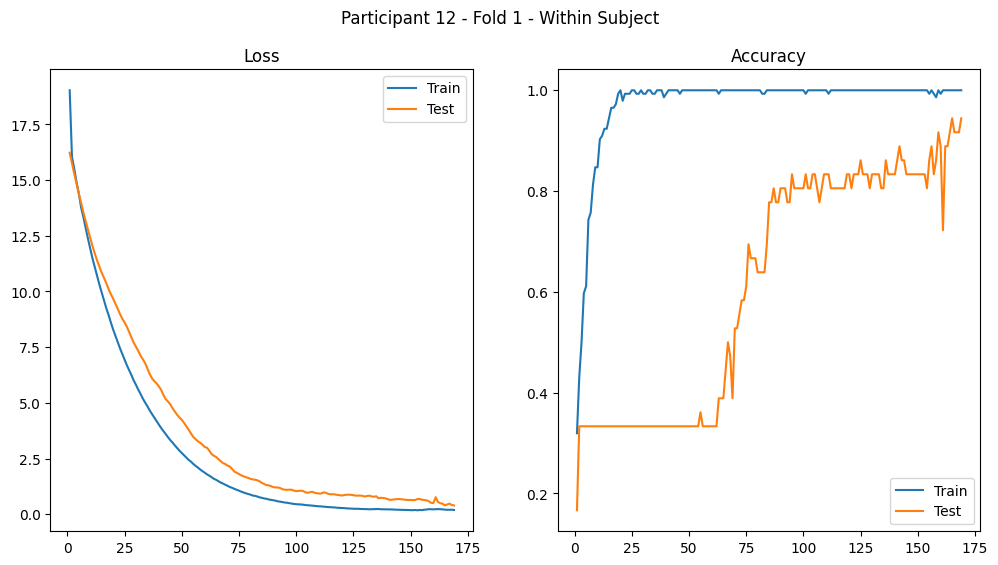

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 382ms/step - loss: 18.8458 - accuracy: 0.2986 - val_loss: 15.9346 - val_accuracy: 0.2778
Epoch 2/500
5/5 [==============================] - 0s 92ms/step - loss: 15.7575 - accuracy: 0.4444 - val_loss: 15.4571 - val_accuracy: 0.3889
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 15.2128 - accuracy: 0.4375 - val_loss: 14.9929 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 93ms/step - loss: 14.5290 - accuracy: 0.5972 - va

<Figure size 640x480 with 0 Axes>

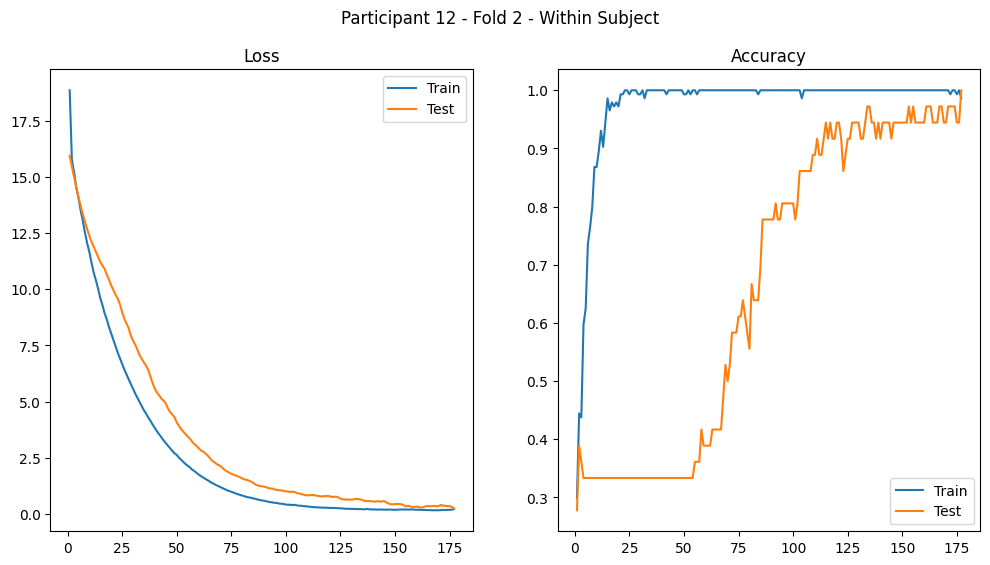

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 394ms/step - loss: 19.5269 - accuracy: 0.3542 - val_loss: 16.8776 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 16.7088 - accuracy: 0.4236 - val_loss: 16.3805 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 16.0921 - accuracy: 0.5486 - val_loss: 15.9027 - val_accuracy: 0.3889
Epoch 4/500
5/5 [==============================] - 0s 87ms/step - loss: 15.5237 - accuracy: 0.5972 - va

<Figure size 640x480 with 0 Axes>

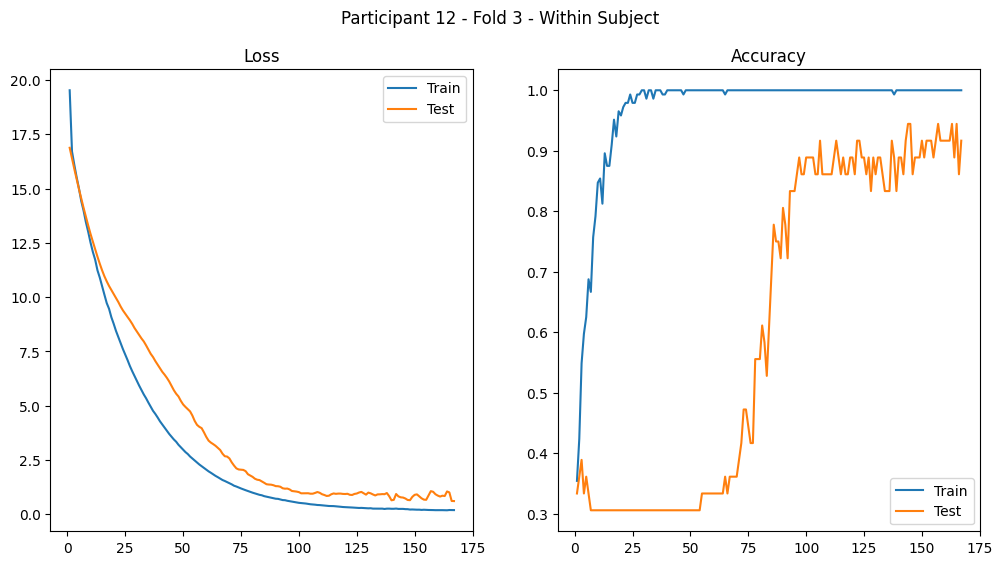

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 383ms/step - loss: 19.4137 - accuracy: 0.3264 - val_loss: 16.6321 - val_accuracy: 0.3889
Epoch 2/500
5/5 [==============================] - 0s 104ms/step - loss: 16.5170 - accuracy: 0.4167 - val_loss: 16.1283 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 96ms/step - loss: 15.8982 - accuracy: 0.4722 - val_loss: 15.6358 - val_accuracy: 0.3056
Epoch 4/500
5/5 [==============================] - 0s 82ms/step - loss: 15.3269 - accuracy: 0.5625 - v

<Figure size 640x480 with 0 Axes>

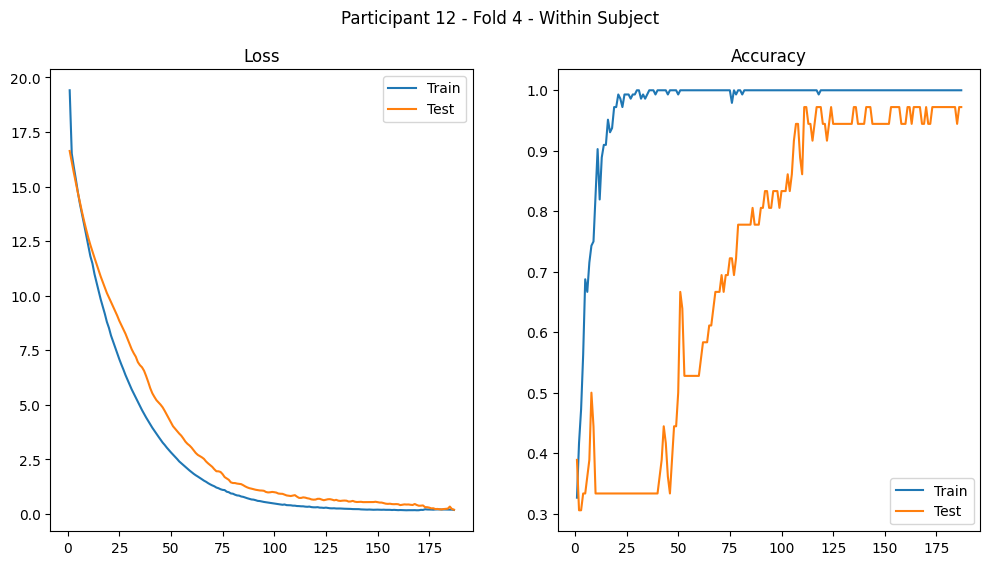

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 383ms/step - loss: 20.0277 - accuracy: 0.3125 - val_loss: 17.1974 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 17.0672 - accuracy: 0.4583 - val_loss: 16.6841 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 16.3616 - accuracy: 0.5486 - val_loss: 16.1887 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 77ms/step - loss: 15.8308 - accuracy: 0.6111 - va

<Figure size 640x480 with 0 Axes>

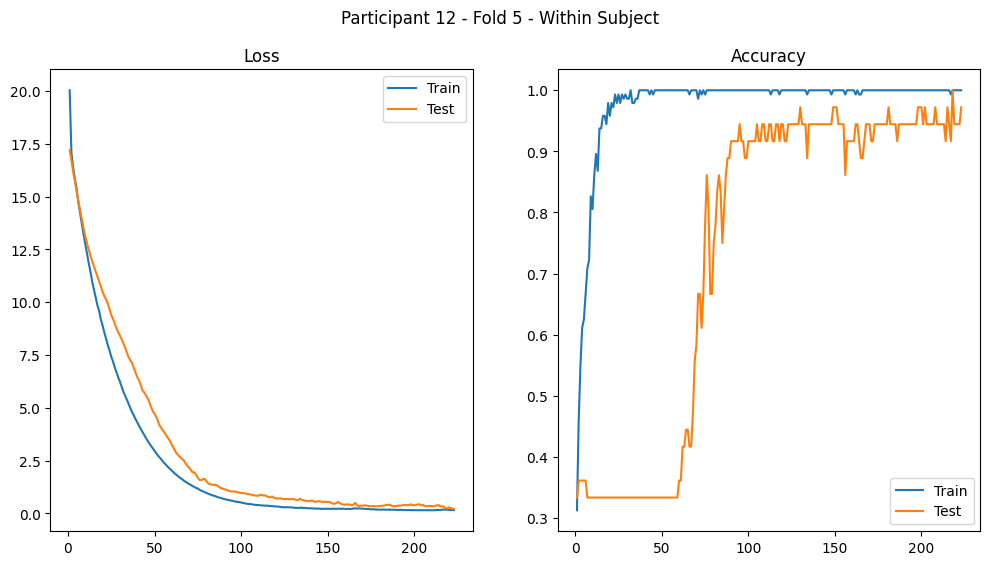

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 381ms/step - loss: 19.2320 - accuracy: 0.3542 - val_loss: 16.3849 - val_accuracy: 0.3611
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 16.2600 - accuracy: 0.4375 - val_loss: 15.9069 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 95ms/step - loss: 15.6013 - accuracy: 0.5208 - val_loss: 15.4404 - val_accuracy: 0.4167
Epoch 4/500
5/5 [==============================] - 0s 94ms/step - loss: 14.9225 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

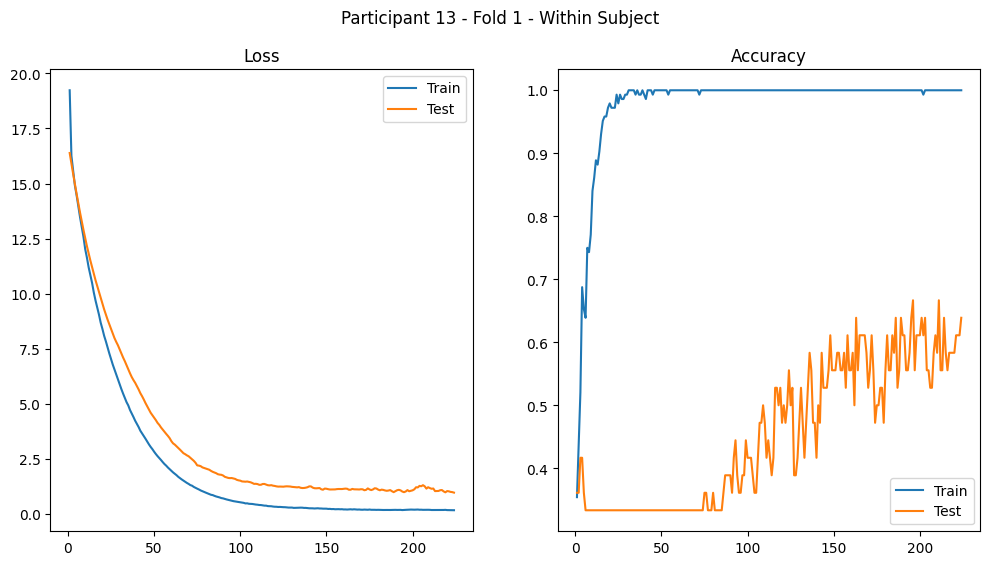

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 377ms/step - loss: 18.9463 - accuracy: 0.3125 - val_loss: 16.2537 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 16.0704 - accuracy: 0.4722 - val_loss: 15.7618 - val_accuracy: 0.3889
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 15.5023 - accuracy: 0.4931 - val_loss: 15.2811 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 95ms/step - loss: 14.8528 - accuracy: 0.6042 - va

<Figure size 640x480 with 0 Axes>

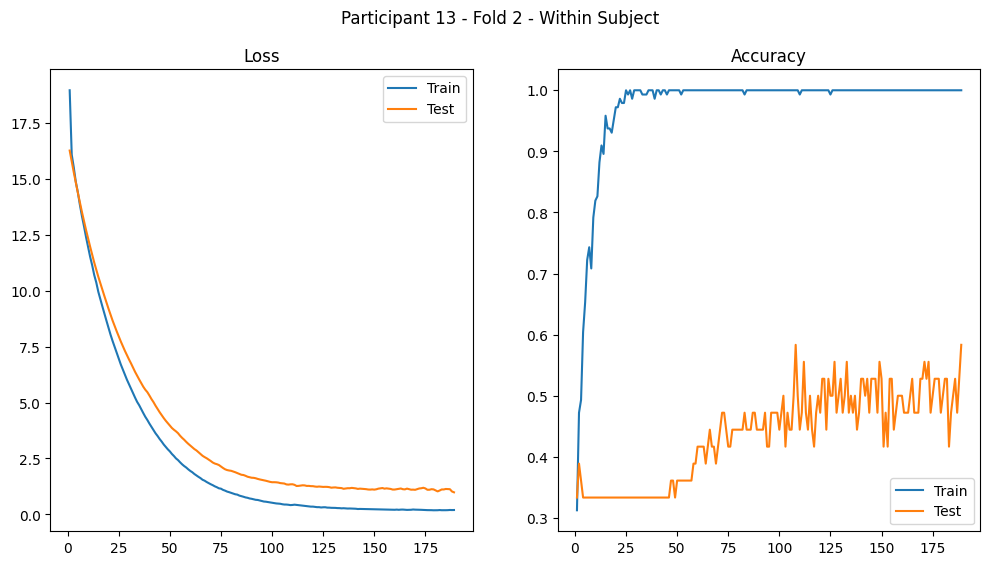

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 391ms/step - loss: 19.0890 - accuracy: 0.4236 - val_loss: 16.4352 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 102ms/step - loss: 16.2667 - accuracy: 0.5069 - val_loss: 15.9329 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 15.5710 - accuracy: 0.5417 - val_loss: 15.4452 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 92ms/step - loss: 15.0197 - accuracy: 0.6458 - v

<Figure size 640x480 with 0 Axes>

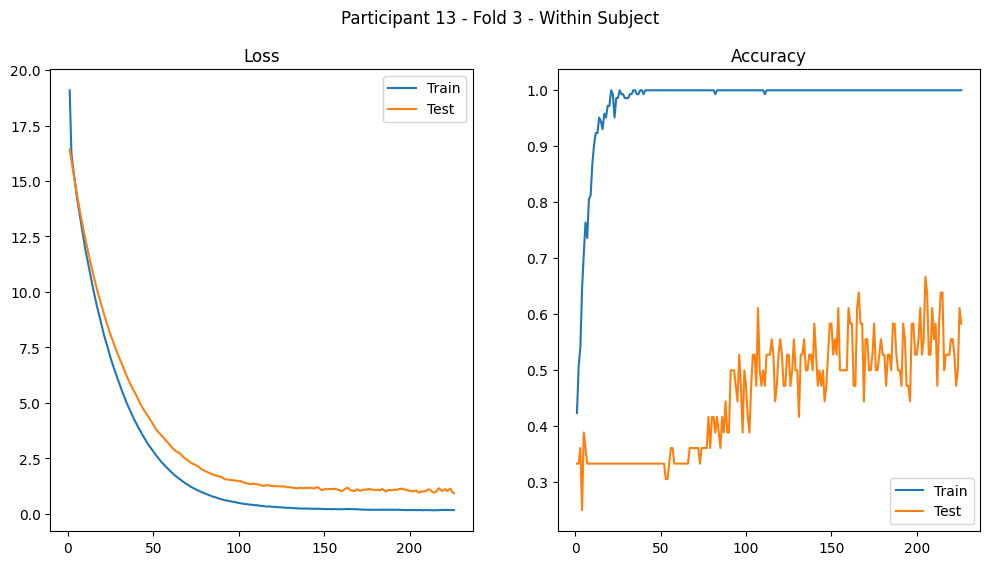

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 387ms/step - loss: 18.9765 - accuracy: 0.3264 - val_loss: 16.2493 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 16.0356 - accuracy: 0.4722 - val_loss: 15.7544 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 15.4772 - accuracy: 0.5556 - val_loss: 15.2764 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 97ms/step - loss: 14.8994 - accuracy: 0.5972 - va

<Figure size 640x480 with 0 Axes>

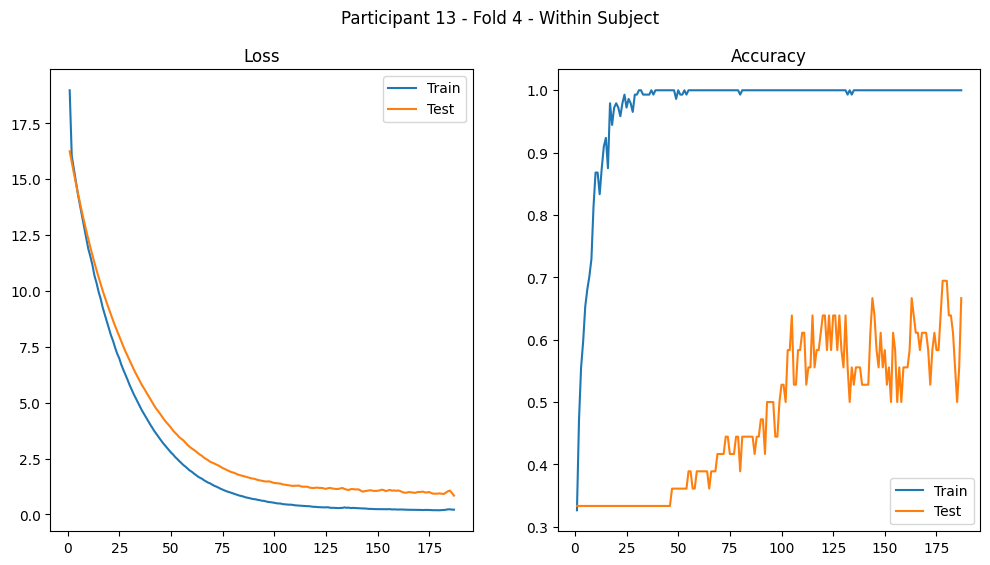

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 381ms/step - loss: 18.7866 - accuracy: 0.3611 - val_loss: 16.0571 - val_accuracy: 0.4167
Epoch 2/500
5/5 [==============================] - 0s 96ms/step - loss: 15.8048 - accuracy: 0.5417 - val_loss: 15.5720 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 15.3777 - accuracy: 0.4792 - val_loss: 15.1015 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 88ms/step - loss: 14.7375 - accuracy: 0.5903 - va

<Figure size 640x480 with 0 Axes>

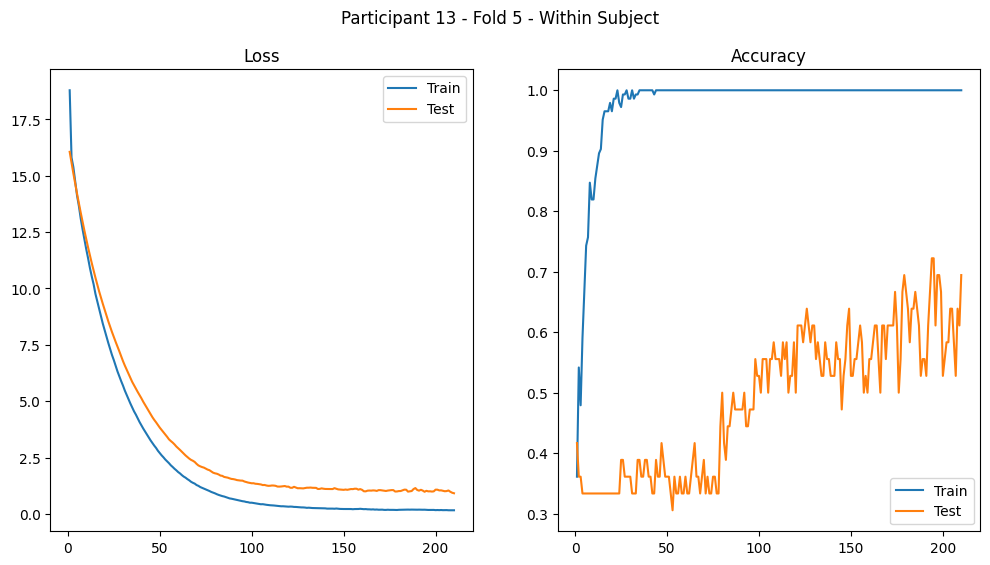

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 388ms/step - loss: 19.3078 - accuracy: 0.3403 - val_loss: 16.6247 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 97ms/step - loss: 16.5358 - accuracy: 0.3958 - val_loss: 16.1329 - val_accuracy: 0.2778
Epoch 3/500
5/5 [==============================] - 0s 92ms/step - loss: 15.9283 - accuracy: 0.4722 - val_loss: 15.6525 - val_accuracy: 0.2778
Epoch 4/500
5/5 [==============================] - 0s 87ms/step - loss: 15.3717 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

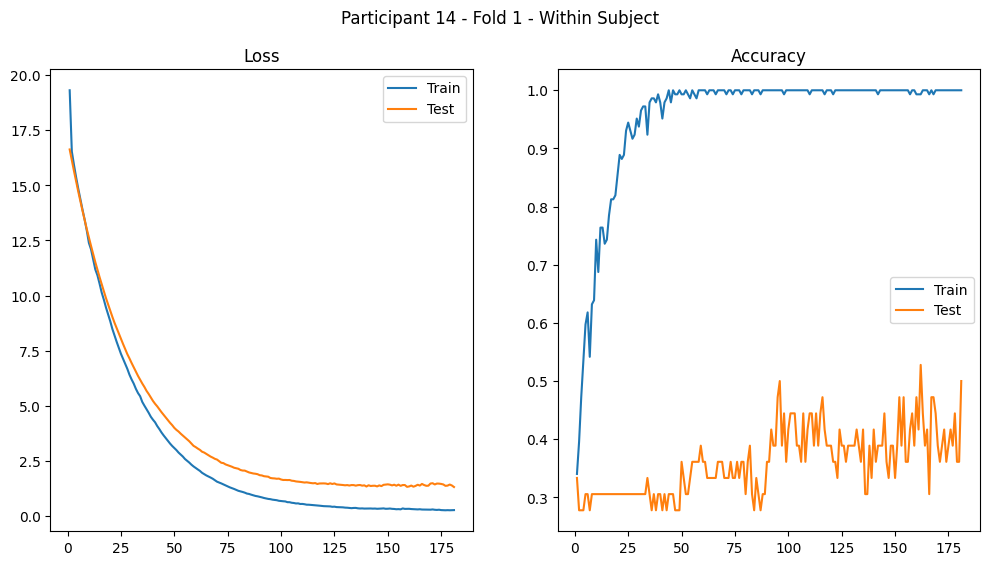

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 387ms/step - loss: 18.8434 - accuracy: 0.3681 - val_loss: 16.1325 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 85ms/step - loss: 16.0679 - accuracy: 0.3958 - val_loss: 15.6474 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 15.4766 - accuracy: 0.4306 - val_loss: 15.1708 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 14.9491 - accuracy: 0.5208 - va

<Figure size 640x480 with 0 Axes>

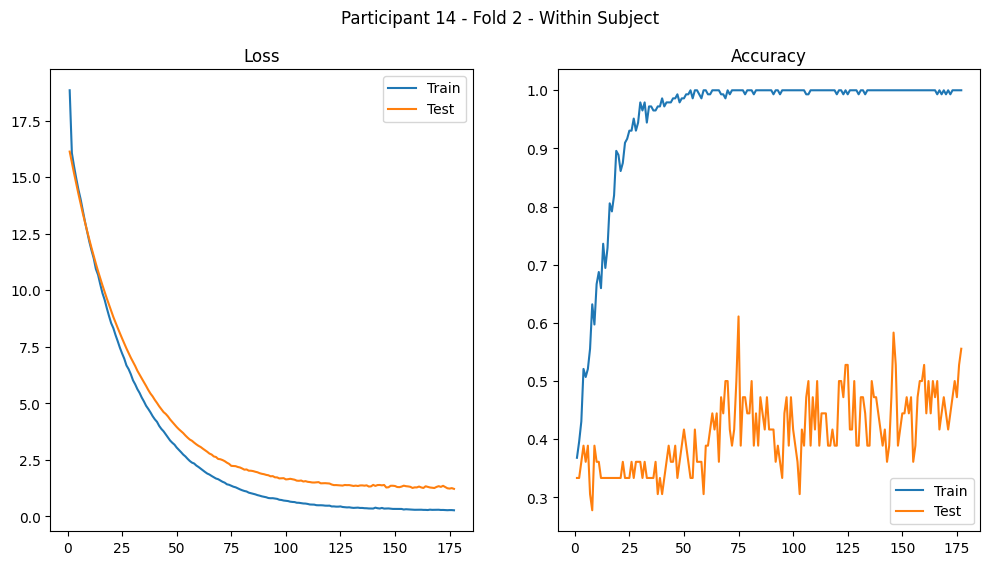

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 378ms/step - loss: 19.6235 - accuracy: 0.3542 - val_loss: 16.8322 - val_accuracy: 0.4167
Epoch 2/500
5/5 [==============================] - 0s 78ms/step - loss: 16.7154 - accuracy: 0.4514 - val_loss: 16.3292 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 91ms/step - loss: 16.1649 - accuracy: 0.4444 - val_loss: 15.8418 - val_accuracy: 0.4722
Epoch 4/500
5/5 [==============================] - 0s 81ms/step - loss: 15.6079 - accuracy: 0.5694 - va

<Figure size 640x480 with 0 Axes>

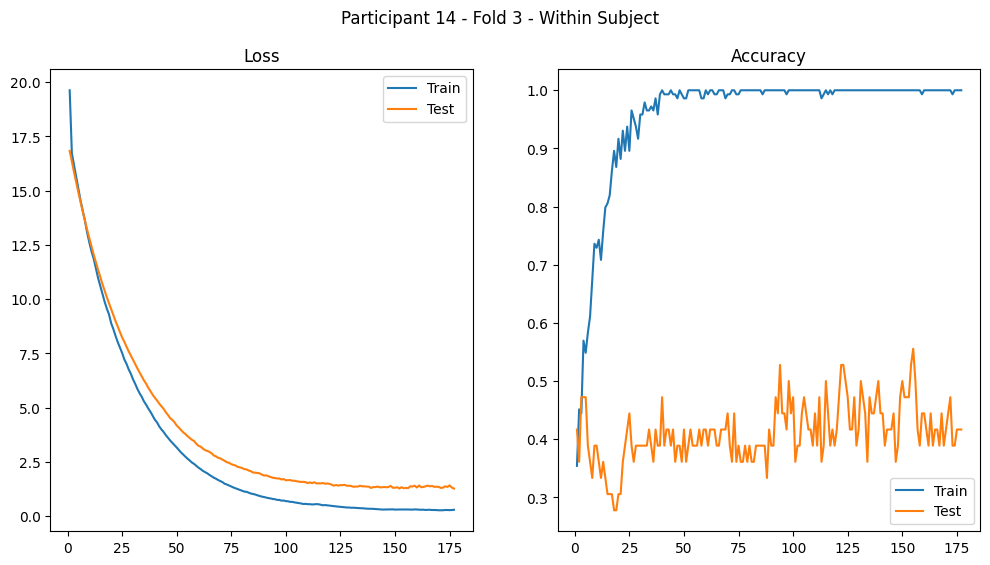

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 384ms/step - loss: 19.6089 - accuracy: 0.3194 - val_loss: 16.8652 - val_accuracy: 0.4722
Epoch 2/500
5/5 [==============================] - 0s 88ms/step - loss: 16.7418 - accuracy: 0.4236 - val_loss: 16.3592 - val_accuracy: 0.4444
Epoch 3/500
5/5 [==============================] - 0s 94ms/step - loss: 16.1181 - accuracy: 0.5069 - val_loss: 15.8711 - val_accuracy: 0.4444
Epoch 4/500
5/5 [==============================] - 0s 77ms/step - loss: 15.6199 - accuracy: 0.5417 - va

<Figure size 640x480 with 0 Axes>

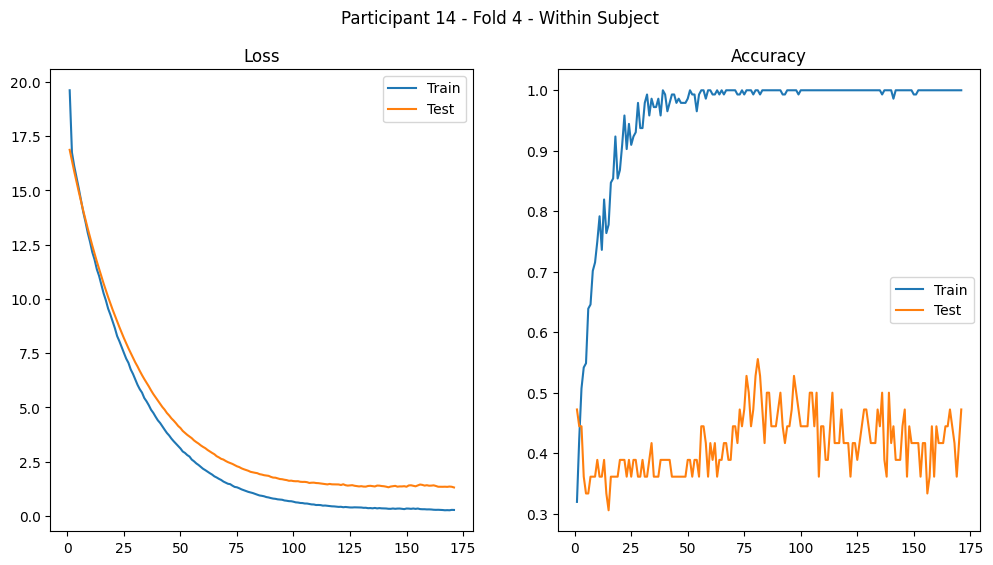

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 379ms/step - loss: 19.5809 - accuracy: 0.3472 - val_loss: 16.9004 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 93ms/step - loss: 16.9016 - accuracy: 0.3333 - val_loss: 16.3981 - val_accuracy: 0.3056
Epoch 3/500
5/5 [==============================] - 0s 88ms/step - loss: 16.0869 - accuracy: 0.5417 - val_loss: 15.9089 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 97ms/step - loss: 15.6673 - accuracy: 0.5000 - va

<Figure size 640x480 with 0 Axes>

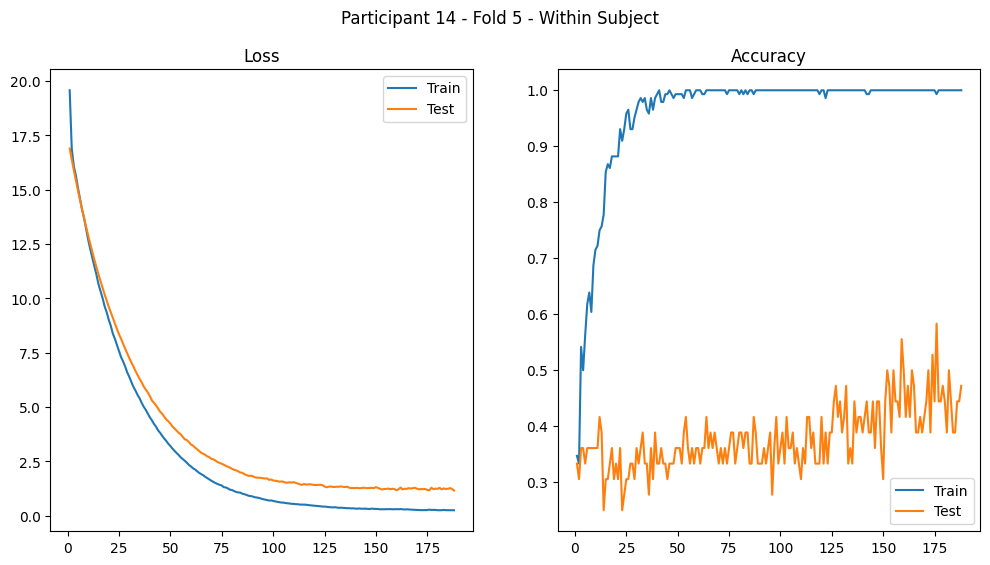

(180, 1)
Outer Loop 1 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 386ms/step - loss: 19.7780 - accuracy: 0.3889 - val_loss: 16.9272 - val_accuracy: 0.3611
Epoch 2/500
5/5 [==============================] - 0s 82ms/step - loss: 16.7544 - accuracy: 0.4722 - val_loss: 16.4214 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 98ms/step - loss: 16.1279 - accuracy: 0.5278 - val_loss: 15.9302 - val_accuracy: 0.3611
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 15.5882 - accuracy: 0.

<Figure size 640x480 with 0 Axes>

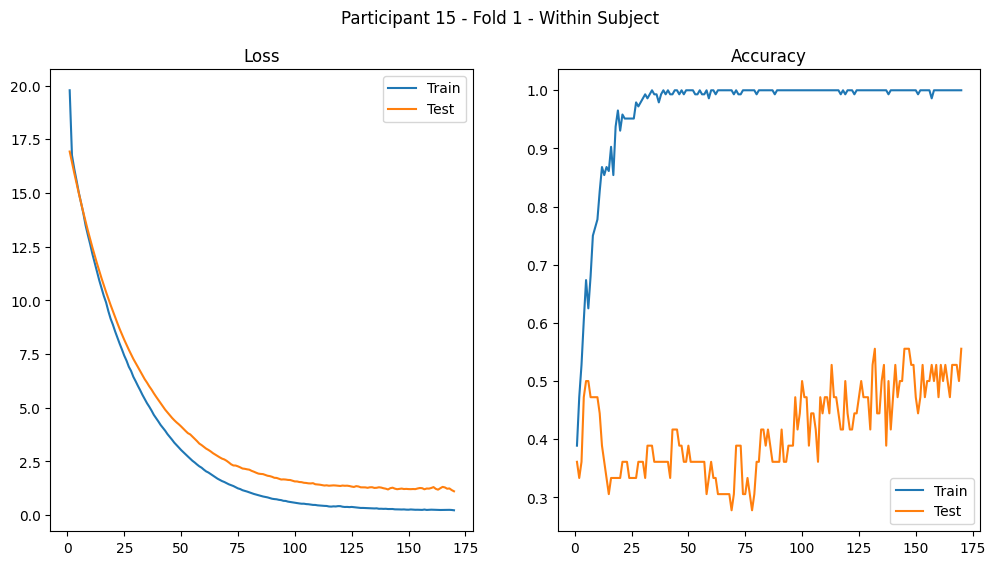

Outer Loop 2 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 384ms/step - loss: 20.2738 - accuracy: 0.2778 - val_loss: 17.2630 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 17.0450 - accuracy: 0.4583 - val_loss: 16.7596 - val_accuracy: 0.3333
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 16.5301 - accuracy: 0.5278 - val_loss: 16.2654 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 92ms/step - loss: 15.9320 - accuracy: 0.5972 - va

<Figure size 640x480 with 0 Axes>

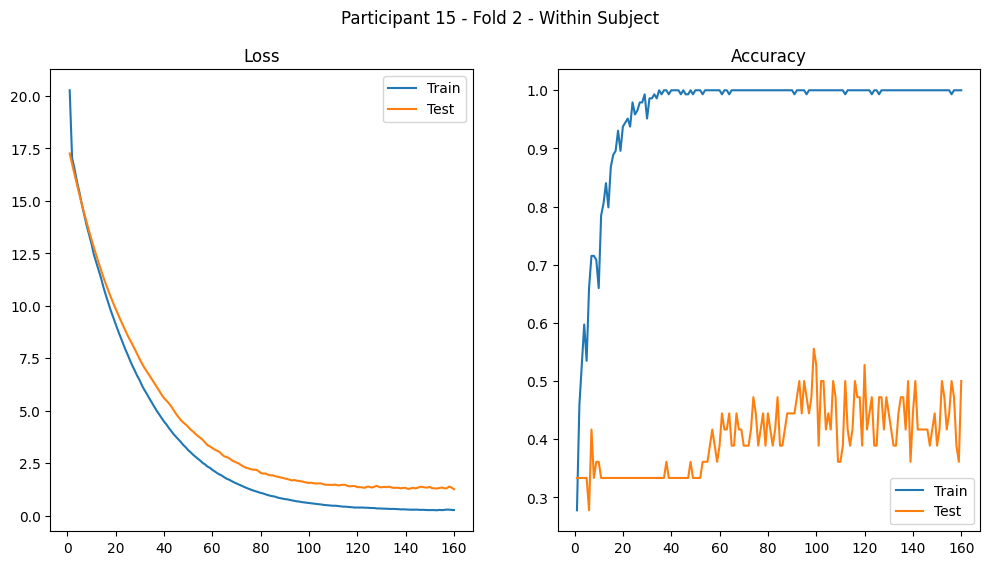

Outer Loop 3 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 11s 386ms/step - loss: 19.1753 - accuracy: 0.3472 - val_loss: 16.6041 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 94ms/step - loss: 16.5813 - accuracy: 0.3542 - val_loss: 16.0969 - val_accuracy: 0.3889
Epoch 3/500
5/5 [==============================] - 0s 89ms/step - loss: 15.8450 - accuracy: 0.5069 - val_loss: 15.6076 - val_accuracy: 0.3333
Epoch 4/500
5/5 [==============================] - 0s 81ms/step - loss: 15.3197 - accuracy: 0.5347 - va

<Figure size 640x480 with 0 Axes>

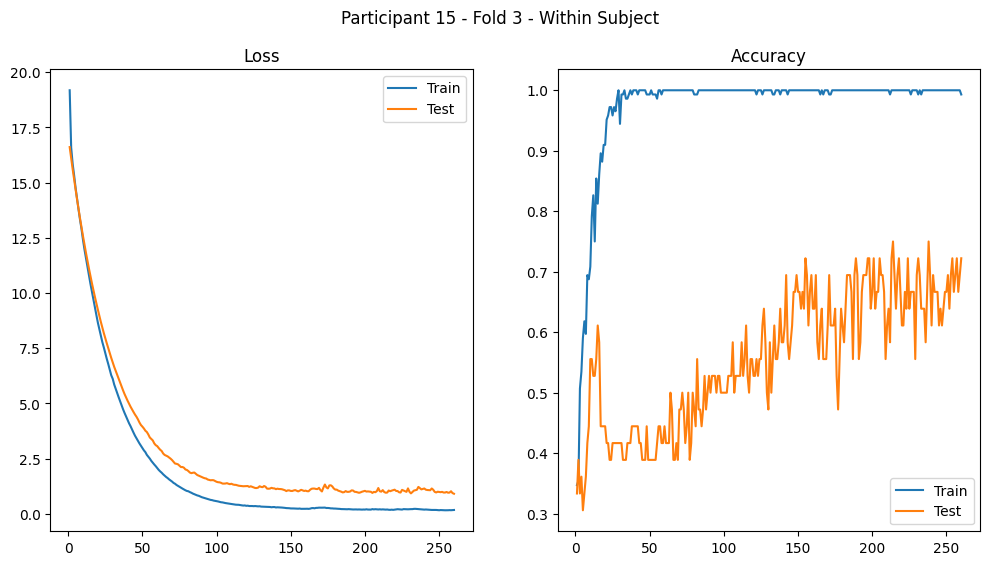

Outer Loop 4 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 379ms/step - loss: 19.4532 - accuracy: 0.3542 - val_loss: 16.7955 - val_accuracy: 0.3333
Epoch 2/500
5/5 [==============================] - 0s 87ms/step - loss: 16.6597 - accuracy: 0.4861 - val_loss: 16.2962 - val_accuracy: 0.2500
Epoch 3/500
5/5 [==============================] - 0s 99ms/step - loss: 16.0271 - accuracy: 0.5417 - val_loss: 15.8144 - val_accuracy: 0.2222
Epoch 4/500
5/5 [==============================] - 0s 91ms/step - loss: 15.4828 - accuracy: 0.5625 - va

<Figure size 640x480 with 0 Axes>

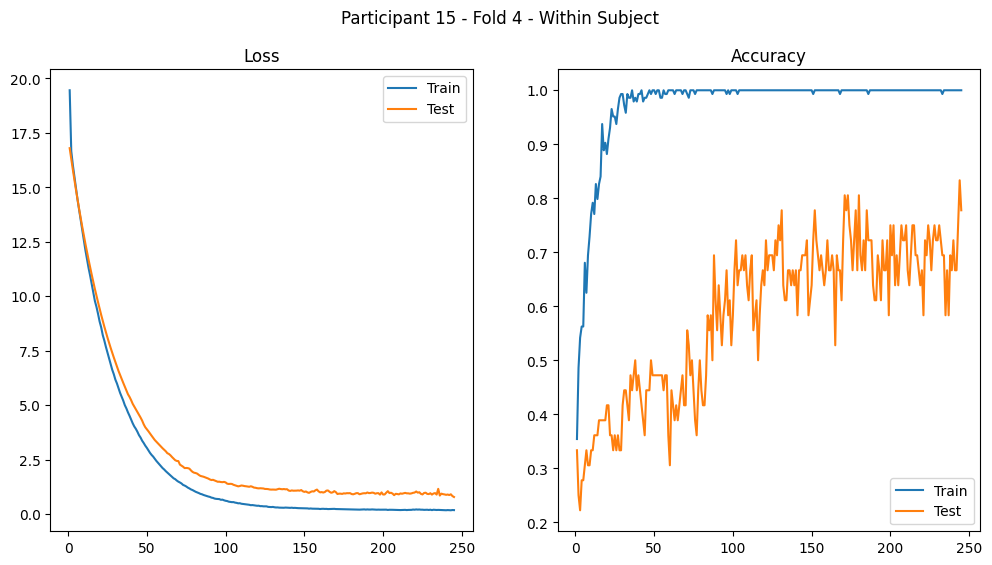

Outer Loop 5 

      Train epochs' shape:                                (144, 1, 64, 1123)
      Test epochs' shape:                                 (36, 1, 64, 1123)
      Train labels' shape:                                (144, 3)
      Test labels' shape:                                 (36, 3)
      Train labels' shape (without encoding):             (144, 1)
      Test labels' shape (without encoding):              (36, 1)



(1, 1, 1, 1123)
(1, 1, 1, 1123)
Epoch 1/500
5/5 [==============================] - 10s 380ms/step - loss: 19.0190 - accuracy: 0.3681 - val_loss: 16.3917 - val_accuracy: 0.3056
Epoch 2/500
5/5 [==============================] - 0s 91ms/step - loss: 16.1523 - accuracy: 0.4931 - val_loss: 15.8975 - val_accuracy: 0.3611
Epoch 3/500
5/5 [==============================] - 0s 87ms/step - loss: 15.5491 - accuracy: 0.5417 - val_loss: 15.4131 - val_accuracy: 0.4167
Epoch 4/500
5/5 [==============================] - 0s 89ms/step - loss: 15.0663 - accuracy: 0.5764 - va

<Figure size 640x480 with 0 Axes>

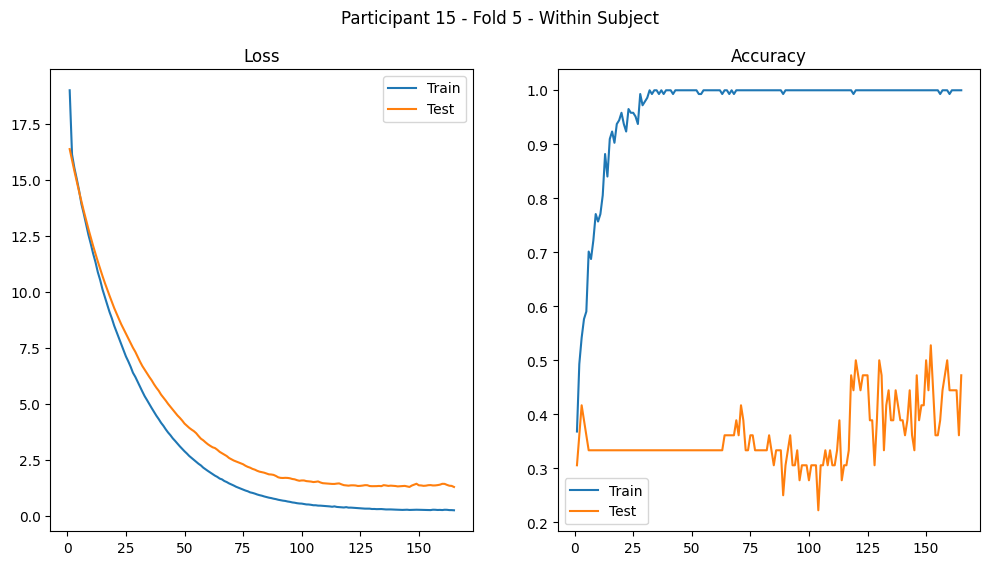

<Figure size 640x480 with 0 Axes>

In [40]:
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500



for j in range(num_subjects):
    
    if j == 1 or j == 8:
        continue
    
    epochs_subject = all_data_epochs[j]
    labels_subject = encoded[j]
    labels_subject_no_encode = no_encode[j]
    
    print(labels_subject_no_encode.shape)
    
    kf_outer2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    
    tests_pred = []
    tests_true = []
    
    for i, (train_index, test_index) in enumerate(kf_outer2.split(epochs_subject, labels_subject_no_encode[:, 0])):



        train_epochs = np.array([epochs_subject[j] for j in train_index])
        test_epochs = np.array([epochs_subject[k] for k in test_index])
        train_labels = np.array([labels_subject[l] for l in train_index])
        test_labels = np.array([labels_subject[m] for m in test_index])
        no_encoded_train_labels = np.array([labels_subject_no_encode[n] for n in train_index])
        no_encoded_test_labels = np.array([labels_subject_no_encode[o] for o in test_index])
        


        print("Outer Loop {}".format(i+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        print("      Train labels' shape:                               ", train_labels.shape)
        print("      Test labels' shape:                                ", test_labels.shape)
        print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

        print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)

        print('\n\n')


        dataset = 'BCI2a'
        in_samples = 1123                   # Changed!!!
        n_channels = 64
        n_sub = 9
        n_classes = 3


        # Set dataset paramters as dataset configuration
        dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                        'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                        'isStandard': True, 'LOSO': True}


        # Set training hyperparamters as train configuration
        train_conf = { 'batch_size': 64, 'epochs': 1000, 'patience': 300, 'lr': 0.001,
                      'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

        model = getModel(train_conf.get('model'), dataset_conf)


        model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])


        patience = 30
        train_loss_epochs = []
        train_acc_epochs = []
        test_loss_epochs = []
        test_acc_epochs = []
        train_conf_mat = []

        # Define early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)


        # Normalizing the features
        mean = train_epochs.mean(axis=(0, 2), keepdims=True)
        std = train_epochs.std(axis=(0, 2), keepdims=True)

        print(mean.shape)
        print(std.shape)

        norm_train_epochs = (train_epochs - mean) / std
        norm_test_epochs = (test_epochs - mean) / std
        

        # Train the model
        history = model.fit(
            norm_train_epochs, train_labels,
            validation_data=(norm_test_epochs, test_labels),
            epochs=max_epochs,
            batch_size=32,  # Adjust as needed
            callbacks=[early_stopping]
        )

        y_pred_test = model.predict(norm_test_epochs)
        y_true_test = test_labels

        

        # Collect training metrics
        train_loss_epochs.extend(history.history['loss'])
        train_acc_epochs.extend(history.history['accuracy'])

        # Collect testing metrics
        test_loss_epochs.extend(history.history['val_loss'])
        test_acc_epochs.extend(history.history['val_accuracy'])

        epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)

        plt.figure(figsize=(12, 6))
        plt.suptitle("Participant {} - Fold {} - Within Subject".format(j+1, i+1))

        plt.subplot(1, 2, 1)
        plt.title("Loss")
        plt.plot(epochs_range, train_loss_epochs[:-1*patience])
        plt.plot(epochs_range, test_loss_epochs[:-1*patience])
        plt.legend(["Train", "Test"])

        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.plot(epochs_range, train_acc_epochs[:-1*patience])
        plt.plot(epochs_range, test_acc_epochs[:-1*patience])
        plt.legend(["Train", "Test"])
        plt.savefig("P{}_F{}_WS.jpg".format(j+1, i+1))
        plt.show()
        plt.clf()
        
        tests_pred.extend(y_pred_test)
        tests_true.extend(y_true_test)
    
    with open("y_pred_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_pred, f)

    with open("y_true_ParID_{}_ws.pickle".format(j+1), 'wb') as f:
        pickle.dump(tests_true, f)
        
    all_tests_pred.append(tests_pred)
    all_tests_true.append(tests_true)


In [ ]:
participants[0]

In [ ]:
print(len(all_tests_pred))

In [ ]:
print(np.concatenate(all_tests_pred[4]).shape)

In [53]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

j = 1
for i in range(1, 15):
    
    if i == 1 or i == 8:
        continue
    
    
    with open("y_pred_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_ParID_{}_ws.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    
    
    y_true = np.array(all_y_true[j-1])
    y_pred = np.array(all_y_pred[j-1])
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))
    j = j + 1

In [54]:
len(confusion_matrices)

12

In [52]:
del confusion_matrices[3]

In [55]:
confusion_matrices[3]

array([[59,  1,  0],
       [ 0, 59,  1],
       [ 0,  0, 60]])

In [ ]:
print(confusion_matrices[1])

In [ ]:
print(len(confusion_matrices))

In [56]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Right (True)', 'SI (True)', 'RS (True)'], columns=['Right (Pred)', 'SI (Pred)', 'RS (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 3


In [57]:
print("Dataset: Hadi - Phase II (3-Class)")
print("The within-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: {:.2f}".format(acc))

normalized

Dataset: Hadi - Phase II (3-Class)
The within-subject scenario:
Algorithm: ATCNet
Accuracy: 0.72


Right (Pred)  SI (Pred)  RS (Pred)
Right (True)      0.731250   0.089063   0.179688
SI (True)         0.104688   0.720313   0.175000
RS (True)         0.159375   0.126562   0.714063

In [ ]:
summation.sum(axis=1)

In [ ]:
np.sum(summation / 576 * np.eye(4, 4)).sum() / 4

# Cross-subjects (With hyperparameter tuning):

Outer Loop 1 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15]
      Test index:                                         [12]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500


2024-05-12 09:26:27.879509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-05-12 09:26:28.522589: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-12 09:26:28.524861: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-12 09:26:28.524979: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-05-12 09:26:28.527181: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-12 09:26:28.527424: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


72/72 [==============================] - 18s 92ms/step - loss: 13.8346 - accuracy: 0.3421 - val_loss: 10.7208 - val_accuracy: 0.3556
Epoch 2/500
72/72 [==============================] - 5s 66ms/step - loss: 8.7584 - accuracy: 0.4057 - val_loss: 6.9796 - val_accuracy: 0.3500
Epoch 3/500
72/72 [==============================] - 5s 67ms/step - loss: 5.6736 - accuracy: 0.5118 - val_loss: 4.5408 - val_accuracy: 0.5944
Epoch 4/500
72/72 [==============================] - 5s 69ms/step - loss: 3.7831 - accuracy: 0.5706 - val_loss: 3.0007 - val_accuracy: 0.7611
Epoch 5/500
72/72 [==============================] - 5s 68ms/step - loss: 2.6375 - accuracy: 0.5987 - val_loss: 2.0424 - val_accuracy: 0.8389
Epoch 6/500
72/72 [==============================] - 5s 70ms/step - loss: 1.9379 - accuracy: 0.6285 - val_loss: 1.4386 - val_accuracy: 0.8556
Epoch 7/500
72/72 [==============================] - 5s 69ms/step - loss: 1.5401 - accuracy: 0.6246 - val_loss: 1.2522 - val_accuracy: 0.8889
Epoch 8/500
72/

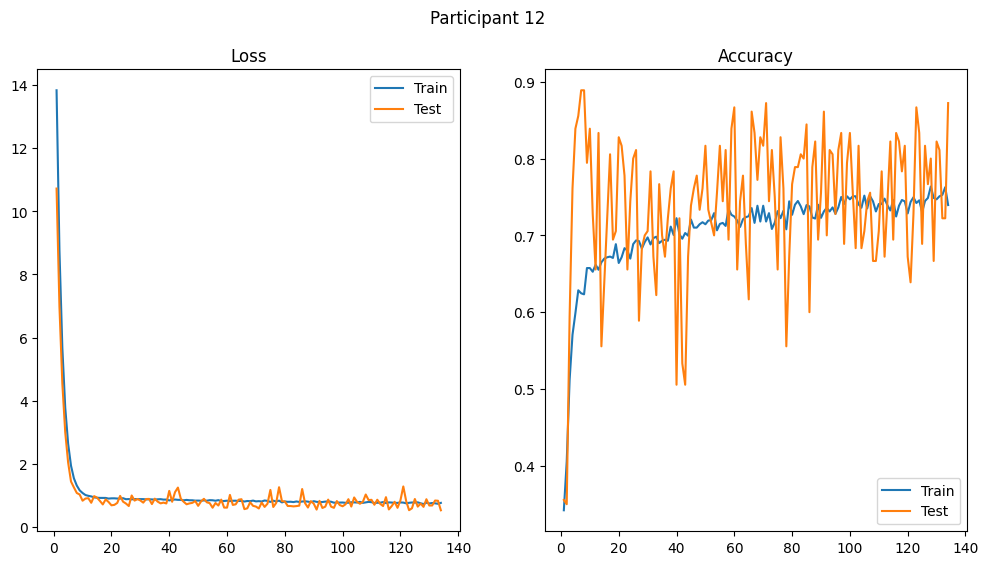

Outer Loop 2 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [5]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 14s 85ms/step - loss: 13.4957 - accuracy: 0.3482 - val_loss: 10.4833 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 70ms/step - loss: 8.6370 - accuracy: 0.3991 - val_loss: 6.9001 - val_accuracy: 0.3444
Epoch 3/500
72/72 [==============================] - 5s 69ms/step - loss: 5.6820 - accuracy: 0.4627 - val_loss: 4.5298 - val_accuracy: 0.6000

<Figure size 640x480 with 0 Axes>

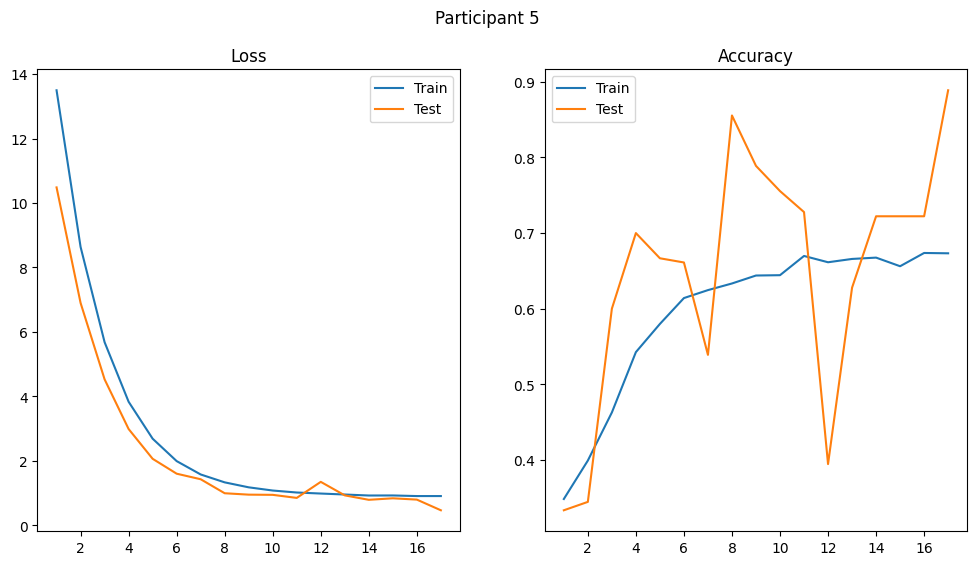

Outer Loop 3 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [6]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 83ms/step - loss: 14.3386 - accuracy: 0.3399 - val_loss: 11.1227 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 67ms/step - loss: 9.1198 - accuracy: 0.3969 - val_loss: 7.3066 - val_accuracy: 0.3333
Epoch 3/500
72/72 [==============================] - 5s 68ms/step - loss: 5.9318 - accuracy: 0.4785 - val_loss: 4.8893 - val_accuracy: 0.3333

<Figure size 640x480 with 0 Axes>

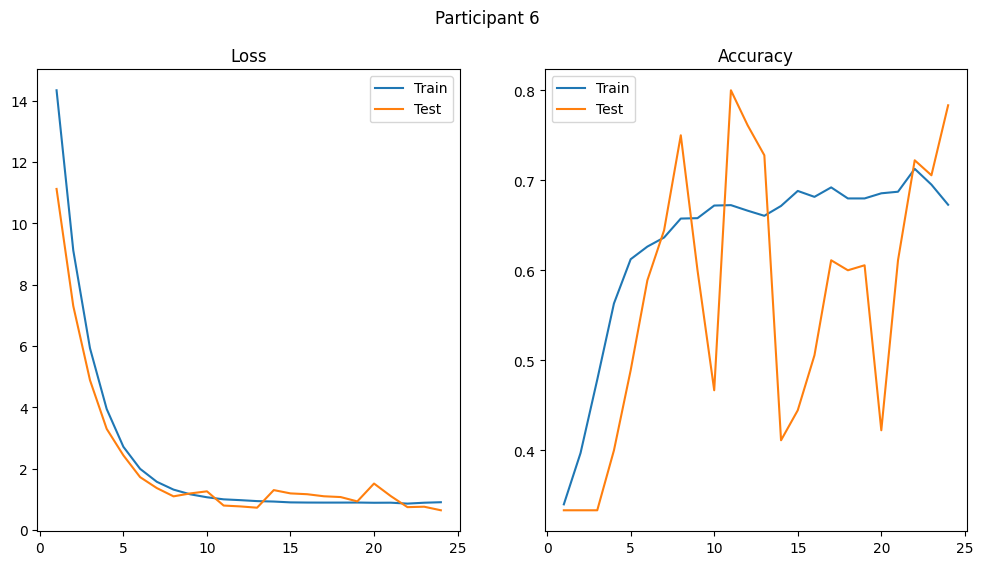

Outer Loop 4 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [1]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 85ms/step - loss: 13.6374 - accuracy: 0.3732 - val_loss: 10.6078 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 68ms/step - loss: 8.6593 - accuracy: 0.4544 - val_loss: 7.0085 - val_accuracy: 0.3389
Epoch 3/500
72/72 [==============================] - 5s 68ms/step - loss: 5.5970 - accuracy: 0.5654 - val_loss: 4.8172 - val_accuracy: 0.3500

<Figure size 640x480 with 0 Axes>

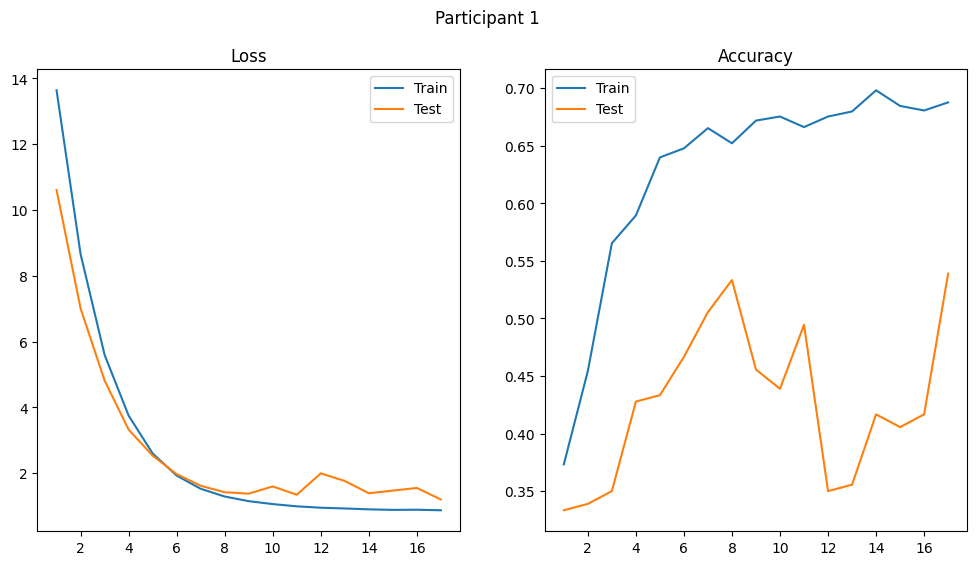

Outer Loop 5 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]
      Test index:                                         [10]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 85ms/step - loss: 14.5665 - accuracy: 0.3588 - val_loss: 11.3246 - val_accuracy: 0.3778
Epoch 2/500
72/72 [==============================] - 5s 68ms/step - loss: 9.2750 - accuracy: 0.4061 - val_loss: 7.3820 - val_accuracy: 0.4556
Epoch 3/500
72/72 [==============================] - 5s 69ms/step - loss: 6.0104 - accuracy: 0.5039 - val_loss: 4.8736 - val_accuracy: 0.4500

<Figure size 640x480 with 0 Axes>

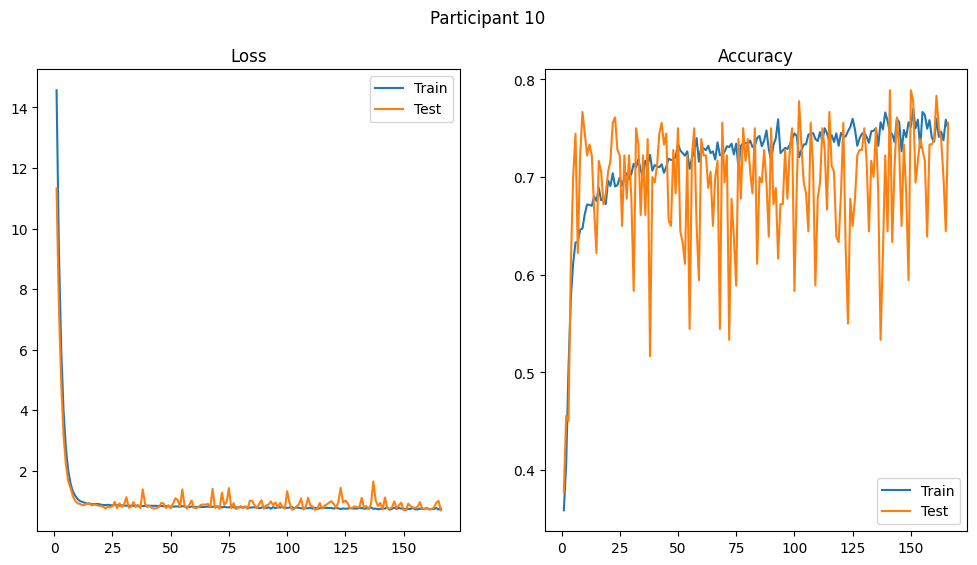

Outer Loop 6 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [4]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 85ms/step - loss: 14.1458 - accuracy: 0.3654 - val_loss: 11.0136 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 65ms/step - loss: 8.9680 - accuracy: 0.4167 - val_loss: 7.1569 - val_accuracy: 0.3333
Epoch 3/500
72/72 [==============================] - 5s 70ms/step - loss: 5.8212 - accuracy: 0.4618 - val_loss: 4.8467 - val_accuracy: 0.3389

<Figure size 640x480 with 0 Axes>

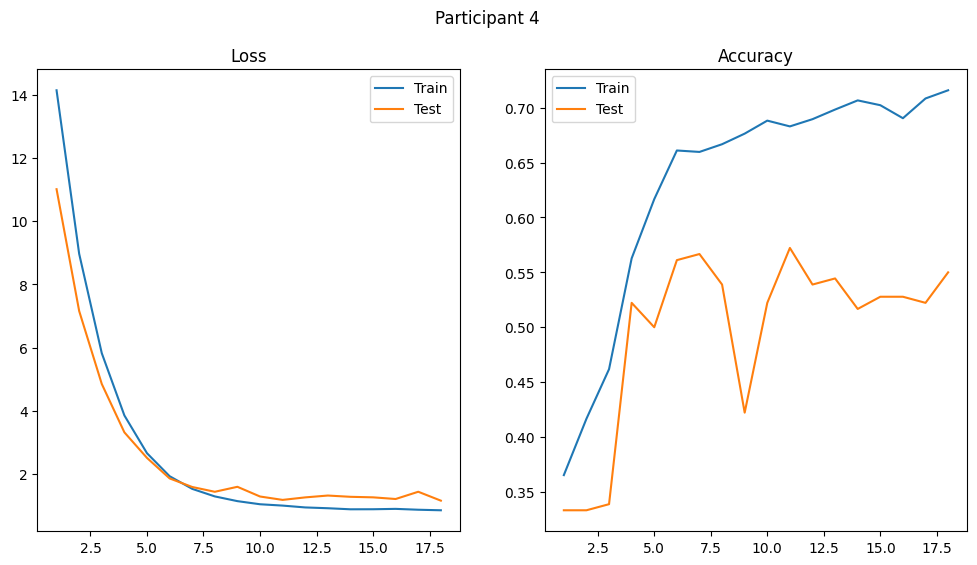

Outer Loop 7 

      Train epochs' shape:                                (2400, 1, 64, 1123)
      Test epochs' shape:                                 (60, 1, 64, 1123)
      Test labels' shape:                                 (60, 3)
      Train labels' shape (without encoding):             (2400, 1)
      Test labels' shape (without encoding):              (60, 1)
      Train index:                                        [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [2]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
75/75 [==============================] - 13s 83ms/step - loss: 14.0819 - accuracy: 0.3379 - val_loss: 10.8339 - val_accuracy: 0.3333
Epoch 2/500
75/75 [==============================] - 5s 63ms/step - loss: 8.7527 - accuracy: 0.4263 - val_loss: 6.9188 - val_accuracy: 0.4333
Epoch 3/500
75/75 [==============================] - 5s 64ms/step - loss: 5.5429 - accuracy: 0.5312 - val_loss: 4.9030 - val_accuracy: 0.4000
Ep

<Figure size 640x480 with 0 Axes>

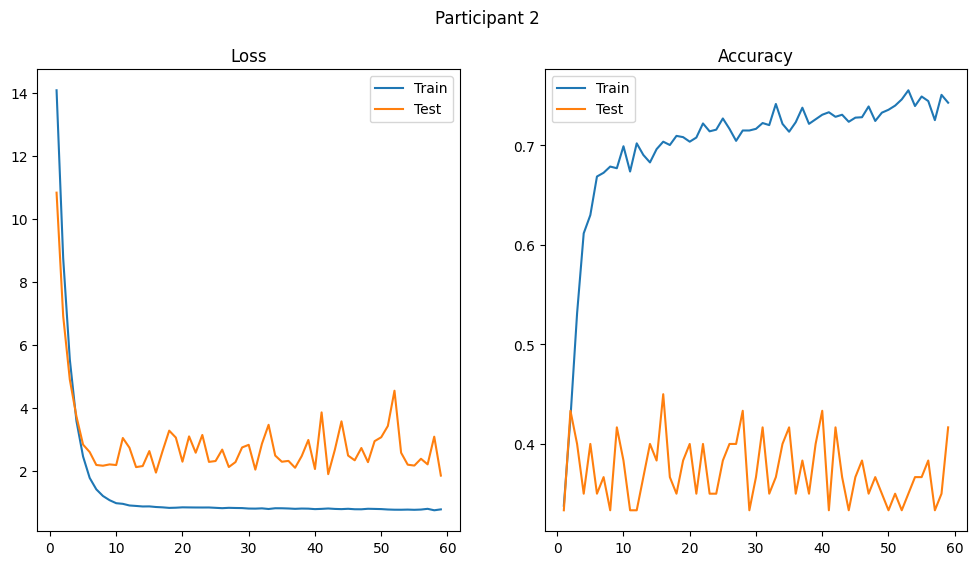

Outer Loop 8 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15]
      Test index:                                         [11]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 83ms/step - loss: 14.4657 - accuracy: 0.3469 - val_loss: 11.2348 - val_accuracy: 0.3778
Epoch 2/500
72/72 [==============================] - 5s 69ms/step - loss: 9.2314 - accuracy: 0.3952 - val_loss: 7.3669 - val_accuracy: 0.4111
Epoch 3/500
72/72 [==============================] - 5s 66ms/step - loss: 6.0420 - accuracy: 0.4855 - val_loss: 4.9624 - val_accuracy: 0.3889

<Figure size 640x480 with 0 Axes>

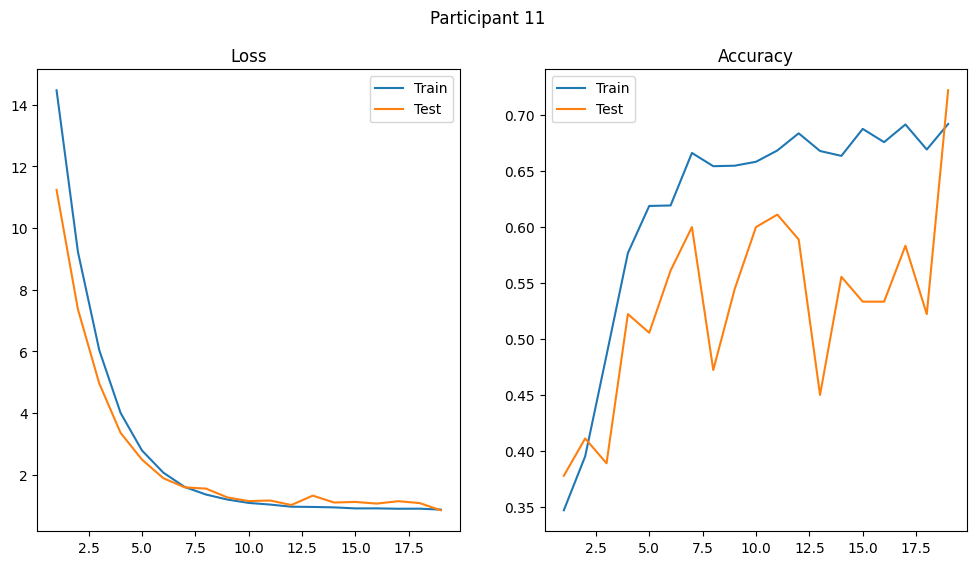

Outer Loop 9 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [8]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 87ms/step - loss: 13.9519 - accuracy: 0.3724 - val_loss: 10.8872 - val_accuracy: 0.3833
Epoch 2/500
72/72 [==============================] - 5s 67ms/step - loss: 8.8972 - accuracy: 0.4636 - val_loss: 7.1834 - val_accuracy: 0.4056
Epoch 3/500
72/72 [==============================] - 5s 69ms/step - loss: 5.7868 - accuracy: 0.5548 - val_loss: 4.9557 - val_accuracy: 0.3444

<Figure size 640x480 with 0 Axes>

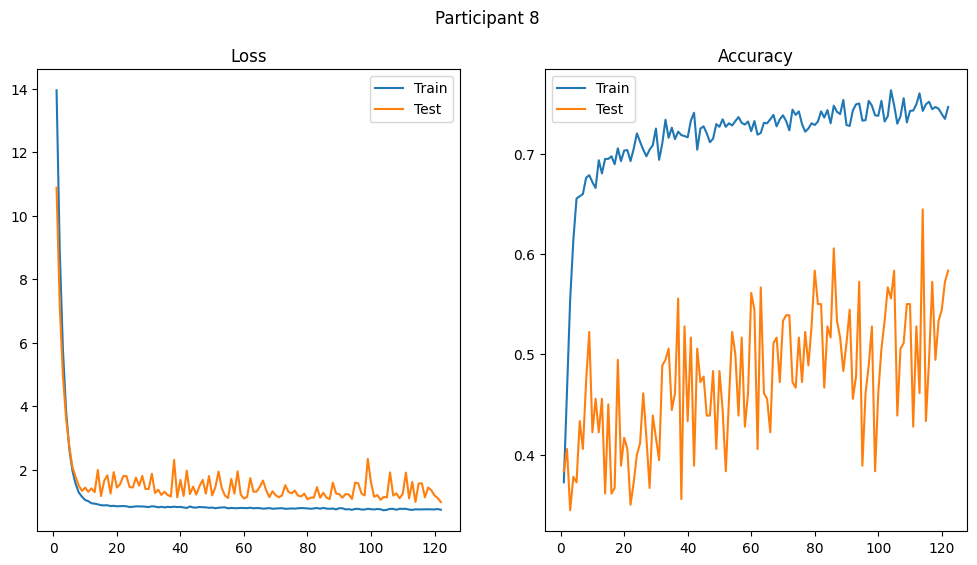

Outer Loop 10 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]
      Test index:                                         [13]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 85ms/step - loss: 13.1960 - accuracy: 0.3487 - val_loss: 10.1701 - val_accuracy: 0.3167
Epoch 2/500
72/72 [==============================] - 5s 66ms/step - loss: 8.2610 - accuracy: 0.4439 - val_loss: 6.6511 - val_accuracy: 0.3444
Epoch 3/500
72/72 [==============================] - 5s 66ms/step - loss: 5.3055 - accuracy: 0.5535 - val_loss: 4.4503 - val_accuracy: 0.444

<Figure size 640x480 with 0 Axes>

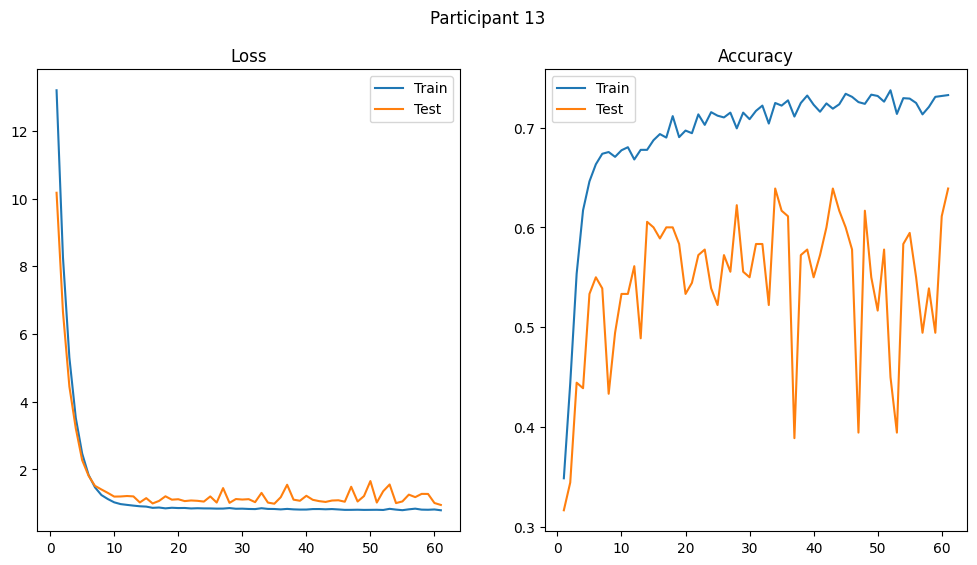

Outer Loop 11 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [3]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 87ms/step - loss: 13.9722 - accuracy: 0.3522 - val_loss: 10.8551 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 67ms/step - loss: 8.8698 - accuracy: 0.4298 - val_loss: 7.1263 - val_accuracy: 0.3333
Epoch 3/500
72/72 [==============================] - 5s 70ms/step - loss: 5.7924 - accuracy: 0.4781 - val_loss: 4.8424 - val_accuracy: 0.372

<Figure size 640x480 with 0 Axes>

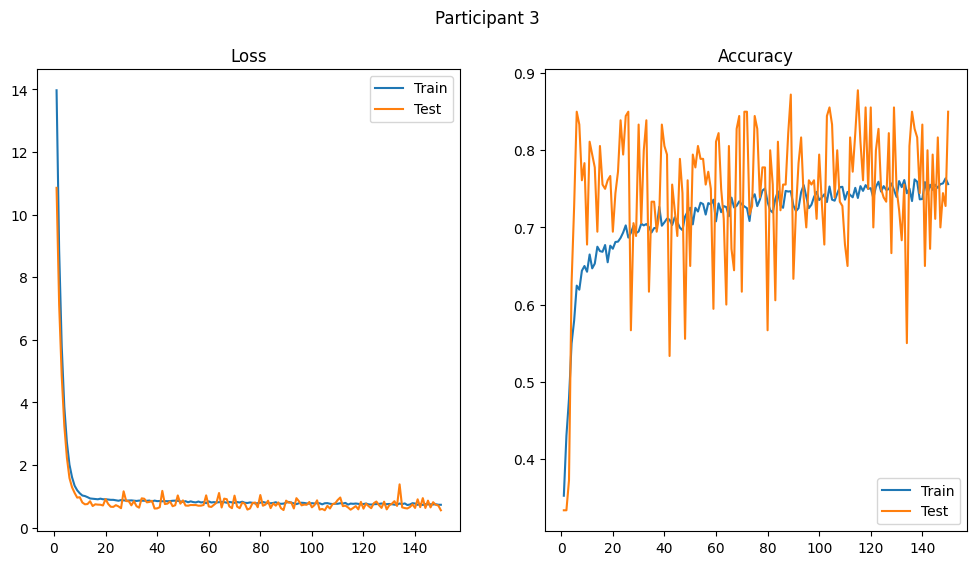

Outer Loop 12 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
      Test index:                                         [7]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 82ms/step - loss: 14.5455 - accuracy: 0.3346 - val_loss: 11.3124 - val_accuracy: 0.3333
Epoch 2/500
72/72 [==============================] - 5s 69ms/step - loss: 9.2890 - accuracy: 0.4075 - val_loss: 7.4485 - val_accuracy: 0.3333
Epoch 3/500
72/72 [==============================] - 5s 68ms/step - loss: 6.0835 - accuracy: 0.4732 - val_loss: 5.1900 - val_accuracy: 0.333

<Figure size 640x480 with 0 Axes>

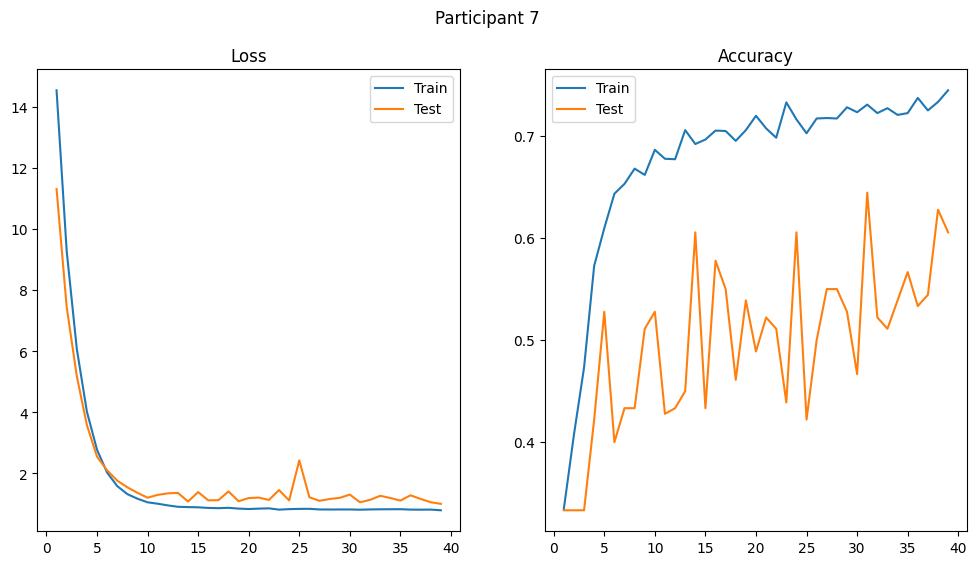

Outer Loop 13 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
      Test index:                                         [15]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 86ms/step - loss: 13.9936 - accuracy: 0.3364 - val_loss: 10.8532 - val_accuracy: 0.3611
Epoch 2/500
72/72 [==============================] - 5s 68ms/step - loss: 8.9117 - accuracy: 0.3776 - val_loss: 7.0900 - val_accuracy: 0.3833
Epoch 3/500
72/72 [==============================] - 5s 71ms/step - loss: 5.8174 - accuracy: 0.4636 - val_loss: 4.7245 - val_accuracy: 0.472

<Figure size 640x480 with 0 Axes>

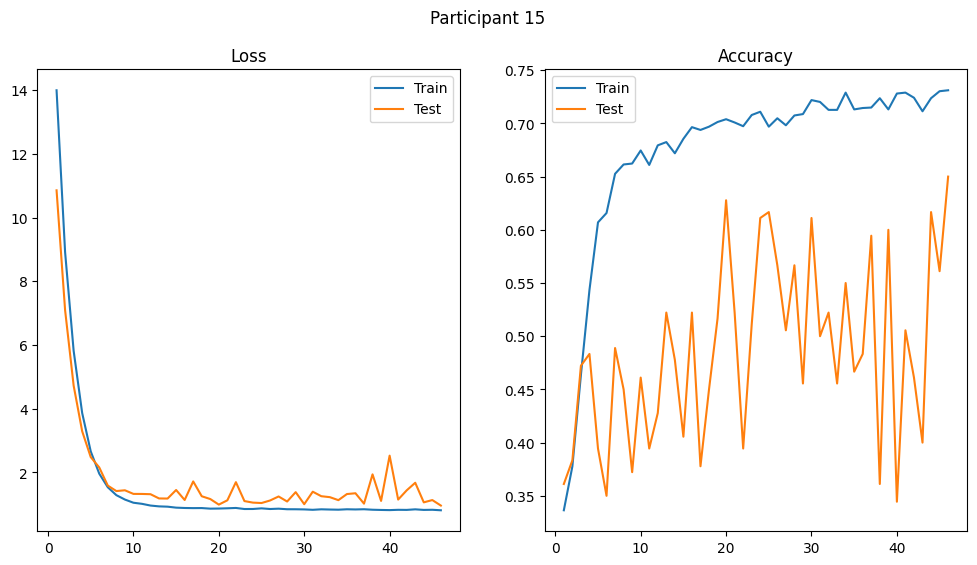

Outer Loop 14 

      Train epochs' shape:                                (2280, 1, 64, 1123)
      Test epochs' shape:                                 (180, 1, 64, 1123)
      Test labels' shape:                                 (180, 3)
      Train labels' shape (without encoding):             (2280, 1)
      Test labels' shape (without encoding):              (180, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15]
      Test index:                                         [14]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
72/72 [==============================] - 15s 87ms/step - loss: 14.5294 - accuracy: 0.3588 - val_loss: 11.3221 - val_accuracy: 0.3444
Epoch 2/500
72/72 [==============================] - 5s 68ms/step - loss: 9.2643 - accuracy: 0.4417 - val_loss: 7.4635 - val_accuracy: 0.3611
Epoch 3/500
72/72 [==============================] - 5s 67ms/step - loss: 6.0208 - accuracy: 0.5474 - val_loss: 5.0325 - val_accuracy: 0.366

<Figure size 640x480 with 0 Axes>

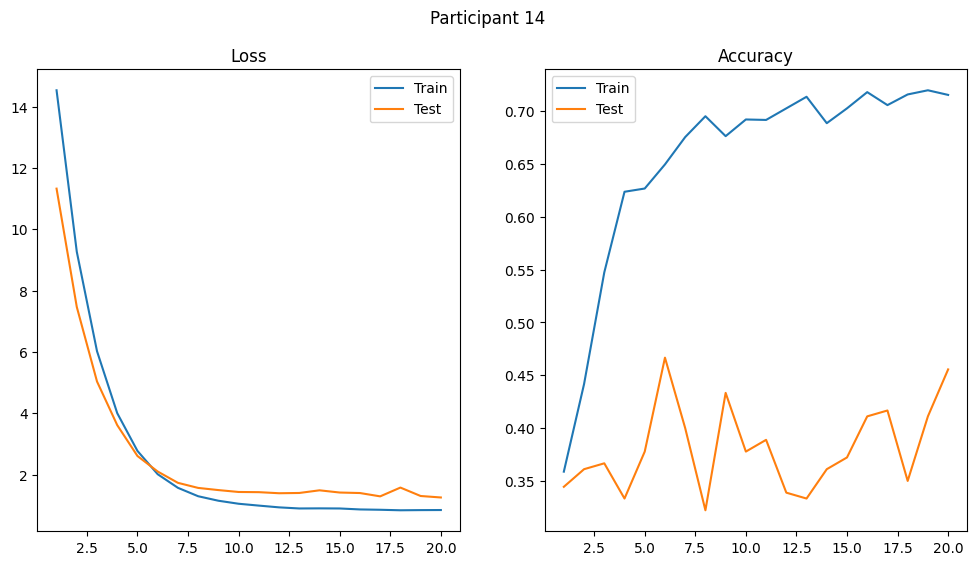

Outer Loop 15 

      Train epochs' shape:                                (2400, 1, 64, 1123)
      Test epochs' shape:                                 (60, 1, 64, 1123)
      Test labels' shape:                                 (60, 3)
      Train labels' shape (without encoding):             (2400, 1)
      Test labels' shape (without encoding):              (60, 1)
      Train index:                                        [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15]
      Test index:                                         [9]



(1, 1, 64, 1)
(1, 1, 64, 1)
Epoch 1/500
75/75 [==============================] - 13s 76ms/step - loss: 13.8685 - accuracy: 0.3392 - val_loss: 10.6397 - val_accuracy: 0.3667
Epoch 2/500
75/75 [==============================] - 5s 61ms/step - loss: 8.6213 - accuracy: 0.4475 - val_loss: 6.8214 - val_accuracy: 0.4500
Epoch 3/500
75/75 [==============================] - 5s 63ms/step - loss: 5.5096 - accuracy: 0.5129 - val_loss: 4.5577 - val_accuracy: 0.3833
E

<Figure size 640x480 with 0 Axes>

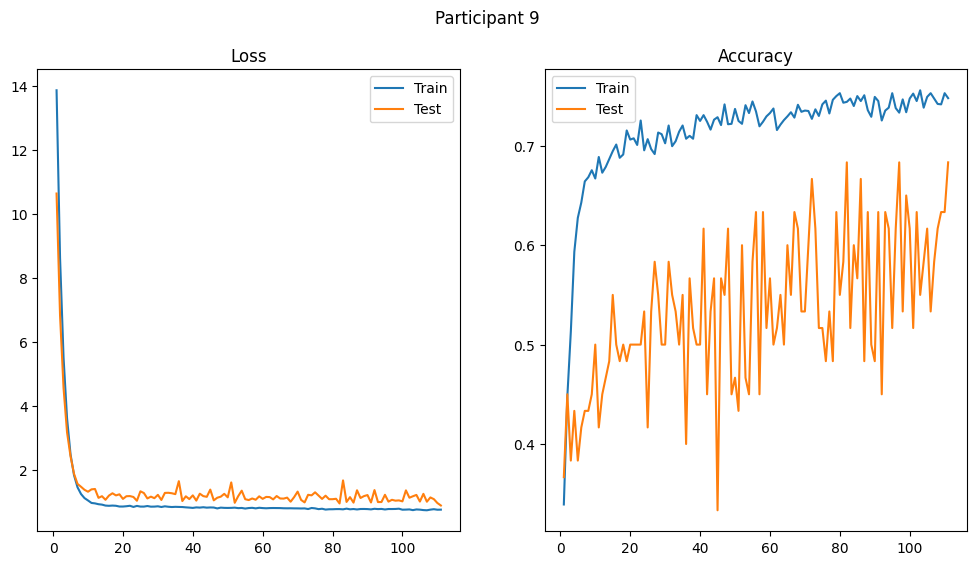

<Figure size 640x480 with 0 Axes>

In [29]:
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
class_numbers=4
num_subjects = len(all_data_epochs)
all_tests_true = []
all_tests_pred = []
max_epochs = 500
learning_rate=0.0009
patience = 50


kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.



for i, (train_index, test_index) in enumerate(kf_outer2.split(all_data_epochs)):
    
    
    
    train_epochs = np.concatenate([all_data_epochs[j] for j in train_index])
    test_epochs = np.concatenate([all_data_epochs[k] for k in test_index])
    train_labels = np.concatenate([encoded[l] for l in train_index])
    test_labels = np.concatenate([encoded[m] for m in test_index])
    no_encoded_train_labels = np.concatenate([no_encode[n] for n in train_index])
    no_encoded_test_labels = np.concatenate([no_encode[o] for o in test_index])
    train_ids_for_save = [participants[i] for i in train_index]
    test_ids_for_save = [participants[i] for i in test_index]
    
    
    print("Outer Loop {}".format(i+1), "\n")
    print("      Train epochs' shape:                               ", train_epochs.shape)

    print("      Test epochs' shape:                                ", test_epochs.shape)
    print("      Test labels' shape:                                ", test_labels.shape)
    print("      Train labels' shape (without encoding):            ", no_encoded_train_labels.shape)

    print("      Test labels' shape (without encoding):             ", no_encoded_test_labels.shape)
    print("      Train index:                                       ", train_ids_for_save)

    print("      Test index:                                        ", test_ids_for_save)
    print('\n\n')
    
    # Define early stopping
    # early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # All_models = KerasClassifier(model=EEGNet_Modified, epochs=1, 
    #                              nb_classes=4, Chans=64, Samples=1123, dropoutRate=0.4, 
    #                              kernLength=64, F1=8, D=4, F2=32, norm_rate=0.25, dropoutType=Dropout,
    #                              learning_rate=0.0009)

    
    
    train_loss_epochs = []
    train_acc_epochs = []
    test_loss_epochs = []
    test_acc_epochs = []
    train_conf_mat = []
    
    # # Define hyperparameters and values to search
    # param_grid = {
    #     'nb_classes': [4],
    #     'Chans': [64],
    #     'Samples': [1123],
    #     'dropoutRate': [0.2, 0.4, 0.5],
    #     'kernLength': [32, 64, 125, 150, 300, 500],
    #     'F1': [8],
    #     'D': [4],
    #     'F2': [32],
    #     'norm_rate': [0.25],
    #     'dropoutType': ['Dropout'],
    #     'learning_rate': [0.005],
    # }
    
    
    
    

    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    
    # Normalizing the features
    mean = train_epochs.mean(axis=(0, 1, 3), keepdims=True)
    std = train_epochs.std(axis=(0, 1, 3), keepdims=True)

    print(mean.shape)
    print(std.shape)

    norm_train_epochs = (train_epochs - mean) / std
    norm_test_epochs = (test_epochs - mean) / std

    
    
    
    
    dataset = 'BCI2a'
    in_samples = 1123                   # Changed!!!
    n_channels = 64
    n_classes = 3
    
    
    # Set dataset paramters as dataset configuration
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_channels': n_channels, 'in_samples': in_samples, 'isStandard': True, 'LOSO': True}


    # Set training hyperparamters as train configuration
    train_conf = { 'batch_size': 64, 'epochs': 1123, 'patience': 50, 'lr': 0.001,
                  'LearnCurves': True, 'n_train': 10, 'model':'ATCNet'}

    model = getModel(train_conf.get('model'), dataset_conf)
    

    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=train_conf.get('lr')), metrics=['accuracy'])
    
    
    history = model.fit(
        norm_train_epochs, train_labels,
        validation_data=(norm_test_epochs, test_labels),
        epochs=max_epochs,
        batch_size=32,  # Adjust as needed
        callbacks=[early_stopping]
    )
    
    # y_pred_test = best_model.predict(norm_test_epochs)
    # y_true_test = test_labels
    
    y_pred_test = model.predict(norm_test_epochs)
    y_true_test = test_labels
    
    with open("y_pred_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_pred_test, f)
    
    with open("y_true_testID_{}.pickle".format(participants[test_index[0]]), 'wb') as f:
        pickle.dump(y_true_test, f)
    
    # Collect training metrics
    train_loss_epochs.extend(history.history['loss'])
    train_acc_epochs.extend(history.history['accuracy'])

    # Collect testing metrics
    test_loss_epochs.extend(history.history['val_loss'])
    test_acc_epochs.extend(history.history['val_accuracy'])
    
    epochs_range = np.arange(1, len(train_loss_epochs[:-1*patience])+1)
    
    plt.figure(figsize=(12, 6))
    plt.suptitle("Participant {}".format(participants[test_index[0]]))

    plt.subplot(1, 2, 1)
    plt.title("Loss")
    plt.plot(epochs_range, train_loss_epochs[:-1*patience])
    plt.plot(epochs_range, test_loss_epochs[:-1*patience])
    plt.legend(["Train", "Test"])

    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plt.plot(epochs_range, train_acc_epochs[:-1*patience])
    plt.plot(epochs_range, test_acc_epochs[:-1*patience])
    plt.legend(["Train", "Test"])
    plt.savefig("P{}.jpg".format(participants[test_index[0]]))
    plt.show()
    plt.clf()

In [ ]:
best_estimator

In [ ]:
RS_result.best_params_

In [ ]:
All_models.get_params().keys()

In [ ]:
print(All_models.get_params().keys())


In [30]:
confusion_matrices = []
all_y_pred = []
all_y_true = []

for i in range(2, 16):
    with open("y_pred_testID_{}.pickle".format(i), 'rb') as f:
        all_y_pred.append(pickle.load(f))
        
        
    with open("y_true_testID_{}.pickle".format(i), 'rb') as f:
        all_y_true.append(pickle.load(f))
        
    y_true = all_y_true[i-2]
    y_pred = all_y_pred[i-2]
    y_true = y_true.argmax(axis=1)
    y_pred = y_pred.argmax(axis=1)
    confusion_matrices.append(confusion_matrix(y_true, y_pred))

In [31]:
len(confusion_matrices)

14

In [ ]:
confusion_matrices[7] = np.pad(confusion_matrices[7], (0, 2))

In [32]:
summation = pd.DataFrame(sum(confusion_matrices), index=['Right (True)', 'SI (True)', 'RS (True)'], columns=['Right (Pred)', 'SI (Pred)', 'RS (Pred)'])
normalized = summation.div(summation.sum(axis=1), axis=0)
acc = normalized.values.trace() / 3


In [ ]:
summation.sum(axis=1)

In [ ]:
acc

In [34]:
print("Dataset: Hadi - Phase 2 (3-Class)")
print("The cross-subject scenario:")
print("Algorithm: ATCNet")
print("Accuracy: {:.2f}".format(acc))

normalized

Dataset: Hadi - Phase 2 (3-Class)
The cross-subject scenario:
Algorithm: ATCNet
Accuracy: 0.69


Right (Pred)  SI (Pred)  RS (Pred)
Right (True)      0.694737   0.109211   0.196053
SI (True)         0.172368   0.672368   0.155263
RS (True)         0.156579   0.144737   0.698684

In [ ]:
np.argmax([1, 1, 2, 2, 3, 3, 3, 1])continue

# Test for the effect of calibration:

In [ ]:
models = []
Calibrated_model = []
for file in os.listdir("/home/bijan/py3x"):
    if file.endswith(".h5") and file.startswith("Calibrated"):
        Calibrated_model.append(file)
    elif file.endswith(".h5") and file.startswith("Model"):
        models.append(file)
        
Calibrated_model = sorted(Calibrated_model)
models = sorted(models)

In [ ]:
models = {}
Calibrated_models = {}
for i in range(14):
    if i == 8:
        continue
        
    for j in range(6):
        #print("Model{}{}.h5".format(i+1, j+1))
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)

In [ ]:
"{:02}{:02}".format(2, 3)

In [ ]:
models["1406"].summary()

In [ ]:
Calibrated_models["1406"].summary()

In [ ]:
num_subjects = len(EEG_epochs)
all_tests_true = []
all_tests_pred = []
models = {}
Calibrated_models = {}

kf_outer1 = KFold(n_splits=6, shuffle=True, random_state=42)              # Split the data into Train and Cross-Validation sets
kf_outer2 = KFold(n_splits=num_subjects, shuffle=True, random_state=2)    # Split the data into Train_CrossVal and test sets.


for i, (train_crossval_index, test_index) in enumerate(kf_outer2.split(EEG_epochs)):
    
    if test_index == 7:
        continue
    
    train_crossval = [EEG_epochs[i] for i in train_crossval_index]
    test_epochs = np.concatenate([EEG_epochs[i] for i in test_index])
    train_crossval_labels = [encoded[i] for i in train_crossval_index]
    test_labels = np.concatenate([encoded[i] for i in test_index])
    no_encoded_train_crossval = [no_encode[i] for i in train_crossval_index]
    no_encoded_test = np.concatenate([no_encode[i] for i in test_index])

    temp_pred = []
    temp_true = []

    for j, (train_index, val_index) in enumerate(kf_outer1.split(train_crossval)):
        
        
        train_epochs = np.concatenate([train_crossval[i] for i in train_index])
        crossval_epochs = np.concatenate([train_crossval[i] for i in val_index])
        train_labels = np.concatenate([train_crossval_labels[i] for i in train_index])
        crossval_labels = np.concatenate([train_crossval_labels[i] for i in val_index])
        no_encoded_train = np.concatenate([no_encoded_train_crossval[i] for i in train_index])
        no_encoded_crossval = np.concatenate([no_encoded_train_crossval[i] for i in val_index])
        train_ids_for_save = [train_crossval_index[i] for i in train_index]
        cross_val_ids_for_save = [train_crossval_index[i] for i in val_index]
        
        
        print("Outer Loop {} and Inner Loop {}:".format(i+1, j+1), "\n")
        print("      Train epochs' shape:                               ", train_epochs.shape)
        #print("     Train labels' shape:                               ", train_labels.shape)
        print("      Cross-validation epochs' shape:                    ", crossval_epochs.shape)
        #print("     Cross-validation labels' shape:                    ", crossval_labels.shape)
        print("      Test epochs' shape:                                ", test_epochs.shape)
        #print("     Test labels' shape:                                ", test_labels.shape)
        #print("     Train labels' shape (without encoding):            ", no_encoded_train.shape)
        #print("     Cross-validation labels' shape (without encoding): ", no_encoded_crossval.shape)
        #print("     Test labels' shape (without encoding):             ", no_encoded_test.shape)
        print("      Train index:                                      ", train_ids_for_save)
        print("      Cross-validation index:                           ", cross_val_ids_for_save)
        print("      Test index:                                       ", test_index)
        print('\n\n')
        
        original_stdout = sys.stdout
        sys.stdout = open('temp_stdout{}.txt'.format(i), 'w')  # Redirect output to a temporary file
        train_features, CrossVal_features, test_features = feature_extraction_cv(train_epochs, no_encoded_train, crossval_epochs, test_epochs, number_of_bands=9, sampling_freq=250, low_cutoff=0, number_of_components=64)
        sys.stdout.close()
        sys.stdout = original_stdout
    
        print("Train features shape:            ", train_features.shape)
        print("Cross-validation features shape: ", CrossVal_features.shape)
        print("Test features shape:             ", test_features.shape)
    
        model_name = "Model{}{}.h5".format(i+1, j+1)
        Calibrated_model_name = "Calibrated_Model{}{}.h5".format(i+1, j+1)
        models["{:02}{:02}".format(i+1, j+1)] = load_model(model_name)
        Calibrated_models["{:02}{:02}".format(i+1, j+1)] = load_model(Calibrated_model_name)
        
        temp_pred.append(models["{:02}{:02}".format(i+1, j+1)].predict(test_features[60:]))
        temp_true.append(test_labels[60:])
        
    all_tests_pred.append(temp_pred)
    all_tests_true.append(temp_true)
    


In [ ]:
import pickle
with open("all_tests_pred_without_calibration", "wb") as fp:
    pickle.dump(all_tests_pred, fp)

with open("all_tests_true_without_calibration", "wb") as fp:
    pickle.dump(all_tests_true, fp)

In [ ]:
confusion_matrices_ap = []
for i in range(len(all_tests_pred)):
    for j in range(len(all_tests_pred[1])):
        y_true = 2 - np.argmax(all_tests_true[i][j], axis=1)
        y_pred = 2 - np.argmax(all_tests_pred[i][j], axis=1)
    confusion_matrices_ap.append(confusion_matrix(y_true, y_pred))

In [ ]:
summation = pd.DataFrame(sum(confusion_matrices_ap), index=['class 1 (True)', 'class 2 (True)'], columns=['class 1 (Pred)', 'class 2 (Pred)'])
summation

In [ ]:
summation / 520

In [ ]:
mean_confusion_matrix = sum(confusion_matrices_ap) / len(confusion_matrices_ap)

true_positive = mean_confusion_matrix[1, 1]
true_negative = mean_confusion_matrix[0, 0]
false_positive = mean_confusion_matrix[0, 1]
false_negative = mean_confusion_matrix[1, 0]
 
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)
sensitivity = recall  # Same as recall
f1 = 2 * (precision * recall) / (precision + recall)

print("Average metrics for binary classification (Left vs Right hand):\n\n")
print(f"       Accuracy:                  {accuracy:.2f}\n")
print(f"       Precision:                 {precision:.2f}\n")
print(f"       Recall (Sensitivity):      {recall:.2f}     \n")
print(f"       F1 Score:                  {f1:.2f}\n")
